<a href="https://colab.research.google.com/github/sycho2003/20252R0136COSE36203/blob/main/Cognitive_Distortion_Classifier_Improvement_model_saved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 모델 정의

### 1-1. 기본 준비

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data1 = pd.read_csv('d01_preprocessed_revised.csv')
data2 = pd.read_csv('d02_preprocessed.csv')
data3 = pd.read_csv('d03_preprocessed.csv')

### 1-2. 데이터 증강 및 구조화

In [ ]:
for idx, i in enumerate(data2['thought']):
    if type(i) != str:
        data2['thought'][idx] = ''

In [ ]:
data1_1 = data1['situation']+' '+data1['thought']
data1_2 = data1['situation']+' '+data1['reframe']
data2_1 = data2['situation']
data3_1 = data3['situation']+' '+data3['thought']
data3_2 = data3['situation']+' '+data3['reframe']

In [ ]:
data1_1.drop_duplicates(inplace = True)
data1_2.drop_duplicates(inplace = True)
data2_1.drop_duplicates(inplace = True)
data3_1.drop_duplicates(inplace = True)
data3_2.drop_duplicates(inplace = True)

In [ ]:
def normalize_text(s):
    # Removing articles and punctuation, and standardizing whitespace
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_config = BertConfig.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Embedding

def tokenize_and_pad(data, tokenizer, max_len=512):
    tokenized_data = []
    for text in data:
        encoded = tokenizer(normalize_text(text), return_tensors="pt", padding='max_length', truncation=True, max_length=max_len)
        tokenized_data.append(encoded)
    return tokenized_data

data1_1_encoded = tokenize_and_pad(data1_1, tokenizer)
data1_2_encoded = tokenize_and_pad(data1_2, tokenizer)
data2_1_encoded = tokenize_and_pad(data2_1, tokenizer)
data3_1_encoded = tokenize_and_pad(data3_1, tokenizer)
data3_2_encoded = tokenize_and_pad(data3_2, tokenizer)

In [ ]:
# Add labels
data1_1_labels = list(data1['has_distortion'][data1_1.index])
data2_1_labels = list(data2['has_distortion'][data2_1.index])
data3_1_labels = list(data3['has_distortion'][data3_1.index])

data1_2_labels = [0 for i in range(len(data1_2_encoded))]
data3_2_labels = [0 for i in range(len(data3_2_encoded))]

In [ ]:
# Merging Data
data_encoded = data1_1_encoded + data1_2_encoded + data2_1_encoded + data3_1_encoded + data3_2_encoded
data_labels = data1_1_labels + data1_2_labels + data2_1_labels + data3_1_labels + data3_2_labels

In [ ]:
class CustomDatasetWithLabels(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {"input_ids": self.data[idx]['input_ids'].squeeze(),
                "attention_mask": self.data[idx]['attention_mask'].squeeze(),
                "y": self.labels[idx]}

In [ ]:
dataset_with_labels = CustomDatasetWithLabels(data_encoded, data_labels)

# Define proportions for splitting
train_size = int(0.8 * len(dataset_with_labels))
val_size = int(0.1 * len(dataset_with_labels))
test_size = len(dataset_with_labels) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_with_labels, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

input_dim = bert_config.hidden_size
num_labels = len(set(data_labels))
label_emb = torch.randn(num_labels, input_dim)

### 1-3. 모델 평가 함수 정의

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device="cpu"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["y"].to(device)

            # Get embeddings from the BERT model
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

            logits = model(embeddings)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [ ]:
# Classifier that uses label embeddings to make predictions
class InnerProductClassifier(nn.Module):
    def __init__(self, input_dim, label_embeddings, trainable_label_emb=True):
        super().__init__()
        # Project input features into the same dimension as label embeddings
        self.proj = nn.Linear(input_dim, label_embeddings.size(1))

        if trainable_label_emb:
            # Label embeddings are trainable parameters
            self.label_emb = nn.Parameter(label_embeddings.clone())
        else:
            # Label embeddings are fixed (not updated during training)
            self.register_buffer("label_emb", label_embeddings.clone())

    def forward(self, x):
        # Project input feature vectors
        x_proj = self.proj(x)
        # Compute logits as similarity with each label embedding
        logits = torch.matmul(x_proj, self.label_emb.T)
        return logits

### 1-4. 모델 생성

In [ ]:
# Instantiate the InnerProductClassifier model
model = InnerProductClassifier(input_dim, label_emb).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

## 2. 모델 학습

In [ ]:
import copy

EPOCHS = 10000 # In maximum range, can be modified
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []

# Move the BERT model to the device
bert_model.to(device)

for epoch in range(EPOCHS):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["y"].to(device)

        # Get embeddings from the BERT model
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Pass embeddings to the InnerProductClassifier
        logits = model(embeddings)
        loss = criterion(logits, y)

        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

    # Evaluate on the validation set after each epoch
    val_metrics = evaluate(model, val_dataloader, device)
    print(f"Epoch {epoch+1} Validation Accuracy: {val_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")
    val_acc = val_metrics['accuracy']
    val_acc_list.append(val_acc)
    is_improved = val_acc > best_val_acc

    # Update best model
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1:   2%|▏         | 1/49 [00:01<01:30,  1.88s/it]

Loss: 2.3486790657043457


Epoch 1:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 8.510047912597656


Epoch 1:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 2.461594581604004


Epoch 1:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 8.423469543457031


Epoch 1:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 4.513578414916992


Epoch 1:  12%|█▏        | 6/49 [00:11<01:19,  1.86s/it]

Loss: 3.459174156188965


Epoch 1:  14%|█▍        | 7/49 [00:13<01:18,  1.86s/it]

Loss: 3.388066530227661


Epoch 1:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 2.4894814491271973


Epoch 1:  18%|█▊        | 9/49 [00:16<01:14,  1.87s/it]

Loss: 1.6071124076843262


Epoch 1:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 3.378896951675415


Epoch 1:  22%|██▏       | 11/49 [00:20<01:11,  1.89s/it]

Loss: 2.7097702026367188


Epoch 1:  24%|██▍       | 12/49 [00:22<01:09,  1.89s/it]

Loss: 2.4890975952148438


Epoch 1:  27%|██▋       | 13/49 [00:24<01:08,  1.90s/it]

Loss: 1.4725443124771118


Epoch 1:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 2.719313621520996


Epoch 1:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 2.943577766418457


Epoch 1:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.8708150386810303


Epoch 1:  35%|███▍      | 17/49 [00:31<01:00,  1.90s/it]

Loss: 1.0174152851104736


Epoch 1:  37%|███▋      | 18/49 [00:33<00:58,  1.89s/it]

Loss: 1.6841819286346436


Epoch 1:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 1.7187602519989014


Epoch 1:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 1.7142133712768555


Epoch 1:  43%|████▎     | 21/49 [00:39<00:52,  1.87s/it]

Loss: 2.263399362564087


Epoch 1:  45%|████▍     | 22/49 [00:41<00:50,  1.87s/it]

Loss: 1.178534746170044


Epoch 1:  47%|████▋     | 23/49 [00:43<00:48,  1.86s/it]

Loss: 2.217926025390625


Epoch 1:  49%|████▉     | 24/49 [00:45<00:46,  1.86s/it]

Loss: 1.8607819080352783


Epoch 1:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 1.6747013330459595


Epoch 1:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 1.4471726417541504


Epoch 1:  55%|█████▌    | 27/49 [00:50<00:40,  1.85s/it]

Loss: 1.1668130159378052


Epoch 1:  57%|█████▋    | 28/49 [00:52<00:38,  1.85s/it]

Loss: 1.8841869831085205


Epoch 1:  59%|█████▉    | 29/49 [00:54<00:36,  1.85s/it]

Loss: 1.8893944025039673


Epoch 1:  61%|██████    | 30/49 [00:56<00:35,  1.84s/it]

Loss: 2.2861504554748535


Epoch 1:  63%|██████▎   | 31/49 [00:57<00:33,  1.84s/it]

Loss: 1.7893885374069214


Epoch 1:  65%|██████▌   | 32/49 [00:59<00:31,  1.84s/it]

Loss: 1.3533999919891357


Epoch 1:  67%|██████▋   | 33/49 [01:01<00:29,  1.84s/it]

Loss: 3.592808246612549


Epoch 1:  69%|██████▉   | 34/49 [01:03<00:27,  1.84s/it]

Loss: 2.7747814655303955


Epoch 1:  71%|███████▏  | 35/49 [01:05<00:25,  1.84s/it]

Loss: 1.2041563987731934


Epoch 1:  73%|███████▎  | 36/49 [01:07<00:23,  1.84s/it]

Loss: 2.3415398597717285


Epoch 1:  76%|███████▌  | 37/49 [01:08<00:22,  1.84s/it]

Loss: 1.512493371963501


Epoch 1:  78%|███████▊  | 38/49 [01:10<00:20,  1.84s/it]

Loss: 1.0171911716461182


Epoch 1:  80%|███████▉  | 39/49 [01:12<00:18,  1.84s/it]

Loss: 1.391410231590271


Epoch 1:  82%|████████▏ | 40/49 [01:14<00:16,  1.84s/it]

Loss: 1.639331340789795


Epoch 1:  84%|████████▎ | 41/49 [01:16<00:14,  1.84s/it]

Loss: 1.3997936248779297


Epoch 1:  86%|████████▌ | 42/49 [01:18<00:12,  1.84s/it]

Loss: 1.0568617582321167


Epoch 1:  88%|████████▊ | 43/49 [01:20<00:11,  1.84s/it]

Loss: 1.4245491027832031


Epoch 1:  90%|████████▉ | 44/49 [01:21<00:09,  1.85s/it]

Loss: 0.7959676384925842


Epoch 1:  92%|█████████▏| 45/49 [01:23<00:07,  1.85s/it]

Loss: 0.5437955856323242


Epoch 1:  94%|█████████▍| 46/49 [01:25<00:05,  1.85s/it]

Loss: 1.1855041980743408


Epoch 1:  96%|█████████▌| 47/49 [01:27<00:03,  1.85s/it]

Loss: 1.1442047357559204


Epoch 1:  98%|█████████▊| 48/49 [01:29<00:01,  1.85s/it]

Loss: 1.3993796110153198


Epoch 1: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.6227991580963135


Epoch 1 Validation Accuracy: 0.6683937823834197, F1-macro: 0.6636165577342048


Epoch 2:   2%|▏         | 1/49 [00:01<01:29,  1.86s/it]

Loss: 1.0620578527450562


Epoch 2:   4%|▍         | 2/49 [00:03<01:27,  1.87s/it]

Loss: 0.8365075588226318


Epoch 2:   6%|▌         | 3/49 [00:05<01:26,  1.87s/it]

Loss: 0.8834656476974487


Epoch 2:   8%|▊         | 4/49 [00:07<01:24,  1.87s/it]

Loss: 1.3111900091171265


Epoch 2:  10%|█         | 5/49 [00:09<01:22,  1.87s/it]

Loss: 0.8819390535354614


Epoch 2:  12%|█▏        | 6/49 [00:11<01:20,  1.87s/it]

Loss: 0.8472663760185242


Epoch 2:  14%|█▍        | 7/49 [00:13<01:18,  1.87s/it]

Loss: 1.2284431457519531


Epoch 2:  16%|█▋        | 8/49 [00:14<01:16,  1.87s/it]

Loss: 0.886790931224823


Epoch 2:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 0.8187838196754456


Epoch 2:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 0.5205811262130737


Epoch 2:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 0.6581985950469971


Epoch 2:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 0.8313946723937988


Epoch 2:  27%|██▋       | 13/49 [00:24<01:06,  1.86s/it]

Loss: 1.02933931350708


Epoch 2:  29%|██▊       | 14/49 [00:26<01:05,  1.86s/it]

Loss: 0.9287747740745544


Epoch 2:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 0.9006393551826477


Epoch 2:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 1.2076692581176758


Epoch 2:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.7680631875991821


Epoch 2:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 1.7251336574554443


Epoch 2:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.8874868154525757


Epoch 2:  41%|████      | 20/49 [00:37<00:53,  1.85s/it]

Loss: 1.573117971420288


Epoch 2:  43%|████▎     | 21/49 [00:39<00:51,  1.85s/it]

Loss: 1.3434399366378784


Epoch 2:  45%|████▍     | 22/49 [00:40<00:50,  1.85s/it]

Loss: 0.9605254530906677


Epoch 2:  47%|████▋     | 23/49 [00:42<00:48,  1.85s/it]

Loss: 1.3672764301300049


Epoch 2:  49%|████▉     | 24/49 [00:44<00:46,  1.85s/it]

Loss: 1.8451733589172363


Epoch 2:  51%|█████     | 25/49 [00:46<00:44,  1.85s/it]

Loss: 0.9978611469268799


Epoch 2:  53%|█████▎    | 26/49 [00:48<00:42,  1.85s/it]

Loss: 1.6975996494293213


Epoch 2:  55%|█████▌    | 27/49 [00:50<00:40,  1.85s/it]

Loss: 0.8721228837966919


Epoch 2:  57%|█████▋    | 28/49 [00:52<00:38,  1.85s/it]

Loss: 0.9548508524894714


Epoch 2:  59%|█████▉    | 29/49 [00:53<00:36,  1.85s/it]

Loss: 1.6025983095169067


Epoch 2:  61%|██████    | 30/49 [00:55<00:35,  1.85s/it]

Loss: 0.8728518486022949


Epoch 2:  63%|██████▎   | 31/49 [00:57<00:33,  1.85s/it]

Loss: 1.9001550674438477


Epoch 2:  65%|██████▌   | 32/49 [00:59<00:31,  1.85s/it]

Loss: 1.3772647380828857


Epoch 2:  67%|██████▋   | 33/49 [01:01<00:29,  1.85s/it]

Loss: 0.76994788646698


Epoch 2:  69%|██████▉   | 34/49 [01:03<00:27,  1.85s/it]

Loss: 1.6835821866989136


Epoch 2:  71%|███████▏  | 35/49 [01:04<00:25,  1.85s/it]

Loss: 1.3677966594696045


Epoch 2:  73%|███████▎  | 36/49 [01:06<00:24,  1.85s/it]

Loss: 0.6803915500640869


Epoch 2:  76%|███████▌  | 37/49 [01:08<00:22,  1.85s/it]

Loss: 1.171934962272644


Epoch 2:  78%|███████▊  | 38/49 [01:10<00:20,  1.85s/it]

Loss: 1.86182701587677


Epoch 2:  80%|███████▉  | 39/49 [01:12<00:18,  1.85s/it]

Loss: 0.7831746935844421


Epoch 2:  82%|████████▏ | 40/49 [01:14<00:16,  1.85s/it]

Loss: 1.6998264789581299


Epoch 2:  84%|████████▎ | 41/49 [01:16<00:14,  1.85s/it]

Loss: 2.393537998199463


Epoch 2:  86%|████████▌ | 42/49 [01:17<00:12,  1.85s/it]

Loss: 0.9335598349571228


Epoch 2:  88%|████████▊ | 43/49 [01:19<00:11,  1.85s/it]

Loss: 1.4749680757522583


Epoch 2:  90%|████████▉ | 44/49 [01:21<00:09,  1.85s/it]

Loss: 2.481135606765747


Epoch 2:  92%|█████████▏| 45/49 [01:23<00:07,  1.85s/it]

Loss: 1.186285138130188


Epoch 2:  94%|█████████▍| 46/49 [01:25<00:05,  1.85s/it]

Loss: 1.2920746803283691


Epoch 2:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 1.5838768482208252


Epoch 2:  98%|█████████▊| 48/49 [01:29<00:01,  1.85s/it]

Loss: 1.3408135175704956


Epoch 2: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.8216171264648438


Epoch 2 Validation Accuracy: 0.6683937823834197, F1-macro: 0.6535106174086229


Epoch 3:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.906724214553833


Epoch 3:   4%|▍         | 2/49 [00:03<01:27,  1.85s/it]

Loss: 0.952672004699707


Epoch 3:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 0.6222401857376099


Epoch 3:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.552472710609436


Epoch 3:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 0.8136962056159973


Epoch 3:  12%|█▏        | 6/49 [00:11<01:19,  1.86s/it]

Loss: 1.6010812520980835


Epoch 3:  14%|█▍        | 7/49 [00:13<01:18,  1.86s/it]

Loss: 0.7543798089027405


Epoch 3:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.8859017491340637


Epoch 3:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 0.9432197213172913


Epoch 3:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 0.6808357238769531


Epoch 3:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 0.8346005082130432


Epoch 3:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 0.6715224385261536


Epoch 3:  27%|██▋       | 13/49 [00:24<01:07,  1.86s/it]

Loss: 0.5867962837219238


Epoch 3:  29%|██▊       | 14/49 [00:26<01:05,  1.86s/it]

Loss: 0.9186567664146423


Epoch 3:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 1.2108914852142334


Epoch 3:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 0.8533973097801208


Epoch 3:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 1.1648390293121338


Epoch 3:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 1.094602108001709


Epoch 3:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.9453399181365967


Epoch 3:  41%|████      | 20/49 [00:37<00:54,  1.86s/it]

Loss: 0.48978644609451294


Epoch 3:  43%|████▎     | 21/49 [00:39<00:52,  1.86s/it]

Loss: 0.7945079803466797


Epoch 3:  45%|████▍     | 22/49 [00:40<00:50,  1.86s/it]

Loss: 0.6115477085113525


Epoch 3:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 1.1619274616241455


Epoch 3:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 0.8482222557067871


Epoch 3:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 0.8345189094543457


Epoch 3:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 0.7625870704650879


Epoch 3:  55%|█████▌    | 27/49 [00:50<00:40,  1.86s/it]

Loss: 0.7439602613449097


Epoch 3:  57%|█████▋    | 28/49 [00:52<00:39,  1.86s/it]

Loss: 1.2000559568405151


Epoch 3:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 0.7282266020774841


Epoch 3:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 1.324037790298462


Epoch 3:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.7189831733703613


Epoch 3:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 1.032087802886963


Epoch 3:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.7334238290786743


Epoch 3:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.9123433828353882


Epoch 3:  71%|███████▏  | 35/49 [01:05<00:26,  1.86s/it]

Loss: 0.7161181569099426


Epoch 3:  73%|███████▎  | 36/49 [01:06<00:24,  1.86s/it]

Loss: 0.9336826801300049


Epoch 3:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 1.0113731622695923


Epoch 3:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 1.0390806198120117


Epoch 3:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 1.1266013383865356


Epoch 3:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.6805914640426636


Epoch 3:  84%|████████▎ | 41/49 [01:16<00:14,  1.86s/it]

Loss: 1.0164433717727661


Epoch 3:  86%|████████▌ | 42/49 [01:18<00:13,  1.86s/it]

Loss: 1.1383068561553955


Epoch 3:  88%|████████▊ | 43/49 [01:20<00:11,  1.86s/it]

Loss: 0.7154940962791443


Epoch 3:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.984090268611908


Epoch 3:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.9477138519287109


Epoch 3:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.7874646186828613


Epoch 3:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 1.1184332370758057


Epoch 3:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.7403207421302795


Epoch 3: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 2.3107497692108154


Epoch 3 Validation Accuracy: 0.7124352331606217, F1-macro: 0.7105684466511297


Epoch 4:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.31612545251846313


Epoch 4:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 1.5719242095947266


Epoch 4:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 0.5977666974067688


Epoch 4:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.9911320209503174


Epoch 4:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 0.8209489583969116


Epoch 4:  12%|█▏        | 6/49 [00:11<01:20,  1.86s/it]

Loss: 0.9663974642753601


Epoch 4:  14%|█▍        | 7/49 [00:13<01:18,  1.86s/it]

Loss: 1.2040351629257202


Epoch 4:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.7573168277740479


Epoch 4:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 0.8119417428970337


Epoch 4:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 0.6743363738059998


Epoch 4:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 0.6283043622970581


Epoch 4:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 0.7796676158905029


Epoch 4:  27%|██▋       | 13/49 [00:24<01:07,  1.86s/it]

Loss: 0.6318610310554504


Epoch 4:  29%|██▊       | 14/49 [00:26<01:05,  1.86s/it]

Loss: 0.7075480222702026


Epoch 4:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 1.7413513660430908


Epoch 4:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 0.9010399580001831


Epoch 4:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.990254282951355


Epoch 4:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 1.2348273992538452


Epoch 4:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.7696859836578369


Epoch 4:  41%|████      | 20/49 [00:37<00:53,  1.86s/it]

Loss: 1.0663886070251465


Epoch 4:  43%|████▎     | 21/49 [00:39<00:52,  1.86s/it]

Loss: 0.7905005216598511


Epoch 4:  45%|████▍     | 22/49 [00:40<00:50,  1.86s/it]

Loss: 0.8670388460159302


Epoch 4:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 1.4433826208114624


Epoch 4:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 2.61422061920166


Epoch 4:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 0.9181247353553772


Epoch 4:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 2.8074121475219727


Epoch 4:  55%|█████▌    | 27/49 [00:50<00:40,  1.86s/it]

Loss: 1.8346433639526367


Epoch 4:  57%|█████▋    | 28/49 [00:52<00:39,  1.86s/it]

Loss: 0.8605434894561768


Epoch 4:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 2.7945544719696045


Epoch 4:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 0.7877587080001831


Epoch 4:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.9038006663322449


Epoch 4:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 1.6784460544586182


Epoch 4:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.933394730091095


Epoch 4:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.7252636551856995


Epoch 4:  71%|███████▏  | 35/49 [01:05<00:26,  1.86s/it]

Loss: 1.6372047662734985


Epoch 4:  73%|███████▎  | 36/49 [01:07<00:24,  1.86s/it]

Loss: 0.5367613434791565


Epoch 4:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 0.9074884653091431


Epoch 4:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 1.2021903991699219


Epoch 4:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 0.6776751279830933


Epoch 4:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.6632680296897888


Epoch 4:  84%|████████▎ | 41/49 [01:16<00:14,  1.86s/it]

Loss: 0.587495744228363


Epoch 4:  86%|████████▌ | 42/49 [01:18<00:13,  1.86s/it]

Loss: 0.6227017641067505


Epoch 4:  88%|████████▊ | 43/49 [01:20<00:11,  1.86s/it]

Loss: 1.1915788650512695


Epoch 4:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.8862054347991943


Epoch 4:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.7348780632019043


Epoch 4:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.7662288546562195


Epoch 4:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 0.4437441825866699


Epoch 4:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.6893562078475952


Epoch 4: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 1.0983891487121582


Epoch 4 Validation Accuracy: 0.7512953367875648, F1-macro: 0.749113067027759


Epoch 5:   2%|▏         | 1/49 [00:01<01:29,  1.86s/it]

Loss: 0.9507614970207214


Epoch 5:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 0.36912187933921814


Epoch 5:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 0.7076965570449829


Epoch 5:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.79554283618927


Epoch 5:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 0.41771823167800903


Epoch 5:  12%|█▏        | 6/49 [00:11<01:20,  1.86s/it]

Loss: 0.42149877548217773


Epoch 5:  14%|█▍        | 7/49 [00:13<01:18,  1.86s/it]

Loss: 0.5449044704437256


Epoch 5:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.8490407466888428


Epoch 5:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 0.898571252822876


Epoch 5:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 1.1480154991149902


Epoch 5:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 1.0307114124298096


Epoch 5:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 0.6012254953384399


Epoch 5:  27%|██▋       | 13/49 [00:24<01:06,  1.86s/it]

Loss: 0.37960508465766907


Epoch 5:  29%|██▊       | 14/49 [00:26<01:05,  1.86s/it]

Loss: 0.6099060773849487


Epoch 5:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 0.5587953329086304


Epoch 5:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 0.7082794904708862


Epoch 5:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.49560603499412537


Epoch 5:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 0.5522545576095581


Epoch 5:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.4999846816062927


Epoch 5:  41%|████      | 20/49 [00:37<00:53,  1.86s/it]

Loss: 0.42956775426864624


Epoch 5:  43%|████▎     | 21/49 [00:39<00:51,  1.86s/it]

Loss: 0.7342548370361328


Epoch 5:  45%|████▍     | 22/49 [00:40<00:50,  1.86s/it]

Loss: 0.710083544254303


Epoch 5:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 0.9031517505645752


Epoch 5:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 0.9802817106246948


Epoch 5:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 0.6170346736907959


Epoch 5:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 0.782386064529419


Epoch 5:  55%|█████▌    | 27/49 [00:50<00:40,  1.86s/it]

Loss: 0.5563109517097473


Epoch 5:  57%|█████▋    | 28/49 [00:52<00:38,  1.86s/it]

Loss: 0.545154333114624


Epoch 5:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 0.7033113241195679


Epoch 5:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 0.7909060716629028


Epoch 5:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.5292182564735413


Epoch 5:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.5578913688659668


Epoch 5:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.8468222618103027


Epoch 5:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 1.2506736516952515


Epoch 5:  71%|███████▏  | 35/49 [01:05<00:25,  1.86s/it]

Loss: 0.5934120416641235


Epoch 5:  73%|███████▎  | 36/49 [01:06<00:24,  1.86s/it]

Loss: 1.246665120124817


Epoch 5:  76%|███████▌  | 37/49 [01:08<00:22,  1.85s/it]

Loss: 0.8482013940811157


Epoch 5:  78%|███████▊  | 38/49 [01:10<00:20,  1.85s/it]

Loss: 0.9942373633384705


Epoch 5:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 0.8063182830810547


Epoch 5:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.9021174907684326


Epoch 5:  84%|████████▎ | 41/49 [01:16<00:14,  1.85s/it]

Loss: 0.6664494276046753


Epoch 5:  86%|████████▌ | 42/49 [01:18<00:12,  1.86s/it]

Loss: 1.1662602424621582


Epoch 5:  88%|████████▊ | 43/49 [01:19<00:11,  1.86s/it]

Loss: 0.7022055387496948


Epoch 5:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.9084575772285461


Epoch 5:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.6530852317810059


Epoch 5:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.38047271966934204


Epoch 5:  96%|█████████▌| 47/49 [01:27<00:03,  1.85s/it]

Loss: 0.3767473101615906


Epoch 5:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.6977707147598267


Epoch 5: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.7314003109931946


Epoch 5 Validation Accuracy: 0.6373056994818653, F1-macro: 0.6249722407284033


Epoch 6:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.7136650085449219


Epoch 6:   4%|▍         | 2/49 [00:03<01:27,  1.85s/it]

Loss: 0.5095041990280151


Epoch 6:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 0.5410679578781128


Epoch 6:   8%|▊         | 4/49 [00:07<01:23,  1.85s/it]

Loss: 0.6330036520957947


Epoch 6:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 0.6991565823554993


Epoch 6:  12%|█▏        | 6/49 [00:11<01:19,  1.86s/it]

Loss: 0.6098807454109192


Epoch 6:  14%|█▍        | 7/49 [00:12<01:17,  1.86s/it]

Loss: 0.6146700382232666


Epoch 6:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.519734263420105


Epoch 6:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 0.8990275859832764


Epoch 6:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 0.9157017469406128


Epoch 6:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 0.5660193562507629


Epoch 6:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 1.03700590133667


Epoch 6:  27%|██▋       | 13/49 [00:24<01:06,  1.86s/it]

Loss: 0.5892802476882935


Epoch 6:  29%|██▊       | 14/49 [00:25<01:05,  1.86s/it]

Loss: 0.8522398471832275


Epoch 6:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 0.8626006245613098


Epoch 6:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 0.3041343092918396


Epoch 6:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.5400127172470093


Epoch 6:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 0.699466347694397


Epoch 6:  39%|███▉      | 19/49 [00:35<00:55,  1.85s/it]

Loss: 0.9557363986968994


Epoch 6:  41%|████      | 20/49 [00:37<00:53,  1.85s/it]

Loss: 0.47520509362220764


Epoch 6:  43%|████▎     | 21/49 [00:38<00:51,  1.86s/it]

Loss: 0.8568029999732971


Epoch 6:  45%|████▍     | 22/49 [00:40<00:50,  1.85s/it]

Loss: 0.44329553842544556


Epoch 6:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 0.27864035964012146


Epoch 6:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 0.7112472057342529


Epoch 6:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 0.726754903793335


Epoch 6:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 0.7117109894752502


Epoch 6:  55%|█████▌    | 27/49 [00:50<00:40,  1.86s/it]

Loss: 0.9753005504608154


Epoch 6:  57%|█████▋    | 28/49 [00:51<00:39,  1.86s/it]

Loss: 0.6787587404251099


Epoch 6:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 0.9500926733016968


Epoch 6:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 0.8754181265830994


Epoch 6:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.8378768563270569


Epoch 6:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.896558403968811


Epoch 6:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 1.2281498908996582


Epoch 6:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.6800750494003296


Epoch 6:  71%|███████▏  | 35/49 [01:04<00:25,  1.86s/it]

Loss: 1.013142704963684


Epoch 6:  73%|███████▎  | 36/49 [01:06<00:24,  1.86s/it]

Loss: 0.8336836099624634


Epoch 6:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 0.6299905776977539


Epoch 6:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 0.7278299331665039


Epoch 6:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 0.620384693145752


Epoch 6:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.7924941778182983


Epoch 6:  84%|████████▎ | 41/49 [01:16<00:14,  1.85s/it]

Loss: 0.7457852363586426


Epoch 6:  86%|████████▌ | 42/49 [01:17<00:12,  1.86s/it]

Loss: 0.635407567024231


Epoch 6:  88%|████████▊ | 43/49 [01:19<00:11,  1.86s/it]

Loss: 0.5380995273590088


Epoch 6:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.5103819370269775


Epoch 6:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.7619119882583618


Epoch 6:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 1.0230051279067993


Epoch 6:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 1.1413698196411133


Epoch 6:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.72022944688797


Epoch 6: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.8898006677627563


Epoch 6 Validation Accuracy: 0.6658031088082902, F1-macro: 0.6280337947365668


Epoch 7:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 1.1703824996948242


Epoch 7:   4%|▍         | 2/49 [00:03<01:27,  1.85s/it]

Loss: 0.5860944986343384


Epoch 7:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 0.93936687707901


Epoch 7:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.6428097486495972


Epoch 7:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 0.8339811563491821


Epoch 7:  12%|█▏        | 6/49 [00:11<01:19,  1.86s/it]

Loss: 0.78069007396698


Epoch 7:  14%|█▍        | 7/49 [00:12<01:17,  1.86s/it]

Loss: 0.6871668696403503


Epoch 7:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 1.093396544456482


Epoch 7:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 1.877737283706665


Epoch 7:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 0.6725921630859375


Epoch 7:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 1.9284794330596924


Epoch 7:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 1.1591871976852417


Epoch 7:  27%|██▋       | 13/49 [00:24<01:06,  1.86s/it]

Loss: 1.1831721067428589


Epoch 7:  29%|██▊       | 14/49 [00:25<01:04,  1.85s/it]

Loss: 1.7413420677185059


Epoch 7:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 1.2669671773910522


Epoch 7:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 1.7629402875900269


Epoch 7:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 1.0089566707611084


Epoch 7:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 0.8932178616523743


Epoch 7:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.7263926267623901


Epoch 7:  41%|████      | 20/49 [00:37<00:53,  1.86s/it]

Loss: 0.8099196553230286


Epoch 7:  43%|████▎     | 21/49 [00:38<00:51,  1.86s/it]

Loss: 0.4648049473762512


Epoch 7:  45%|████▍     | 22/49 [00:40<00:50,  1.85s/it]

Loss: 1.1205766201019287


Epoch 7:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 0.61263108253479


Epoch 7:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 0.7608902454376221


Epoch 7:  51%|█████     | 25/49 [00:46<00:44,  1.85s/it]

Loss: 0.8141228556632996


Epoch 7:  53%|█████▎    | 26/49 [00:48<00:42,  1.85s/it]

Loss: 0.805999755859375


Epoch 7:  55%|█████▌    | 27/49 [00:50<00:40,  1.85s/it]

Loss: 0.7296299934387207


Epoch 7:  57%|█████▋    | 28/49 [00:51<00:38,  1.85s/it]

Loss: 0.692020833492279


Epoch 7:  59%|█████▉    | 29/49 [00:53<00:37,  1.85s/it]

Loss: 0.6505703330039978


Epoch 7:  61%|██████    | 30/49 [00:55<00:35,  1.85s/it]

Loss: 0.8115288019180298


Epoch 7:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.7052468061447144


Epoch 7:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.6457969546318054


Epoch 7:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 1.1646677255630493


Epoch 7:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.5823710560798645


Epoch 7:  71%|███████▏  | 35/49 [01:04<00:25,  1.86s/it]

Loss: 1.081758975982666


Epoch 7:  73%|███████▎  | 36/49 [01:06<00:24,  1.85s/it]

Loss: 1.234691858291626


Epoch 7:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 0.6184500455856323


Epoch 7:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 1.4686932563781738


Epoch 7:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 0.9406784176826477


Epoch 7:  82%|████████▏ | 40/49 [01:14<00:16,  1.85s/it]

Loss: 0.9946616888046265


Epoch 7:  84%|████████▎ | 41/49 [01:16<00:14,  1.86s/it]

Loss: 1.110830307006836


Epoch 7:  86%|████████▌ | 42/49 [01:17<00:12,  1.85s/it]

Loss: 0.5975840091705322


Epoch 7:  88%|████████▊ | 43/49 [01:19<00:11,  1.85s/it]

Loss: 1.300069808959961


Epoch 7:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.7396503686904907


Epoch 7:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.7549991011619568


Epoch 7:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.8522125482559204


Epoch 7:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 1.1379342079162598


Epoch 7:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 1.0523340702056885


Epoch 7: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 1.2648500204086304


Epoch 7 Validation Accuracy: 0.6424870466321243, F1-macro: 0.6247146681696492


Epoch 8:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 1.1105141639709473


Epoch 8:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 1.221506953239441


Epoch 8:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 0.8092530965805054


Epoch 8:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 1.5645015239715576


Epoch 8:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 1.143263816833496


Epoch 8:  12%|█▏        | 6/49 [00:11<01:19,  1.86s/it]

Loss: 0.6889702081680298


Epoch 8:  14%|█▍        | 7/49 [00:12<01:17,  1.86s/it]

Loss: 1.5186742544174194


Epoch 8:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.9819880723953247


Epoch 8:  18%|█▊        | 9/49 [00:16<01:14,  1.85s/it]

Loss: 1.0000144243240356


Epoch 8:  20%|██        | 10/49 [00:18<01:12,  1.85s/it]

Loss: 1.0914599895477295


Epoch 8:  22%|██▏       | 11/49 [00:20<01:10,  1.85s/it]

Loss: 0.3823549747467041


Epoch 8:  24%|██▍       | 12/49 [00:22<01:08,  1.85s/it]

Loss: 1.0902950763702393


Epoch 8:  27%|██▋       | 13/49 [00:24<01:06,  1.85s/it]

Loss: 0.9791897535324097


Epoch 8:  29%|██▊       | 14/49 [00:25<01:04,  1.85s/it]

Loss: 0.664581298828125


Epoch 8:  31%|███       | 15/49 [00:27<01:03,  1.85s/it]

Loss: 1.8635512590408325


Epoch 8:  33%|███▎      | 16/49 [00:29<01:01,  1.85s/it]

Loss: 0.6904086470603943


Epoch 8:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.8229115009307861


Epoch 8:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 0.6837612390518188


Epoch 8:  39%|███▉      | 19/49 [00:35<00:55,  1.85s/it]

Loss: 0.9072609543800354


Epoch 8:  41%|████      | 20/49 [00:37<00:53,  1.85s/it]

Loss: 0.7867252826690674


Epoch 8:  43%|████▎     | 21/49 [00:38<00:51,  1.85s/it]

Loss: 0.8362249135971069


Epoch 8:  45%|████▍     | 22/49 [00:40<00:50,  1.85s/it]

Loss: 0.8919906616210938


Epoch 8:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 0.8702729940414429


Epoch 8:  49%|████▉     | 24/49 [00:44<00:46,  1.85s/it]

Loss: 0.7580564618110657


Epoch 8:  51%|█████     | 25/49 [00:46<00:44,  1.85s/it]

Loss: 0.6953477263450623


Epoch 8:  53%|█████▎    | 26/49 [00:48<00:42,  1.85s/it]

Loss: 0.5111916065216064


Epoch 8:  55%|█████▌    | 27/49 [00:50<00:40,  1.85s/it]

Loss: 0.44693607091903687


Epoch 8:  57%|█████▋    | 28/49 [00:51<00:38,  1.86s/it]

Loss: 0.6025553941726685


Epoch 8:  59%|█████▉    | 29/49 [00:53<00:37,  1.85s/it]

Loss: 0.5944044589996338


Epoch 8:  61%|██████    | 30/49 [00:55<00:35,  1.85s/it]

Loss: 0.5227038860321045


Epoch 8:  63%|██████▎   | 31/49 [00:57<00:33,  1.85s/it]

Loss: 0.9716677665710449


Epoch 8:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.5513384342193604


Epoch 8:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.9463068246841431


Epoch 8:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.7935547232627869


Epoch 8:  71%|███████▏  | 35/49 [01:04<00:25,  1.86s/it]

Loss: 0.8350974917411804


Epoch 8:  73%|███████▎  | 36/49 [01:06<00:24,  1.86s/it]

Loss: 0.8272197842597961


Epoch 8:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 0.9407016038894653


Epoch 8:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 0.6024528741836548


Epoch 8:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 1.0602672100067139


Epoch 8:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.5979622602462769


Epoch 8:  84%|████████▎ | 41/49 [01:16<00:14,  1.86s/it]

Loss: 0.5848588943481445


Epoch 8:  86%|████████▌ | 42/49 [01:17<00:12,  1.86s/it]

Loss: 0.6723052859306335


Epoch 8:  88%|████████▊ | 43/49 [01:19<00:11,  1.85s/it]

Loss: 0.7305063009262085


Epoch 8:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.9161536693572998


Epoch 8:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.6325369477272034


Epoch 8:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.6083096265792847


Epoch 8:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 0.6942244172096252


Epoch 8:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.8871597051620483


Epoch 8: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.7961668968200684


Epoch 8 Validation Accuracy: 0.7331606217616581, F1-macro: 0.723262823056095


Epoch 9:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.40095752477645874


Epoch 9:   4%|▍         | 2/49 [00:03<01:26,  1.85s/it]

Loss: 0.8732136487960815


Epoch 9:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 0.6544876098632812


Epoch 9:   8%|▊         | 4/49 [00:07<01:23,  1.85s/it]

Loss: 1.0874247550964355


Epoch 9:  10%|█         | 5/49 [00:09<01:21,  1.85s/it]

Loss: 0.7113227844238281


Epoch 9:  12%|█▏        | 6/49 [00:11<01:19,  1.85s/it]

Loss: 0.768845796585083


Epoch 9:  14%|█▍        | 7/49 [00:12<01:17,  1.85s/it]

Loss: 1.2732863426208496


Epoch 9:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.4775230884552002


Epoch 9:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 1.0037106275558472


Epoch 9:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 1.3178119659423828


Epoch 9:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 0.9696581363677979


Epoch 9:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 0.6403526067733765


Epoch 9:  27%|██▋       | 13/49 [00:24<01:06,  1.86s/it]

Loss: 1.0799049139022827


Epoch 9:  29%|██▊       | 14/49 [00:25<01:05,  1.86s/it]

Loss: 0.7514086961746216


Epoch 9:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 1.149665117263794


Epoch 9:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 1.029320240020752


Epoch 9:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 1.008460283279419


Epoch 9:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 1.3989472389221191


Epoch 9:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 1.52338445186615


Epoch 9:  41%|████      | 20/49 [00:37<00:53,  1.86s/it]

Loss: 0.7768004536628723


Epoch 9:  43%|████▎     | 21/49 [00:38<00:52,  1.86s/it]

Loss: 1.600243330001831


Epoch 9:  45%|████▍     | 22/49 [00:40<00:50,  1.86s/it]

Loss: 0.6343294382095337


Epoch 9:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 0.771689236164093


Epoch 9:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 1.218954086303711


Epoch 9:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 0.5694180727005005


Epoch 9:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 2.240811347961426


Epoch 9:  55%|█████▌    | 27/49 [00:50<00:40,  1.86s/it]

Loss: 0.7087178826332092


Epoch 9:  57%|█████▋    | 28/49 [00:52<00:39,  1.86s/it]

Loss: 1.769031286239624


Epoch 9:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 0.9154600501060486


Epoch 9:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 1.0079147815704346


Epoch 9:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.8025606870651245


Epoch 9:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.8175147175788879


Epoch 9:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.8387376070022583


Epoch 9:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.32441651821136475


Epoch 9:  71%|███████▏  | 35/49 [01:05<00:26,  1.86s/it]

Loss: 0.8045973777770996


Epoch 9:  73%|███████▎  | 36/49 [01:06<00:24,  1.86s/it]

Loss: 0.49480047821998596


Epoch 9:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 0.619091272354126


Epoch 9:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 1.1175880432128906


Epoch 9:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 1.4374730587005615


Epoch 9:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.5429363250732422


Epoch 9:  84%|████████▎ | 41/49 [01:16<00:14,  1.86s/it]

Loss: 0.7193859815597534


Epoch 9:  86%|████████▌ | 42/49 [01:18<00:12,  1.86s/it]

Loss: 0.6015274524688721


Epoch 9:  88%|████████▊ | 43/49 [01:19<00:11,  1.86s/it]

Loss: 0.8258588314056396


Epoch 9:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.9162837266921997


Epoch 9:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.9928314089775085


Epoch 9:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.6260775923728943


Epoch 9:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 1.0263954401016235


Epoch 9:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.6203489303588867


Epoch 9: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.4312955439090729


Epoch 9 Validation Accuracy: 0.655440414507772, F1-macro: 0.6440669740354283
[Early Stopping] No improvement for 5 consecutive epochs.


## 3. 모델 테스트

In [ ]:
# Evaluate on the test set for the best model
model.load_state_dict(best_model_state)
test_metrics = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Test Accuracy: 0.7157622739018088, F1-macro: 0.6440669740354283


## 4. 결과 분석 및 의의(시각화)

### 4-1. MDS 시각화

#### 4-1-1. 데이터셋

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Use the combined encoded data and labels
all_encoded_data = data_encoded
all_labels = data_labels

# Create a DataLoader for all data
all_dataset = CustomDatasetWithLabels(all_encoded_data, all_labels)
all_dataloader = DataLoader(all_dataset, batch_size=64)

# Get embeddings from the BERT model
bert_model.eval()
all_embeddings = []
with torch.no_grad():
    for batch in tqdm(all_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(embeddings.cpu())

all_embeddings = torch.cat(all_embeddings)

# Compute similarity and distance matrices
similarity_matrix = cosine_similarity(all_embeddings.numpy())
distance_matrix = 1 - similarity_matrix

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
mds_result = mds.fit_transform(distance_matrix)

100%|██████████| 61/61 [01:52<00:00,  1.85s/it]


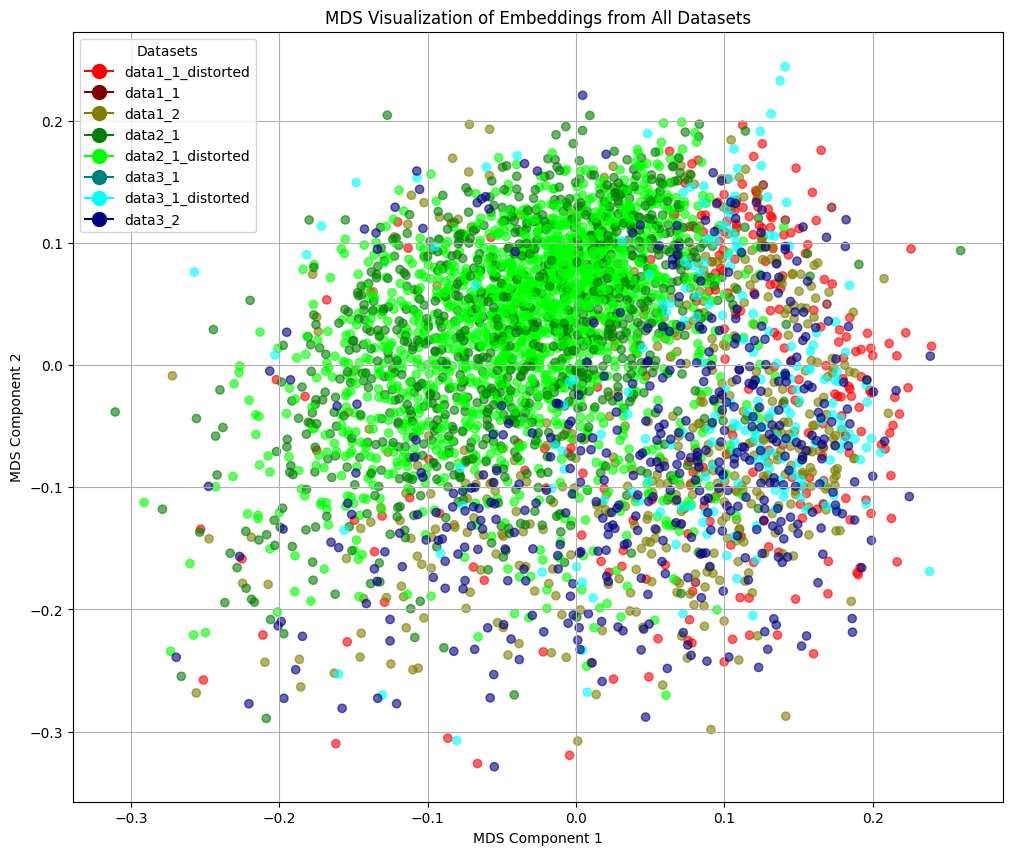

In [ ]:
# All cases
# Get the original dataset indices for coloring
data1_1_len = len(data1_1_encoded)
data1_2_len = len(data1_2_encoded)
data2_1_len = len(data2_1_encoded)
data3_1_len = len(data3_1_encoded)
data3_2_len = len(data3_2_encoded)

dataset_indices = []
dataset_indices += [(0.5*x+0.5, 0, 0) for x in data1_1_labels] # data1_1
dataset_indices += [(0.5, 0.5, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, 0.5*x+0.5, 0) for x in data2_1_labels] # data2_1
dataset_indices += [(0, 0.5*x+0.5, 0.5*x+0.5) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 0.5) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(1, 0, 0), label='data1_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0.5, 0, 0), label='data1_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0.5, 0.5, 0), label='data1_2', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0.5, 0), label='data2_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 0), label='data2_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0.5, 0.5), label='data3_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 1), label='data3_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 0.5), label='data3_2', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

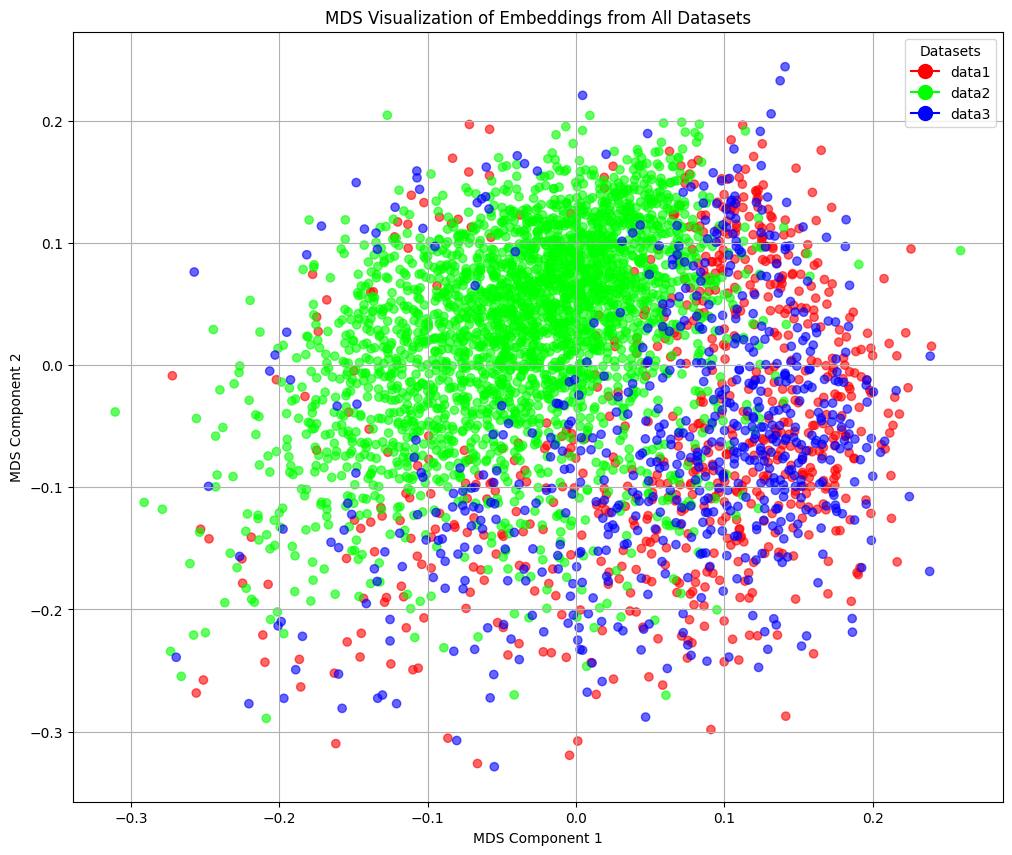

In [ ]:
# Comparing data - source
# Get the original dataset indices for coloring
dataset_indices = []
dataset_indices += [(1, 0, 0) for x in data1_1_labels] # data1_1
dataset_indices += [(1, 0, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, 1, 0) for x in data2_1_labels] # data2_1
dataset_indices += [(0, 0, 1) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 1) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(1, 0, 0), label='data1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 0), label='data2', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 1), label='data3', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

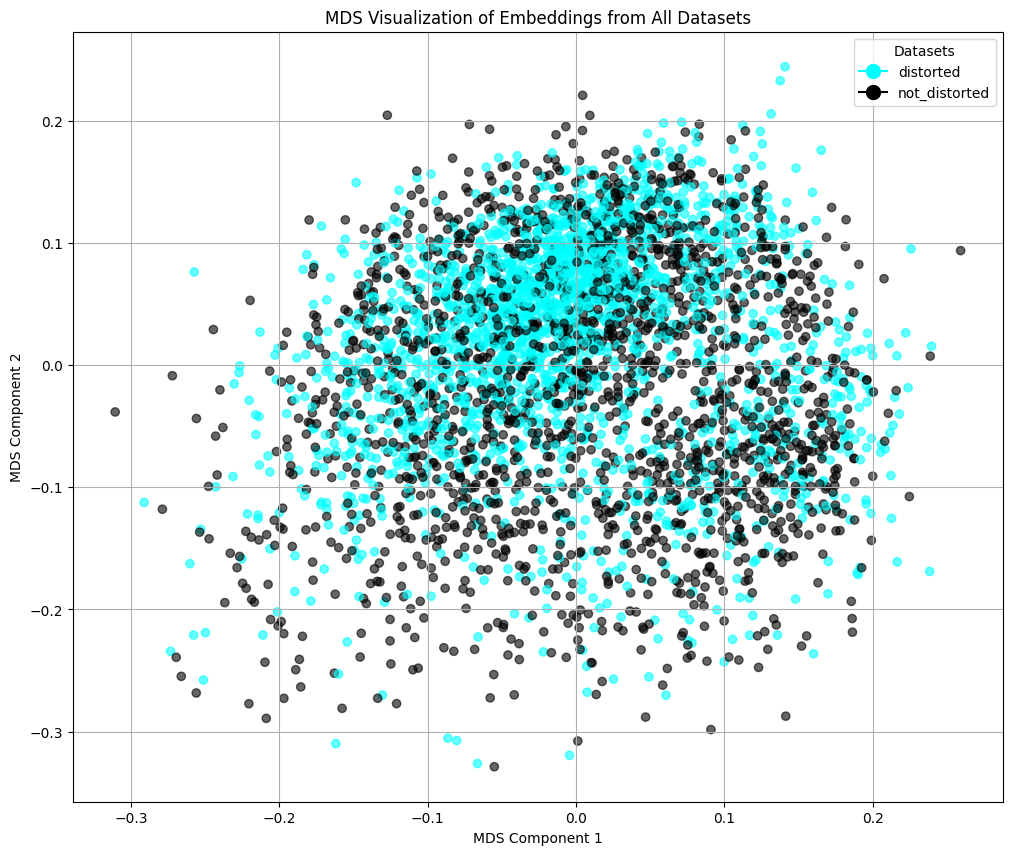

In [ ]:
# Comparing data - distortedness
# Get the original dataset indices for coloring
data1_1_len = len(data1_1_encoded)
data1_2_len = len(data1_2_encoded)
data2_1_len = len(data2_1_encoded)
data3_1_len = len(data3_1_encoded)
data3_2_len = len(data3_2_encoded)

dataset_indices = []
dataset_indices += [(0, x, x) for x in data1_1_labels] # data1_1
dataset_indices += [(0, 0, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, x, x) for x in data2_1_labels] # data2_1
dataset_indices += [(0, x, x) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 0) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(0, 1, 1), label='distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 0), label='not_distorted', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

#### 4-1-2. 잠재 벡터

In [ ]:
# latent vector
print(model.label_emb)

Parameter containing:
tensor([[-0.3568,  0.8098,  0.0264,  ...,  0.7092, -0.6431,  1.6627],
        [ 1.9616,  0.2682, -0.1296,  ..., -0.6282,  0.3225,  1.0843]],
       device='cuda:0', requires_grad=True)


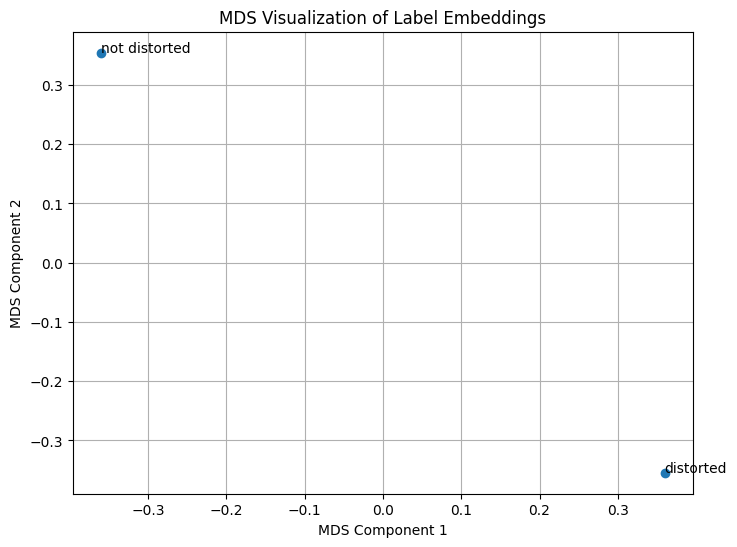

In [ ]:
# Get the label embeddings
label_embeddings = model.label_emb.detach().cpu().numpy()

# Compute similarity and distance matrices
similarity_matrix_labels = cosine_similarity(label_embeddings)
distance_matrix_labels = 1 - similarity_matrix_labels

# Perform MDS on label embeddings
mds_labels = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
mds_result_labels = mds_labels.fit_transform(distance_matrix_labels)

# Get the labels for plotting (0 and 1 in this case)
labels_for_plot = list(range(len(label_embeddings)))

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(mds_result_labels[:, 0], mds_result_labels[:, 1])

# Annotate points with labels
labelled=['not distorted', 'distorted']
for i, label in enumerate(labels_for_plot):
    plt.text(mds_result_labels[i, 0], mds_result_labels[i, 1], labelled[label])

plt.title('MDS Visualization of Label Embeddings')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

## 5. DANN

### 5-1. 자료 재구성

In [ ]:
all_data_encoded = []
all_task_labels = []
all_domain_labels = []

all_data_encoded.extend(data1_1_encoded)
all_task_labels.extend(data1_1_labels)
all_domain_labels.extend([0] * len(data1_1_encoded))

all_data_encoded.extend(data1_2_encoded)
all_task_labels.extend(data1_2_labels)
all_domain_labels.extend([0] * len(data1_2_encoded))

all_data_encoded.extend(data2_1_encoded)
all_task_labels.extend(data2_1_labels)
all_domain_labels.extend([1] * len(data2_1_encoded))

all_data_encoded.extend(data3_1_encoded)
all_task_labels.extend(data3_1_labels)
all_domain_labels.extend([0] * len(data3_1_encoded))

all_data_encoded.extend(data3_2_encoded)
all_task_labels.extend(data3_2_labels)
all_domain_labels.extend([2] * len(data3_2_encoded))


class CustomDatasetWithDomainLabels(Dataset):
    def __init__(self, data, task_labels, domain_labels):
        self.data = data
        self.task_labels = task_labels
        self.domain_labels = domain_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {"input_ids": self.data[idx]['input_ids'].squeeze(),
                "attention_mask": self.data[idx]['attention_mask'].squeeze(),
                "task_label": self.task_labels[idx],
                "domain_label": self.domain_labels[idx]}


dataset_with_domain_labels = CustomDatasetWithDomainLabels(all_data_encoded, all_task_labels, all_domain_labels)

### 5-2. 모델 정의

In [ ]:
from torch.autograd import Function

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_val):
        ctx.lambda_val = lambda_val
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.lambda_val
        return grad_input, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_val):
        super(GradientReversalLayer, self).__init__()
        self.lambda_val = lambda_val

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_val)

In [ ]:
class DANNClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes, num_domains, lambda_val=1.0, trainable_feature_extractor=False):
        super(DANNClassifier, self).__init__()
        # Register feature_extractor as a submodule
        self.feature_extractor = feature_extractor

        if not trainable_feature_extractor:
            # Freeze the parameters of the feature extractor (BERT)
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        # Label Classifier (task classifier)
        self.label_classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Domain Classifier
        self.domain_classifier = nn.Sequential(
            GradientReversalLayer(lambda_val),
            nn.Linear(self.feature_extractor.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_domains)
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        # Feature extraction
        outputs = self.feature_extractor(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :] # [CLS] token embedding

        # Label classification
        label_logits = self.label_classifier(features)

        # Domain classification with GRL
        domain_logits = self.domain_classifier(features)

        return label_logits, domain_logits

In [ ]:
train_size = int(0.8 * len(dataset_with_domain_labels))
val_size = int(0.1 * len(dataset_with_domain_labels))
test_size = len(dataset_with_domain_labels) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_with_domain_labels, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_dataloader_dann = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader_dann = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader_dann = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
num_labels = len(set(all_task_labels))
num_domains = len(set(all_domain_labels))

# Instantiate the DANNClassifier model
dann_model = DANNClassifier(bert_model, num_labels, num_domains).to(device)

# Define two separate loss functions
criterion_task = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()

# Define an optimizer for the DANNClassifier model
optimizer_dann = torch.optim.AdamW(dann_model.parameters(), lr=2e-5) # Reduced learning rate for DANN

def evaluate_dann(model, dataloader, device=device):
    model.eval()
    all_task_preds, all_task_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            task_labels = batch["task_label"].to(device)

            # Forward pass through DANN model
            label_logits, _ = model(input_ids, attention_mask)

            task_preds = torch.argmax(label_logits, dim=1)
            all_task_preds.extend(task_preds.cpu().tolist())
            all_task_labels.extend(task_labels.cpu().tolist())

    acc = accuracy_score(all_task_labels, all_task_preds)
    f1_macro = f1_score(all_task_labels, all_task_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

### 5-3. 모델 학습

In [ ]:
import copy

EPOCHS = 10000 # In maximum range, can be modified
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list_dann = [] # Use a new list for DANN validation accuracies

for epoch in range(EPOCHS):
    dann_model.train()
    total_train_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_dataloader_dann, desc=f"Epoch {epoch+1} [DANN]")):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        task_labels = batch["task_label"].to(device)
        domain_labels = batch["domain_label"].to(device)

        # Forward pass through DANN model
        label_logits, domain_logits = dann_model(input_ids, attention_mask)

        # Calculate task loss
        task_loss = criterion_task(label_logits, task_labels)

        # Calculate domain loss
        domain_loss = criterion_domain(domain_logits, domain_labels)

        # Combine losses
        total_loss = task_loss + domain_loss # alpha is assumed 1.0 for now as per DANNClassifier init

        # Backpropagate and update weights
        optimizer_dann.zero_grad()
        total_loss.backward()
        optimizer_dann.step()

        print(f"Loss: {total_loss.item()}")

    # Evaluate on the validation set after each epoch
    val_metrics = evaluate_dann(dann_model, val_dataloader_dann, device)
    print(f"Epoch {epoch+1} [DANN] Validation Accuracy: {val_metrics['accuracy']:.4f}, F1-macro: {val_metrics['f1_macro']:.4f}")
    val_acc = val_metrics['accuracy']
    val_acc_list_dann.append(val_acc)
    is_improved = val_acc > best_val_acc

    # Update best model
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(dann_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1 [DANN]:   2%|▏         | 1/49 [00:01<01:30,  1.88s/it]

Loss: 1.7820169925689697


Epoch 1 [DANN]:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 1.7830049991607666


Epoch 1 [DANN]:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 1.7672607898712158


Epoch 1 [DANN]:   8%|▊         | 4/49 [00:07<01:23,  1.85s/it]

Loss: 1.7211413383483887


Epoch 1 [DANN]:  10%|█         | 5/49 [00:09<01:21,  1.85s/it]

Loss: 1.7903988361358643


Epoch 1 [DANN]:  12%|█▏        | 6/49 [00:11<01:19,  1.85s/it]

Loss: 1.7468355894088745


Epoch 1 [DANN]:  14%|█▍        | 7/49 [00:12<01:18,  1.86s/it]

Loss: 1.7484997510910034


Epoch 1 [DANN]:  16%|█▋        | 8/49 [00:14<01:16,  1.87s/it]

Loss: 1.7548636198043823


Epoch 1 [DANN]:  18%|█▊        | 9/49 [00:16<01:14,  1.87s/it]

Loss: 1.7011163234710693


Epoch 1 [DANN]:  20%|██        | 10/49 [00:18<01:12,  1.87s/it]

Loss: 1.7259200811386108


Epoch 1 [DANN]:  22%|██▏       | 11/49 [00:20<01:11,  1.88s/it]

Loss: 1.6878101825714111


Epoch 1 [DANN]:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 1.7195062637329102


Epoch 1 [DANN]:  27%|██▋       | 13/49 [00:24<01:07,  1.89s/it]

Loss: 1.7597640752792358


Epoch 1 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 1.7199643850326538


Epoch 1 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 1.6769654750823975


Epoch 1 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.7302069664001465


Epoch 1 [DANN]:  35%|███▍      | 17/49 [00:31<01:00,  1.90s/it]

Loss: 1.6680920124053955


Epoch 1 [DANN]:  37%|███▋      | 18/49 [00:33<00:59,  1.90s/it]

Loss: 1.7331631183624268


Epoch 1 [DANN]:  39%|███▉      | 19/49 [00:35<00:57,  1.91s/it]

Loss: 1.648850917816162


Epoch 1 [DANN]:  41%|████      | 20/49 [00:37<00:55,  1.91s/it]

Loss: 1.680992603302002


Epoch 1 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.91s/it]

Loss: 1.6488734483718872


Epoch 1 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.92s/it]

Loss: 1.663752794265747


Epoch 1 [DANN]:  47%|████▋     | 23/49 [00:43<00:50,  1.93s/it]

Loss: 1.6807454824447632


Epoch 1 [DANN]:  49%|████▉     | 24/49 [00:45<00:48,  1.93s/it]

Loss: 1.64381742477417


Epoch 1 [DANN]:  51%|█████     | 25/49 [00:47<00:46,  1.94s/it]

Loss: 1.6599701642990112


Epoch 1 [DANN]:  53%|█████▎    | 26/49 [00:49<00:44,  1.94s/it]

Loss: 1.5771024227142334


Epoch 1 [DANN]:  55%|█████▌    | 27/49 [00:51<00:42,  1.94s/it]

Loss: 1.645836591720581


Epoch 1 [DANN]:  57%|█████▋    | 28/49 [00:53<00:40,  1.93s/it]

Loss: 1.6644786596298218


Epoch 1 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.93s/it]

Loss: 1.6791396141052246


Epoch 1 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.92s/it]

Loss: 1.694920301437378


Epoch 1 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.92s/it]

Loss: 1.6931135654449463


Epoch 1 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.91s/it]

Loss: 1.5897575616836548


Epoch 1 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.92s/it]

Loss: 1.6078920364379883


Epoch 1 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.92s/it]

Loss: 1.6647555828094482


Epoch 1 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.91s/it]

Loss: 1.572164535522461


Epoch 1 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.92s/it]

Loss: 1.5704786777496338


Epoch 1 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 1.6303846836090088


Epoch 1 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.91s/it]

Loss: 1.6544032096862793


Epoch 1 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.90s/it]

Loss: 1.607446551322937


Epoch 1 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.90s/it]

Loss: 1.6408964395523071


Epoch 1 [DANN]:  84%|████████▎ | 41/49 [01:17<00:15,  1.89s/it]

Loss: 1.5969020128250122


Epoch 1 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.89s/it]

Loss: 1.521257758140564


Epoch 1 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.89s/it]

Loss: 1.528106451034546


Epoch 1 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.89s/it]

Loss: 1.5199825763702393


Epoch 1 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.88s/it]

Loss: 1.5385584831237793


Epoch 1 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.88s/it]

Loss: 1.5261132717132568


Epoch 1 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.88s/it]

Loss: 1.618362307548523


Epoch 1 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.89s/it]

Loss: 1.513437032699585


Epoch 1 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.6492562294006348


Epoch 1 [DANN] Validation Accuracy: 0.5518, F1-macro: 0.4850
Validation accuracy improved. Best accuracy: 0.5518


Epoch 2 [DANN]:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 1.5221786499023438


Epoch 2 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.88s/it]

Loss: 1.5534099340438843


Epoch 2 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.89s/it]

Loss: 1.4429349899291992


Epoch 2 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.90s/it]

Loss: 1.499316930770874


Epoch 2 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 1.5023353099822998


Epoch 2 [DANN]:  12%|█▏        | 6/49 [00:11<01:22,  1.91s/it]

Loss: 1.5145264863967896


Epoch 2 [DANN]:  14%|█▍        | 7/49 [00:13<01:20,  1.91s/it]

Loss: 1.5315124988555908


Epoch 2 [DANN]:  16%|█▋        | 8/49 [00:15<01:18,  1.91s/it]

Loss: 1.6244632005691528


Epoch 2 [DANN]:  18%|█▊        | 9/49 [00:17<01:16,  1.91s/it]

Loss: 1.4739549160003662


Epoch 2 [DANN]:  20%|██        | 10/49 [00:19<01:14,  1.91s/it]

Loss: 1.5443828105926514


Epoch 2 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.91s/it]

Loss: 1.491434097290039


Epoch 2 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.92s/it]

Loss: 1.5463991165161133


Epoch 2 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.92s/it]

Loss: 1.4994996786117554


Epoch 2 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.91s/it]

Loss: 1.4678666591644287


Epoch 2 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.91s/it]

Loss: 1.5897328853607178


Epoch 2 [DANN]:  33%|███▎      | 16/49 [00:30<01:03,  1.91s/it]

Loss: 1.4691479206085205


Epoch 2 [DANN]:  35%|███▍      | 17/49 [00:32<01:01,  1.91s/it]

Loss: 1.502062201499939


Epoch 2 [DANN]:  37%|███▋      | 18/49 [00:34<00:59,  1.91s/it]

Loss: 1.4997837543487549


Epoch 2 [DANN]:  39%|███▉      | 19/49 [00:36<00:57,  1.91s/it]

Loss: 1.5300097465515137


Epoch 2 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.90s/it]

Loss: 1.4146571159362793


Epoch 2 [DANN]:  43%|████▎     | 21/49 [00:40<00:53,  1.91s/it]

Loss: 1.5234155654907227


Epoch 2 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.91s/it]

Loss: 1.459861397743225


Epoch 2 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.91s/it]

Loss: 1.4359369277954102


Epoch 2 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.91s/it]

Loss: 1.5068769454956055


Epoch 2 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.91s/it]

Loss: 1.395546793937683


Epoch 2 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.90s/it]

Loss: 1.540007472038269


Epoch 2 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.4956156015396118


Epoch 2 [DANN]:  57%|█████▋    | 28/49 [00:53<00:39,  1.90s/it]

Loss: 1.562584400177002


Epoch 2 [DANN]:  59%|█████▉    | 29/49 [00:55<00:37,  1.90s/it]

Loss: 1.446338176727295


Epoch 2 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.4672341346740723


Epoch 2 [DANN]:  63%|██████▎   | 31/49 [00:59<00:34,  1.90s/it]

Loss: 1.5028407573699951


Epoch 2 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.4760777950286865


Epoch 2 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.90s/it]

Loss: 1.3866486549377441


Epoch 2 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.90s/it]

Loss: 1.5438644886016846


Epoch 2 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.90s/it]

Loss: 1.5613800287246704


Epoch 2 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.90s/it]

Loss: 1.416566252708435


Epoch 2 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.90s/it]

Loss: 1.4103617668151855


Epoch 2 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.90s/it]

Loss: 1.413483738899231


Epoch 2 [DANN]:  80%|███████▉  | 39/49 [01:14<00:18,  1.89s/it]

Loss: 1.5070912837982178


Epoch 2 [DANN]:  82%|████████▏ | 40/49 [01:16<00:16,  1.89s/it]

Loss: 1.5020638704299927


Epoch 2 [DANN]:  84%|████████▎ | 41/49 [01:18<00:15,  1.89s/it]

Loss: 1.5568621158599854


Epoch 2 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.89s/it]

Loss: 1.4748773574829102


Epoch 2 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.89s/it]

Loss: 1.4631950855255127


Epoch 2 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.89s/it]

Loss: 1.4104084968566895


Epoch 2 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.89s/it]

Loss: 1.561187744140625


Epoch 2 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.89s/it]

Loss: 1.523069977760315


Epoch 2 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.89s/it]

Loss: 1.4702372550964355


Epoch 2 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 1.3507719039916992


Epoch 2 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.7715383768081665


Epoch 2 [DANN] Validation Accuracy: 0.6166, F1-macro: 0.5878
Validation accuracy improved. Best accuracy: 0.6166


Epoch 3 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.4067189693450928


Epoch 3 [DANN]:   4%|▍         | 2/49 [00:03<01:29,  1.90s/it]

Loss: 1.4796499013900757


Epoch 3 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.89s/it]

Loss: 1.3869481086730957


Epoch 3 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.90s/it]

Loss: 1.4005415439605713


Epoch 3 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 1.4876998662948608


Epoch 3 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.90s/it]

Loss: 1.5234720706939697


Epoch 3 [DANN]:  14%|█▍        | 7/49 [00:13<01:20,  1.91s/it]

Loss: 1.3476344347000122


Epoch 3 [DANN]:  16%|█▋        | 8/49 [00:15<01:18,  1.90s/it]

Loss: 1.4975336790084839


Epoch 3 [DANN]:  18%|█▊        | 9/49 [00:17<01:16,  1.90s/it]

Loss: 1.357253074645996


Epoch 3 [DANN]:  20%|██        | 10/49 [00:18<01:14,  1.90s/it]

Loss: 1.4994533061981201


Epoch 3 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.91s/it]

Loss: 1.3273699283599854


Epoch 3 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.91s/it]

Loss: 1.473062515258789


Epoch 3 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.91s/it]

Loss: 1.4166595935821533


Epoch 3 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.91s/it]

Loss: 1.3032492399215698


Epoch 3 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.91s/it]

Loss: 1.4593181610107422


Epoch 3 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.91s/it]

Loss: 1.3936033248901367


Epoch 3 [DANN]:  35%|███▍      | 17/49 [00:32<01:01,  1.91s/it]

Loss: 1.36322820186615


Epoch 3 [DANN]:  37%|███▋      | 18/49 [00:34<00:59,  1.91s/it]

Loss: 1.4324662685394287


Epoch 3 [DANN]:  39%|███▉      | 19/49 [00:36<00:57,  1.91s/it]

Loss: 1.394761085510254


Epoch 3 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.90s/it]

Loss: 1.4867188930511475


Epoch 3 [DANN]:  43%|████▎     | 21/49 [00:40<00:53,  1.90s/it]

Loss: 1.319244384765625


Epoch 3 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.90s/it]

Loss: 1.461045503616333


Epoch 3 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.90s/it]

Loss: 1.4883079528808594


Epoch 3 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.90s/it]

Loss: 1.4277788400650024


Epoch 3 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.90s/it]

Loss: 1.321000576019287


Epoch 3 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.90s/it]

Loss: 1.3466687202453613


Epoch 3 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.346024990081787


Epoch 3 [DANN]:  57%|█████▋    | 28/49 [00:53<00:39,  1.90s/it]

Loss: 1.4704225063323975


Epoch 3 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.90s/it]

Loss: 1.45906662940979


Epoch 3 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.396477222442627


Epoch 3 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.90s/it]

Loss: 1.3804552555084229


Epoch 3 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.5586459636688232


Epoch 3 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.89s/it]

Loss: 1.3710200786590576


Epoch 3 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.89s/it]

Loss: 1.485714077949524


Epoch 3 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.89s/it]

Loss: 1.3940238952636719


Epoch 3 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.89s/it]

Loss: 1.4417731761932373


Epoch 3 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.89s/it]

Loss: 1.5150096416473389


Epoch 3 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.90s/it]

Loss: 1.3470675945281982


Epoch 3 [DANN]:  80%|███████▉  | 39/49 [01:14<00:18,  1.89s/it]

Loss: 1.3741135597229004


Epoch 3 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.89s/it]

Loss: 1.522138237953186


Epoch 3 [DANN]:  84%|████████▎ | 41/49 [01:17<00:15,  1.89s/it]

Loss: 1.2829105854034424


Epoch 3 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.89s/it]

Loss: 1.4342129230499268


Epoch 3 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.3783087730407715


Epoch 3 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.90s/it]

Loss: 1.4067652225494385


Epoch 3 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.90s/it]

Loss: 1.3698309659957886


Epoch 3 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.90s/it]

Loss: 1.3807415962219238


Epoch 3 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.4246597290039062


Epoch 3 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 1.377748966217041


Epoch 3 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.3691961765289307


Epoch 3 [DANN] Validation Accuracy: 0.6736, F1-macro: 0.6666
Validation accuracy improved. Best accuracy: 0.6736


Epoch 4 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.86s/it]

Loss: 1.3269246816635132


Epoch 4 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.88s/it]

Loss: 1.325716257095337


Epoch 4 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.89s/it]

Loss: 1.3345235586166382


Epoch 4 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.90s/it]

Loss: 1.3635456562042236


Epoch 4 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.91s/it]

Loss: 1.4886395931243896


Epoch 4 [DANN]:  12%|█▏        | 6/49 [00:11<01:22,  1.91s/it]

Loss: 1.243551254272461


Epoch 4 [DANN]:  14%|█▍        | 7/49 [00:13<01:20,  1.91s/it]

Loss: 1.2890095710754395


Epoch 4 [DANN]:  16%|█▋        | 8/49 [00:15<01:18,  1.91s/it]

Loss: 1.4990859031677246


Epoch 4 [DANN]:  18%|█▊        | 9/49 [00:17<01:16,  1.91s/it]

Loss: 1.3444069623947144


Epoch 4 [DANN]:  20%|██        | 10/49 [00:19<01:14,  1.90s/it]

Loss: 1.5230891704559326


Epoch 4 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.90s/it]

Loss: 1.5029659271240234


Epoch 4 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.90s/it]

Loss: 1.27464759349823


Epoch 4 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.91s/it]

Loss: 1.4459972381591797


Epoch 4 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.91s/it]

Loss: 1.3037433624267578


Epoch 4 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.91s/it]

Loss: 1.4247173070907593


Epoch 4 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.91s/it]

Loss: 1.3554097414016724


Epoch 4 [DANN]:  35%|███▍      | 17/49 [00:32<01:01,  1.91s/it]

Loss: 1.3397396802902222


Epoch 4 [DANN]:  37%|███▋      | 18/49 [00:34<00:59,  1.91s/it]

Loss: 1.389291763305664


Epoch 4 [DANN]:  39%|███▉      | 19/49 [00:36<00:57,  1.91s/it]

Loss: 1.3452491760253906


Epoch 4 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.91s/it]

Loss: 1.146086573600769


Epoch 4 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.90s/it]

Loss: 1.3388752937316895


Epoch 4 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.91s/it]

Loss: 1.2660892009735107


Epoch 4 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.91s/it]

Loss: 1.2819106578826904


Epoch 4 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.91s/it]

Loss: 1.1975529193878174


Epoch 4 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.90s/it]

Loss: 1.3100467920303345


Epoch 4 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.90s/it]

Loss: 1.2797398567199707


Epoch 4 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.91s/it]

Loss: 1.4606313705444336


Epoch 4 [DANN]:  57%|█████▋    | 28/49 [00:53<00:39,  1.90s/it]

Loss: 1.4073987007141113


Epoch 4 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.90s/it]

Loss: 1.3213295936584473


Epoch 4 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.419795274734497


Epoch 4 [DANN]:  63%|██████▎   | 31/49 [00:59<00:34,  1.90s/it]

Loss: 1.411241054534912


Epoch 4 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.4241583347320557


Epoch 4 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.89s/it]

Loss: 1.3435580730438232


Epoch 4 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.90s/it]

Loss: 1.3241558074951172


Epoch 4 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.90s/it]

Loss: 1.3982222080230713


Epoch 4 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.90s/it]

Loss: 1.3167359828948975


Epoch 4 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 1.2091774940490723


Epoch 4 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.91s/it]

Loss: 1.299973487854004


Epoch 4 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.91s/it]

Loss: 1.35511314868927


Epoch 4 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.90s/it]

Loss: 1.3821213245391846


Epoch 4 [DANN]:  84%|████████▎ | 41/49 [01:18<00:15,  1.90s/it]

Loss: 1.2962450981140137


Epoch 4 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.90s/it]

Loss: 1.2722548246383667


Epoch 4 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.2217472791671753


Epoch 4 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.90s/it]

Loss: 1.4360861778259277


Epoch 4 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.90s/it]

Loss: 1.411428451538086


Epoch 4 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.90s/it]

Loss: 1.354200839996338


Epoch 4 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.395216464996338


Epoch 4 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 1.380602240562439


Epoch 4 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.1681514978408813


Epoch 4 [DANN] Validation Accuracy: 0.6762, F1-macro: 0.6704
Validation accuracy improved. Best accuracy: 0.6762


Epoch 5 [DANN]:   2%|▏         | 1/49 [00:01<01:30,  1.89s/it]

Loss: 1.3474202156066895


Epoch 5 [DANN]:   4%|▍         | 2/49 [00:03<01:29,  1.90s/it]

Loss: 1.3127996921539307


Epoch 5 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.90s/it]

Loss: 1.4110215902328491


Epoch 5 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.90s/it]

Loss: 1.3567780256271362


Epoch 5 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.91s/it]

Loss: 1.2199208736419678


Epoch 5 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.90s/it]

Loss: 1.2232639789581299


Epoch 5 [DANN]:  14%|█▍        | 7/49 [00:13<01:19,  1.90s/it]

Loss: 1.2520408630371094


Epoch 5 [DANN]:  16%|█▋        | 8/49 [00:15<01:17,  1.90s/it]

Loss: 1.3904030323028564


Epoch 5 [DANN]:  18%|█▊        | 9/49 [00:17<01:15,  1.90s/it]

Loss: 1.2576550245285034


Epoch 5 [DANN]:  20%|██        | 10/49 [00:19<01:14,  1.90s/it]

Loss: 1.2677435874938965


Epoch 5 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.91s/it]

Loss: 1.430783987045288


Epoch 5 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.91s/it]

Loss: 1.218912124633789


Epoch 5 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.91s/it]

Loss: 1.19205904006958


Epoch 5 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.91s/it]

Loss: 1.300283432006836


Epoch 5 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.91s/it]

Loss: 1.1942670345306396


Epoch 5 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.2652829885482788


Epoch 5 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.90s/it]

Loss: 1.207355260848999


Epoch 5 [DANN]:  37%|███▋      | 18/49 [00:34<00:58,  1.90s/it]

Loss: 1.3967515230178833


Epoch 5 [DANN]:  39%|███▉      | 19/49 [00:36<00:56,  1.90s/it]

Loss: 1.1834852695465088


Epoch 5 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.90s/it]

Loss: 1.2962205410003662


Epoch 5 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.90s/it]

Loss: 1.3318395614624023


Epoch 5 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.90s/it]

Loss: 1.2648072242736816


Epoch 5 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.90s/it]

Loss: 1.3427175283432007


Epoch 5 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.90s/it]

Loss: 1.342477798461914


Epoch 5 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.90s/it]

Loss: 1.281282901763916


Epoch 5 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.90s/it]

Loss: 1.366708755493164


Epoch 5 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.331949234008789


Epoch 5 [DANN]:  57%|█████▋    | 28/49 [00:53<00:39,  1.90s/it]

Loss: 1.3421895503997803


Epoch 5 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.90s/it]

Loss: 1.2496126890182495


Epoch 5 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.328273057937622


Epoch 5 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.90s/it]

Loss: 1.2127646207809448


Epoch 5 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.2976891994476318


Epoch 5 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.90s/it]

Loss: 1.212927222251892


Epoch 5 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.90s/it]

Loss: 1.3068956136703491


Epoch 5 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.90s/it]

Loss: 1.2020705938339233


Epoch 5 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.90s/it]

Loss: 1.3387970924377441


Epoch 5 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 1.2729196548461914


Epoch 5 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.90s/it]

Loss: 1.2864054441452026


Epoch 5 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.90s/it]

Loss: 1.1658716201782227


Epoch 5 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.90s/it]

Loss: 1.3326833248138428


Epoch 5 [DANN]:  84%|████████▎ | 41/49 [01:17<00:15,  1.90s/it]

Loss: 1.2758262157440186


Epoch 5 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.91s/it]

Loss: 1.2735345363616943


Epoch 5 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.91s/it]

Loss: 1.2963511943817139


Epoch 5 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.91s/it]

Loss: 1.3734135627746582


Epoch 5 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.91s/it]

Loss: 1.2899681329727173


Epoch 5 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.91s/it]

Loss: 1.3756346702575684


Epoch 5 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.91s/it]

Loss: 1.207763671875


Epoch 5 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.91s/it]

Loss: 1.2170147895812988


Epoch 5 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.1667542457580566


Epoch 5 [DANN] Validation Accuracy: 0.6813, F1-macro: 0.6757
Validation accuracy improved. Best accuracy: 0.6813


Epoch 6 [DANN]:   2%|▏         | 1/49 [00:01<01:30,  1.88s/it]

Loss: 1.197096586227417


Epoch 6 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.89s/it]

Loss: 1.3028895854949951


Epoch 6 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.90s/it]

Loss: 1.4057974815368652


Epoch 6 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.89s/it]

Loss: 1.1776036024093628


Epoch 6 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 1.1144882440567017


Epoch 6 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.90s/it]

Loss: 1.236690878868103


Epoch 6 [DANN]:  14%|█▍        | 7/49 [00:13<01:19,  1.90s/it]

Loss: 1.3020637035369873


Epoch 6 [DANN]:  16%|█▋        | 8/49 [00:15<01:17,  1.90s/it]

Loss: 1.2486324310302734


Epoch 6 [DANN]:  18%|█▊        | 9/49 [00:17<01:15,  1.90s/it]

Loss: 1.167379379272461


Epoch 6 [DANN]:  20%|██        | 10/49 [00:18<01:13,  1.90s/it]

Loss: 1.2212069034576416


Epoch 6 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.90s/it]

Loss: 1.1667832136154175


Epoch 6 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.90s/it]

Loss: 1.231126308441162


Epoch 6 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.90s/it]

Loss: 1.3506319522857666


Epoch 6 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 1.2258310317993164


Epoch 6 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.89s/it]

Loss: 1.2932062149047852


Epoch 6 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.89s/it]

Loss: 1.303228735923767


Epoch 6 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.90s/it]

Loss: 1.2774722576141357


Epoch 6 [DANN]:  37%|███▋      | 18/49 [00:34<00:58,  1.90s/it]

Loss: 1.2761200666427612


Epoch 6 [DANN]:  39%|███▉      | 19/49 [00:36<00:57,  1.90s/it]

Loss: 1.3637619018554688


Epoch 6 [DANN]:  41%|████      | 20/49 [00:37<00:55,  1.90s/it]

Loss: 1.3140974044799805


Epoch 6 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.90s/it]

Loss: 1.139815092086792


Epoch 6 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.90s/it]

Loss: 1.2432252168655396


Epoch 6 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.90s/it]

Loss: 1.2736226320266724


Epoch 6 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.89s/it]

Loss: 1.222170114517212


Epoch 6 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.90s/it]

Loss: 1.2700674533843994


Epoch 6 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.90s/it]

Loss: 1.2543561458587646


Epoch 6 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.2853760719299316


Epoch 6 [DANN]:  57%|█████▋    | 28/49 [00:53<00:39,  1.90s/it]

Loss: 1.1114981174468994


Epoch 6 [DANN]:  59%|█████▉    | 29/49 [00:55<00:37,  1.90s/it]

Loss: 1.2258901596069336


Epoch 6 [DANN]:  61%|██████    | 30/49 [00:56<00:36,  1.90s/it]

Loss: 1.304349660873413


Epoch 6 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.90s/it]

Loss: 1.2207436561584473


Epoch 6 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.91s/it]

Loss: 1.3419047594070435


Epoch 6 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.91s/it]

Loss: 1.2532176971435547


Epoch 6 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.91s/it]

Loss: 1.2719202041625977


Epoch 6 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.91s/it]

Loss: 1.3023443222045898


Epoch 6 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.91s/it]

Loss: 1.2374461889266968


Epoch 6 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 1.2630188465118408


Epoch 6 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.90s/it]

Loss: 1.1043946743011475


Epoch 6 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.91s/it]

Loss: 1.191056489944458


Epoch 6 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.91s/it]

Loss: 1.1899168491363525


Epoch 6 [DANN]:  84%|████████▎ | 41/49 [01:17<00:15,  1.91s/it]

Loss: 1.0451264381408691


Epoch 6 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.90s/it]

Loss: 1.2073445320129395


Epoch 6 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.1006290912628174


Epoch 6 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.90s/it]

Loss: 1.121461272239685


Epoch 6 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.90s/it]

Loss: 1.234706163406372


Epoch 6 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.90s/it]

Loss: 1.1579967737197876


Epoch 6 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.378821849822998


Epoch 6 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 1.2587217092514038


Epoch 6 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.527775764465332


Epoch 6 [DANN] Validation Accuracy: 0.6865, F1-macro: 0.6842
Validation accuracy improved. Best accuracy: 0.6865


Epoch 7 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.1556549072265625


Epoch 7 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.89s/it]

Loss: 1.2391775846481323


Epoch 7 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.90s/it]

Loss: 1.2887088060379028


Epoch 7 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.89s/it]

Loss: 1.199318766593933


Epoch 7 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 1.200709342956543


Epoch 7 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.90s/it]

Loss: 1.2502020597457886


Epoch 7 [DANN]:  14%|█▍        | 7/49 [00:13<01:19,  1.90s/it]

Loss: 1.206939935684204


Epoch 7 [DANN]:  16%|█▋        | 8/49 [00:15<01:17,  1.90s/it]

Loss: 1.214885950088501


Epoch 7 [DANN]:  18%|█▊        | 9/49 [00:17<01:15,  1.90s/it]

Loss: 1.2557588815689087


Epoch 7 [DANN]:  20%|██        | 10/49 [00:18<01:14,  1.90s/it]

Loss: 1.2617714405059814


Epoch 7 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.91s/it]

Loss: 1.2404863834381104


Epoch 7 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.91s/it]

Loss: 1.165147304534912


Epoch 7 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.91s/it]

Loss: 1.1595314741134644


Epoch 7 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 1.1807000637054443


Epoch 7 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 1.1999833583831787


Epoch 7 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.1951558589935303


Epoch 7 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.90s/it]

Loss: 1.2731746435165405


Epoch 7 [DANN]:  37%|███▋      | 18/49 [00:34<00:58,  1.90s/it]

Loss: 1.2486923933029175


Epoch 7 [DANN]:  39%|███▉      | 19/49 [00:36<00:56,  1.90s/it]

Loss: 1.1820454597473145


Epoch 7 [DANN]:  41%|████      | 20/49 [00:37<00:55,  1.90s/it]

Loss: 1.2118836641311646


Epoch 7 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.91s/it]

Loss: 1.241016149520874


Epoch 7 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.90s/it]

Loss: 1.1679794788360596


Epoch 7 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.91s/it]

Loss: 1.1047570705413818


Epoch 7 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.91s/it]

Loss: 1.2832564115524292


Epoch 7 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.91s/it]

Loss: 1.2021206617355347


Epoch 7 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.91s/it]

Loss: 1.2725830078125


Epoch 7 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.91s/it]

Loss: 1.0476281642913818


Epoch 7 [DANN]:  57%|█████▋    | 28/49 [00:53<00:40,  1.91s/it]

Loss: 1.1335722208023071


Epoch 7 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.90s/it]

Loss: 1.1243748664855957


Epoch 7 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.1456928253173828


Epoch 7 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.90s/it]

Loss: 1.2127768993377686


Epoch 7 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.91s/it]

Loss: 1.238045573234558


Epoch 7 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.91s/it]

Loss: 1.139911413192749


Epoch 7 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.91s/it]

Loss: 1.1410781145095825


Epoch 7 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.91s/it]

Loss: 1.3472226858139038


Epoch 7 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.91s/it]

Loss: 1.154090404510498


Epoch 7 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 1.2380917072296143


Epoch 7 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.90s/it]

Loss: 1.0877807140350342


Epoch 7 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.90s/it]

Loss: 1.1521086692810059


Epoch 7 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.90s/it]

Loss: 1.1855597496032715


Epoch 7 [DANN]:  84%|████████▎ | 41/49 [01:18<00:15,  1.90s/it]

Loss: 1.2382738590240479


Epoch 7 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.91s/it]

Loss: 1.0462287664413452


Epoch 7 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.13309645652771


Epoch 7 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.90s/it]

Loss: 1.1911972761154175


Epoch 7 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.91s/it]

Loss: 1.2005950212478638


Epoch 7 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.91s/it]

Loss: 1.1177570819854736


Epoch 7 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.2174816131591797


Epoch 7 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 1.2202582359313965


Epoch 7 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.88s/it]

Loss: 1.2302794456481934


Epoch 7 [DANN] Validation Accuracy: 0.6839, F1-macro: 0.6805
Validation accuracy did not improve. Patience counter: 1/5


Epoch 8 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.190093755722046


Epoch 8 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.89s/it]

Loss: 1.1728564500808716


Epoch 8 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.91s/it]

Loss: 1.215503454208374


Epoch 8 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.91s/it]

Loss: 1.1939924955368042


Epoch 8 [DANN]:  10%|█         | 5/49 [00:09<01:24,  1.91s/it]

Loss: 1.1466898918151855


Epoch 8 [DANN]:  12%|█▏        | 6/49 [00:11<01:22,  1.91s/it]

Loss: 1.2203885316848755


Epoch 8 [DANN]:  14%|█▍        | 7/49 [00:13<01:20,  1.91s/it]

Loss: 1.1081591844558716


Epoch 8 [DANN]:  16%|█▋        | 8/49 [00:15<01:18,  1.91s/it]

Loss: 1.143690586090088


Epoch 8 [DANN]:  18%|█▊        | 9/49 [00:17<01:16,  1.91s/it]

Loss: 1.3264646530151367


Epoch 8 [DANN]:  20%|██        | 10/49 [00:19<01:14,  1.91s/it]

Loss: 1.2393481731414795


Epoch 8 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.91s/it]

Loss: 1.2120475769042969


Epoch 8 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.90s/it]

Loss: 1.1781915426254272


Epoch 8 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.90s/it]

Loss: 1.2027862071990967


Epoch 8 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 1.1348628997802734


Epoch 8 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 1.123783826828003


Epoch 8 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.1251896619796753


Epoch 8 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.91s/it]

Loss: 1.2400257587432861


Epoch 8 [DANN]:  37%|███▋      | 18/49 [00:34<00:59,  1.90s/it]

Loss: 1.0772308111190796


Epoch 8 [DANN]:  39%|███▉      | 19/49 [00:36<00:57,  1.90s/it]

Loss: 1.1826967000961304


Epoch 8 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.91s/it]

Loss: 1.117496132850647


Epoch 8 [DANN]:  43%|████▎     | 21/49 [00:40<00:53,  1.91s/it]

Loss: 1.1981594562530518


Epoch 8 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.91s/it]

Loss: 1.2713651657104492


Epoch 8 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.91s/it]

Loss: 1.2051153182983398


Epoch 8 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.91s/it]

Loss: 1.1406712532043457


Epoch 8 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.91s/it]

Loss: 1.1952167749404907


Epoch 8 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.91s/it]

Loss: 1.4761016368865967


Epoch 8 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.0581543445587158


Epoch 8 [DANN]:  57%|█████▋    | 28/49 [00:53<00:40,  1.91s/it]

Loss: 1.1039316654205322


Epoch 8 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.91s/it]

Loss: 1.079676866531372


Epoch 8 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.2342898845672607


Epoch 8 [DANN]:  63%|██████▎   | 31/49 [00:59<00:34,  1.90s/it]

Loss: 1.1407761573791504


Epoch 8 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.1855342388153076


Epoch 8 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.90s/it]

Loss: 1.1485159397125244


Epoch 8 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.90s/it]

Loss: 1.0337281227111816


Epoch 8 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.90s/it]

Loss: 1.170111894607544


Epoch 8 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.91s/it]

Loss: 1.1091382503509521


Epoch 8 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.90s/it]

Loss: 1.16758394241333


Epoch 8 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.90s/it]

Loss: 1.0637662410736084


Epoch 8 [DANN]:  80%|███████▉  | 39/49 [01:14<00:18,  1.90s/it]

Loss: 1.2333848476409912


Epoch 8 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.90s/it]

Loss: 1.1021170616149902


Epoch 8 [DANN]:  84%|████████▎ | 41/49 [01:18<00:15,  1.90s/it]

Loss: 1.2697203159332275


Epoch 8 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.89s/it]

Loss: 1.245438575744629


Epoch 8 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.1583423614501953


Epoch 8 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.90s/it]

Loss: 0.9689077138900757


Epoch 8 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.90s/it]

Loss: 1.181596279144287


Epoch 8 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.90s/it]

Loss: 1.1443804502487183


Epoch 8 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.0857970714569092


Epoch 8 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 1.080346703529358


Epoch 8 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 0.7929637432098389


Epoch 8 [DANN] Validation Accuracy: 0.6865, F1-macro: 0.6833
Validation accuracy did not improve. Patience counter: 2/5


Epoch 9 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.1816411018371582


Epoch 9 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.88s/it]

Loss: 1.0744549036026


Epoch 9 [DANN]:   6%|▌         | 3/49 [00:05<01:26,  1.89s/it]

Loss: 1.0850080251693726


Epoch 9 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.89s/it]

Loss: 1.1132310628890991


Epoch 9 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 1.267007827758789


Epoch 9 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.90s/it]

Loss: 1.0638927221298218


Epoch 9 [DANN]:  14%|█▍        | 7/49 [00:13<01:19,  1.89s/it]

Loss: 1.0439082384109497


Epoch 9 [DANN]:  16%|█▋        | 8/49 [00:15<01:17,  1.90s/it]

Loss: 1.1682522296905518


Epoch 9 [DANN]:  18%|█▊        | 9/49 [00:17<01:15,  1.89s/it]

Loss: 1.0817594528198242


Epoch 9 [DANN]:  20%|██        | 10/49 [00:18<01:13,  1.89s/it]

Loss: 1.0266695022583008


Epoch 9 [DANN]:  22%|██▏       | 11/49 [00:20<01:11,  1.89s/it]

Loss: 1.1272435188293457


Epoch 9 [DANN]:  24%|██▍       | 12/49 [00:22<01:09,  1.89s/it]

Loss: 1.0257645845413208


Epoch 9 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.89s/it]

Loss: 1.2341978549957275


Epoch 9 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.89s/it]

Loss: 1.1651675701141357


Epoch 9 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 1.1396737098693848


Epoch 9 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.1611335277557373


Epoch 9 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.89s/it]

Loss: 1.0899232625961304


Epoch 9 [DANN]:  37%|███▋      | 18/49 [00:34<00:58,  1.89s/it]

Loss: 1.2236433029174805


Epoch 9 [DANN]:  39%|███▉      | 19/49 [00:35<00:56,  1.89s/it]

Loss: 1.1121253967285156


Epoch 9 [DANN]:  41%|████      | 20/49 [00:37<00:54,  1.89s/it]

Loss: 0.9953197836875916


Epoch 9 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.89s/it]

Loss: 1.154689073562622


Epoch 9 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.90s/it]

Loss: 1.1026666164398193


Epoch 9 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.89s/it]

Loss: 1.1836057901382446


Epoch 9 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.89s/it]

Loss: 1.2612262964248657


Epoch 9 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.89s/it]

Loss: 1.0264387130737305


Epoch 9 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.89s/it]

Loss: 1.1333519220352173


Epoch 9 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.0442306995391846


Epoch 9 [DANN]:  57%|█████▋    | 28/49 [00:52<00:39,  1.89s/it]

Loss: 1.132343053817749


Epoch 9 [DANN]:  59%|█████▉    | 29/49 [00:54<00:37,  1.89s/it]

Loss: 1.1887025833129883


Epoch 9 [DANN]:  61%|██████    | 30/49 [00:56<00:36,  1.90s/it]

Loss: 1.130825161933899


Epoch 9 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.90s/it]

Loss: 1.0216535329818726


Epoch 9 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.1976335048675537


Epoch 9 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.90s/it]

Loss: 1.24229097366333


Epoch 9 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.89s/it]

Loss: 1.124405860900879


Epoch 9 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.89s/it]

Loss: 0.9893959760665894


Epoch 9 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.89s/it]

Loss: 1.2748689651489258


Epoch 9 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.90s/it]

Loss: 1.1403285264968872


Epoch 9 [DANN]:  78%|███████▊  | 38/49 [01:11<00:20,  1.90s/it]

Loss: 1.2215957641601562


Epoch 9 [DANN]:  80%|███████▉  | 39/49 [01:13<00:18,  1.89s/it]

Loss: 1.0957847833633423


Epoch 9 [DANN]:  82%|████████▏ | 40/49 [01:15<00:17,  1.89s/it]

Loss: 1.217083215713501


Epoch 9 [DANN]:  84%|████████▎ | 41/49 [01:17<00:15,  1.89s/it]

Loss: 1.2877895832061768


Epoch 9 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.89s/it]

Loss: 1.1636502742767334


Epoch 9 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.127643346786499


Epoch 9 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.89s/it]

Loss: 1.0513514280319214


Epoch 9 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.89s/it]

Loss: 1.044036626815796


Epoch 9 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.89s/it]

Loss: 1.0581161975860596


Epoch 9 [DANN]:  96%|█████████▌| 47/49 [01:28<00:03,  1.89s/it]

Loss: 0.9976444840431213


Epoch 9 [DANN]:  98%|█████████▊| 48/49 [01:30<00:01,  1.89s/it]

Loss: 1.063515067100525


Epoch 9 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.86s/it]

Loss: 1.1583434343338013


Epoch 9 [DANN] Validation Accuracy: 0.6813, F1-macro: 0.6793
Validation accuracy did not improve. Patience counter: 3/5


Epoch 10 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.167541742324829


Epoch 10 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.89s/it]

Loss: 1.1986947059631348


Epoch 10 [DANN]:   6%|▌         | 3/49 [00:05<01:26,  1.89s/it]

Loss: 1.141161561012268


Epoch 10 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.89s/it]

Loss: 0.9935795664787292


Epoch 10 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 1.1865816116333008


Epoch 10 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.91s/it]

Loss: 1.1332758665084839


Epoch 10 [DANN]:  14%|█▍        | 7/49 [00:13<01:19,  1.90s/it]

Loss: 1.083656668663025


Epoch 10 [DANN]:  16%|█▋        | 8/49 [00:15<01:18,  1.90s/it]

Loss: 1.0842924118041992


Epoch 10 [DANN]:  18%|█▊        | 9/49 [00:17<01:16,  1.91s/it]

Loss: 0.9843851923942566


Epoch 10 [DANN]:  20%|██        | 10/49 [00:19<01:14,  1.90s/it]

Loss: 1.2012734413146973


Epoch 10 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.91s/it]

Loss: 1.1650962829589844


Epoch 10 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.90s/it]

Loss: 0.977229654788971


Epoch 10 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.91s/it]

Loss: 1.0425937175750732


Epoch 10 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 1.030289649963379


Epoch 10 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 1.0371792316436768


Epoch 10 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.2510907649993896


Epoch 10 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.90s/it]

Loss: 1.106986165046692


Epoch 10 [DANN]:  37%|███▋      | 18/49 [00:34<00:58,  1.90s/it]

Loss: 1.0523512363433838


Epoch 10 [DANN]:  39%|███▉      | 19/49 [00:36<00:56,  1.90s/it]

Loss: 1.1736745834350586


Epoch 10 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.90s/it]

Loss: 1.0789597034454346


Epoch 10 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.91s/it]

Loss: 1.180154800415039


Epoch 10 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.91s/it]

Loss: 0.9887458682060242


Epoch 10 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.91s/it]

Loss: 1.2385518550872803


Epoch 10 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.91s/it]

Loss: 1.0435670614242554


Epoch 10 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.90s/it]

Loss: 1.1181635856628418


Epoch 10 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.90s/it]

Loss: 1.061259388923645


Epoch 10 [DANN]:  55%|█████▌    | 27/49 [00:51<00:41,  1.90s/it]

Loss: 1.1009730100631714


Epoch 10 [DANN]:  57%|█████▋    | 28/49 [00:53<00:39,  1.90s/it]

Loss: 1.1494858264923096


Epoch 10 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.90s/it]

Loss: 1.0366359949111938


Epoch 10 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.90s/it]

Loss: 1.084995150566101


Epoch 10 [DANN]:  63%|██████▎   | 31/49 [00:58<00:34,  1.90s/it]

Loss: 1.0048809051513672


Epoch 10 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.90s/it]

Loss: 1.1133737564086914


Epoch 10 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.90s/it]

Loss: 1.0085370540618896


Epoch 10 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.91s/it]

Loss: 1.1993191242218018


Epoch 10 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.90s/it]

Loss: 1.1170696020126343


Epoch 10 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.91s/it]

Loss: 1.0957634449005127


Epoch 10 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 0.9606958627700806


Epoch 10 [DANN]:  78%|███████▊  | 38/49 [01:12<00:20,  1.91s/it]

Loss: 1.220888376235962


Epoch 10 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.91s/it]

Loss: 1.1649892330169678


Epoch 10 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.91s/it]

Loss: 1.1418778896331787


Epoch 10 [DANN]:  84%|████████▎ | 41/49 [01:18<00:15,  1.91s/it]

Loss: 1.1135369539260864


Epoch 10 [DANN]:  86%|████████▌ | 42/49 [01:19<00:13,  1.91s/it]

Loss: 1.0434770584106445


Epoch 10 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.91s/it]

Loss: 1.1442251205444336


Epoch 10 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.91s/it]

Loss: 1.0195984840393066


Epoch 10 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.91s/it]

Loss: 1.1121046543121338


Epoch 10 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.91s/it]

Loss: 1.0544512271881104


Epoch 10 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.0986658334732056


Epoch 10 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 0.9763026833534241


Epoch 10 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.87s/it]

Loss: 1.1718943119049072


Epoch 10 [DANN] Validation Accuracy: 0.6839, F1-macro: 0.6823
Validation accuracy did not improve. Patience counter: 4/5


Epoch 11 [DANN]:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.1444449424743652


Epoch 11 [DANN]:   4%|▍         | 2/49 [00:03<01:28,  1.88s/it]

Loss: 1.1511722803115845


Epoch 11 [DANN]:   6%|▌         | 3/49 [00:05<01:27,  1.90s/it]

Loss: 1.1587387323379517


Epoch 11 [DANN]:   8%|▊         | 4/49 [00:07<01:25,  1.90s/it]

Loss: 1.0352282524108887


Epoch 11 [DANN]:  10%|█         | 5/49 [00:09<01:23,  1.91s/it]

Loss: 1.2246582508087158


Epoch 11 [DANN]:  12%|█▏        | 6/49 [00:11<01:21,  1.91s/it]

Loss: 1.306628704071045


Epoch 11 [DANN]:  14%|█▍        | 7/49 [00:13<01:19,  1.90s/it]

Loss: 1.0553038120269775


Epoch 11 [DANN]:  16%|█▋        | 8/49 [00:15<01:18,  1.90s/it]

Loss: 1.0642184019088745


Epoch 11 [DANN]:  18%|█▊        | 9/49 [00:17<01:16,  1.91s/it]

Loss: 0.9943988919258118


Epoch 11 [DANN]:  20%|██        | 10/49 [00:19<01:14,  1.90s/it]

Loss: 1.0204240083694458


Epoch 11 [DANN]:  22%|██▏       | 11/49 [00:20<01:12,  1.90s/it]

Loss: 1.128583550453186


Epoch 11 [DANN]:  24%|██▍       | 12/49 [00:22<01:10,  1.90s/it]

Loss: 1.0539729595184326


Epoch 11 [DANN]:  27%|██▋       | 13/49 [00:24<01:08,  1.90s/it]

Loss: 1.0711684226989746


Epoch 11 [DANN]:  29%|██▊       | 14/49 [00:26<01:06,  1.90s/it]

Loss: 1.088974118232727


Epoch 11 [DANN]:  31%|███       | 15/49 [00:28<01:04,  1.90s/it]

Loss: 1.2029495239257812


Epoch 11 [DANN]:  33%|███▎      | 16/49 [00:30<01:02,  1.90s/it]

Loss: 1.1849886178970337


Epoch 11 [DANN]:  35%|███▍      | 17/49 [00:32<01:00,  1.90s/it]

Loss: 0.9761916995048523


Epoch 11 [DANN]:  37%|███▋      | 18/49 [00:34<00:59,  1.91s/it]

Loss: 0.9474849700927734


Epoch 11 [DANN]:  39%|███▉      | 19/49 [00:36<00:57,  1.91s/it]

Loss: 1.0953924655914307


Epoch 11 [DANN]:  41%|████      | 20/49 [00:38<00:55,  1.90s/it]

Loss: 1.0311214923858643


Epoch 11 [DANN]:  43%|████▎     | 21/49 [00:39<00:53,  1.90s/it]

Loss: 1.1601405143737793


Epoch 11 [DANN]:  45%|████▍     | 22/49 [00:41<00:51,  1.90s/it]

Loss: 1.0826590061187744


Epoch 11 [DANN]:  47%|████▋     | 23/49 [00:43<00:49,  1.90s/it]

Loss: 0.9833256006240845


Epoch 11 [DANN]:  49%|████▉     | 24/49 [00:45<00:47,  1.91s/it]

Loss: 0.9222656488418579


Epoch 11 [DANN]:  51%|█████     | 25/49 [00:47<00:45,  1.91s/it]

Loss: 1.1288670301437378


Epoch 11 [DANN]:  53%|█████▎    | 26/49 [00:49<00:43,  1.91s/it]

Loss: 1.1719764471054077


Epoch 11 [DANN]:  55%|█████▌    | 27/49 [00:51<00:42,  1.92s/it]

Loss: 1.013697862625122


Epoch 11 [DANN]:  57%|█████▋    | 28/49 [00:53<00:40,  1.91s/it]

Loss: 0.9462629556655884


Epoch 11 [DANN]:  59%|█████▉    | 29/49 [00:55<00:38,  1.91s/it]

Loss: 1.048201560974121


Epoch 11 [DANN]:  61%|██████    | 30/49 [00:57<00:36,  1.91s/it]

Loss: 0.9351580739021301


Epoch 11 [DANN]:  63%|██████▎   | 31/49 [00:59<00:34,  1.91s/it]

Loss: 1.0952036380767822


Epoch 11 [DANN]:  65%|██████▌   | 32/49 [01:00<00:32,  1.92s/it]

Loss: 1.1152081489562988


Epoch 11 [DANN]:  67%|██████▋   | 33/49 [01:02<00:30,  1.91s/it]

Loss: 1.0816149711608887


Epoch 11 [DANN]:  69%|██████▉   | 34/49 [01:04<00:28,  1.91s/it]

Loss: 1.0071322917938232


Epoch 11 [DANN]:  71%|███████▏  | 35/49 [01:06<00:26,  1.91s/it]

Loss: 1.1351940631866455


Epoch 11 [DANN]:  73%|███████▎  | 36/49 [01:08<00:24,  1.91s/it]

Loss: 0.9349651336669922


Epoch 11 [DANN]:  76%|███████▌  | 37/49 [01:10<00:22,  1.91s/it]

Loss: 1.1911048889160156


Epoch 11 [DANN]:  78%|███████▊  | 38/49 [01:12<00:21,  1.91s/it]

Loss: 1.0346746444702148


Epoch 11 [DANN]:  80%|███████▉  | 39/49 [01:14<00:19,  1.91s/it]

Loss: 1.1006875038146973


Epoch 11 [DANN]:  82%|████████▏ | 40/49 [01:16<00:17,  1.90s/it]

Loss: 0.9828431010246277


Epoch 11 [DANN]:  84%|████████▎ | 41/49 [01:18<00:15,  1.91s/it]

Loss: 1.201595664024353


Epoch 11 [DANN]:  86%|████████▌ | 42/49 [01:20<00:13,  1.90s/it]

Loss: 1.1049519777297974


Epoch 11 [DANN]:  88%|████████▊ | 43/49 [01:21<00:11,  1.90s/it]

Loss: 1.017132043838501


Epoch 11 [DANN]:  90%|████████▉ | 44/49 [01:23<00:09,  1.90s/it]

Loss: 1.1413097381591797


Epoch 11 [DANN]:  92%|█████████▏| 45/49 [01:25<00:07,  1.90s/it]

Loss: 1.059289813041687


Epoch 11 [DANN]:  94%|█████████▍| 46/49 [01:27<00:05,  1.90s/it]

Loss: 1.0662431716918945


Epoch 11 [DANN]:  96%|█████████▌| 47/49 [01:29<00:03,  1.90s/it]

Loss: 1.0671032667160034


Epoch 11 [DANN]:  98%|█████████▊| 48/49 [01:31<00:01,  1.90s/it]

Loss: 0.9541223049163818


Epoch 11 [DANN]: 100%|██████████| 49/49 [01:31<00:00,  1.88s/it]

Loss: 1.1489681005477905


Epoch 11 [DANN] Validation Accuracy: 0.6865, F1-macro: 0.6845
Validation accuracy did not improve. Patience counter: 5/5
[Early Stopping] No improvement for 5 consecutive epochs. Stopping training.
DANN model training complete.


### 5-4. 모델 테스트

In [ ]:
# Evaluate on the test set for the best model
dann_model.load_state_dict(best_model_state)
test_metrics = evaluate_dann(dann_model, test_dataloader_dann, device)
print(f"Test Accuracy: {test_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Test Accuracy: 0.6795865633074936, F1-macro: 0.6844935319350154


## 6. LoRA를 이용한 BERT 파인튜닝

### 6-1. 준비

In [ ]:
!pip install peft

In [ ]:
from peft import LoraConfig, get_peft_model

# LoRA configuration parameters
r = 8
lora_alpha = 16
lora_dropout = 0.1

### 6-2. 자료 재구성

In [ ]:
dataset_with_labels = CustomDatasetWithLabels(data_encoded, data_labels)

# Define proportions for splitting
train_size = int(0.8 * len(dataset_with_labels))
val_size = int(0.1 * len(dataset_with_labels))
test_size = len(dataset_with_labels) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_with_labels, [train_size, val_size, test_size])

# Create DataLoaders for each set with a reduced batch_size
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

input_dim = bert_config.hidden_size
num_labels = len(set(data_labels))
label_emb = torch.randn(num_labels, input_dim)

### 6-3. 모델 정의

In [ ]:
peft_config = LoraConfig(
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

# Apply LoRA to the BERT model
bert_model_with_lora = get_peft_model(bert_model, peft_config)

# Ensure original BERT parameters are frozen
for name, param in bert_model_with_lora.named_parameters():
    if "lora" not in name and "score" not in name: # 'score' layer is often the classification head
        param.requires_grad = False

In [ ]:
model = InnerProductClassifier(input_dim, label_emb).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Adjust optimizer to train LoRA layers and InnerProductClassifier head
# Get trainable parameters from bert_model_with_lora
lora_params = [p for p in bert_model_with_lora.parameters() if p.requires_grad]

# Get parameters from the InnerProductClassifier
classifier_params = list(model.parameters())

# Combine parameters for the optimizer
optimizer = torch.optim.AdamW(lora_params + classifier_params, lr=2e-4)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(classifier_model, bert_model_for_eval, dataloader, device="cpu"):
    classifier_model.eval()
    bert_model_for_eval.eval() # Set the BERT model (with LoRA) to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["y"].to(device)

            # Get embeddings from the BERT model including LoRA
            outputs = bert_model_for_eval(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

            logits = classifier_model(embeddings)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

### 6-4. 모델 학습

In [ ]:
import copy

EPOCHS = 10000 # In maximum range, can be modified
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []

# Move the BERT model (with LoRA) to the device
bert_model_with_lora.to(device)

for epoch in range(EPOCHS):
    model.train()
    bert_model_with_lora.train() # Set BERT model (with LoRA) to training mode
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["y"].to(device)

        # Get embeddings from the BERT model (now bert_model_with_lora, allowing gradient update)
        # Removed torch.no_grad() around bert_model_with_lora
        outputs = bert_model_with_lora(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Pass embeddings to the InnerProductClassifier
        logits = model(embeddings)
        loss = criterion(logits, y)

        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

    # Evaluate on the validation set after each epoch
    # Pass bert_model_with_lora to the evaluate function
    val_metrics = evaluate(model, bert_model_with_lora, val_dataloader, device)
    print(f"Epoch {epoch+1} Validation Accuracy: {val_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")
    val_acc = val_metrics['accuracy']
    val_acc_list.append(val_acc)
    is_improved = val_acc > best_val_acc

    # Update best model
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        # Store the state of the LoRA adapter as well
        best_lora_model_state = copy.deepcopy(bert_model_with_lora.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1:   1%|          | 1/97 [00:02<04:36,  2.88s/it]

Loss: 1.9195730686187744


Epoch 1:   2%|▏         | 2/97 [00:04<03:47,  2.40s/it]

Loss: 9.782938003540039


Epoch 1:   3%|▎         | 3/97 [00:07<03:32,  2.26s/it]

Loss: 4.755324363708496


Epoch 1:   4%|▍         | 4/97 [00:09<03:24,  2.20s/it]

Loss: 5.213376045227051


Epoch 1:   5%|▌         | 5/97 [00:11<03:18,  2.16s/it]

Loss: 2.586681842803955


Epoch 1:   6%|▌         | 6/97 [00:13<03:14,  2.14s/it]

Loss: 3.849846601486206


Epoch 1:   6%|▌         | 6/97 [00:15<03:54,  2.58s/it]


KeyboardInterrupt: 

### 6-5. 모델 테스트

In [ ]:
# Evaluate on the test set for the best model
model.load_state_dict(best_model_state)
test_metrics = evaluate_lora(model, bert_model_with_lora, test_dataloader, device)
print(f"Test Accuracy: {test_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Test Accuracy: 0.8010335917312662, F1-macro: 0.7860946665585381


## 7. DANN + LoRA

### 7-1. 모델 정의

In [ ]:
class LoRADANNClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes, num_domains, lambda_val=1.0):
        super(LoRADANNClassifier, self).__init__()
        self.feature_extractor = feature_extractor

        # LoRA handles freezing base parameters, so no explicit freezing here.

        self.label_classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            GradientReversalLayer(lambda_val),
            nn.Linear(self.feature_extractor.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_domains)
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        # Feature extraction using LoRA-enabled BERT
        outputs = self.feature_extractor(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Label classification
        label_logits = self.label_classifier(features)

        # Domain classification
        domain_logits = self.domain_classifier(features)

        return label_logits, domain_logits

In [ ]:
# Re-prepare data and datasets for DANN + LoRA training (as done previously)
all_data_encoded = []
all_task_labels = []
all_domain_labels = []

all_data_encoded.extend(data1_1_encoded)
all_task_labels.extend(data1_1_labels)
all_domain_labels.extend([0] * len(data1_1_encoded))

all_data_encoded.extend(data1_2_encoded)
all_task_labels.extend(data1_2_labels)
all_domain_labels.extend([0] * len(data1_2_encoded))

all_data_encoded.extend(data2_1_encoded)
all_task_labels.extend(data2_1_labels)
all_domain_labels.extend([1] * len(data2_1_encoded))

all_data_encoded.extend(data3_1_encoded)
all_task_labels.extend(data3_1_labels)
all_domain_labels.extend([0] * len(data3_1_encoded))

all_data_encoded.extend(data3_2_encoded)
all_task_labels.extend(data3_2_labels)
all_domain_labels.extend([2] * len(data3_2_encoded))


# CustomDatasetWithDomainLabels class definition (ensure it's available)
class CustomDatasetWithDomainLabels(Dataset):
    def __init__(self, data, task_labels, domain_labels):
        self.data = data
        self.task_labels = task_labels
        self.domain_labels = domain_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {"input_ids": self.data[idx]['input_ids'].squeeze(),
                "attention_mask": self.data[idx]['attention_mask'].squeeze(),
                "task_label": self.task_labels[idx],
                "domain_label": self.domain_labels[idx]}


dataset_with_domain_labels = CustomDatasetWithDomainLabels(all_data_encoded, all_task_labels, all_domain_labels)

# Split the dataset for DANN + LoRA
train_size = int(0.8 * len(dataset_with_domain_labels))
val_size = int(0.1 * len(dataset_with_domain_labels))
test_size = len(dataset_with_domain_labels) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_with_domain_labels, [train_size, val_size, test_size])

# Create DataLoaders for each set with a reduced batch_size
train_dataloader_lora_dann = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader_lora_dann = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader_lora_dann = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_labels = len(set(all_task_labels))
num_domains = len(set(all_domain_labels))

# Instantiate the LoRADANNClassifier model
lora_dann_model = LoRADANNClassifier(bert_model_with_lora, num_labels, num_domains).to(device)

# Define two separate loss functions
criterion_task = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()

# Identify trainable parameters: LoRA adapters (within bert_model_with_lora) and classifier heads
trainable_params = []
for name, param in lora_dann_model.named_parameters():
    if param.requires_grad:
        trainable_params.append(param)

# Create an AdamW optimizer for these trainable parameters
optimizer_lora_dann = torch.optim.AdamW(trainable_params, lr=2e-5)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_lora_dann(model, dataloader, device):
    model.eval() # Set the LoRADANNClassifier model to evaluation mode
    model.feature_extractor.eval() # Set the LoRA-enabled BERT feature extractor to evaluation mode
    all_task_preds, all_task_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            task_labels = batch["task_label"].to(device)

            # Forward pass through LoRADANNClassifier model
            label_logits, _ = model(input_ids, attention_mask)

            task_preds = torch.argmax(label_logits, dim=1)
            all_task_preds.extend(task_preds.cpu().tolist())
            all_task_labels.extend(task_labels.cpu().tolist())

    acc = accuracy_score(all_task_labels, all_task_preds)
    f1_macro = f1_score(all_task_labels, all_task_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [ ]:
from transformers import BertModel

# Re-initialize the base BERT model to ensure it's clean and not already LoRA-adapted
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

# LoRA configuration parameters
r = 8
lora_alpha = 16
lora_dropout = 0.1

peft_config = LoraConfig(
    r=r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

# Apply LoRA to the freshly initialized BERT model
bert_model_with_lora = get_peft_model(bert_model, peft_config)

# Ensure original BERT parameters are frozen, only LoRA and classification heads are trainable
for name, param in bert_model_with_lora.named_parameters():
    if "lora" not in name and "score" not in name:
        param.requires_grad = False

### 7-2. 모델 학습

In [ ]:
import copy

EPOCHS = 10000 # In maximum range, can be modified
best_val_acc = -1
best_model_state = None
best_lora_model_state = None # To save the state of the LoRA-enabled BERT
patience = 5
patience_counter = 0

val_acc_list_lora_dann = []

# Move the LoRADANNClassifier model to the device
lora_dann_model.to(device)

for epoch in range(EPOCHS):
    lora_dann_model.train() # Set the entire model (including feature_extractor) to training mode
    total_train_loss = 0
    for batch in tqdm(train_dataloader_lora_dann, desc=f"Epoch {epoch+1}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        task_labels = batch["task_label"].to(device)
        domain_labels = batch["domain_label"].to(device)

        # Forward pass through LoRADANNClassifier model
        label_logits, domain_logits = lora_dann_model(input_ids, attention_mask)

        # Calculate task loss
        task_loss = criterion_task(label_logits, task_labels)

        # Calculate domain loss
        domain_loss = criterion_domain(domain_logits, domain_labels)

        # Combine losses
        total_loss = task_loss + domain_loss # alpha is assumed 1.0 for now as per DANNClassifier init

        # Backpropagate and update weights
        optimizer_lora_dann.zero_grad()
        total_loss.backward()
        optimizer_lora_dann.step()

        print(f"Loss: {total_loss.item()}")

    # Evaluate on the validation set after each epoch
    val_metrics = evaluate_lora_dann(lora_dann_model, val_dataloader_lora_dann, device)
    print(f"Epoch {epoch+1} [LoRA-DANN] Validation Accuracy: {val_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")
    val_acc = val_metrics['accuracy']
    val_acc_list_lora_dann.append(val_acc)
    is_improved = val_acc > best_val_acc

    # Update best model
    if is_improved:
        best_val_acc = val_acc
        # Store the state of the entire LoRADANNClassifier, which includes LoRA adapters
        best_model_state = copy.deepcopy(lora_dann_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs. Stopping training.")
        break


Epoch 1:   1%|          | 1/97 [00:03<05:13,  3.27s/it]

Loss: 1.8158700466156006


Epoch 1:   2%|▏         | 2/97 [00:05<04:12,  2.66s/it]

Loss: 1.8196935653686523


Epoch 1:   3%|▎         | 3/97 [00:07<03:53,  2.49s/it]

Loss: 1.756636619567871


Epoch 1:   4%|▍         | 4/97 [00:10<03:42,  2.40s/it]

Loss: 1.7797859907150269


Epoch 1:   5%|▌         | 5/97 [00:12<03:36,  2.35s/it]

Loss: 1.7961539030075073


Epoch 1:   6%|▌         | 6/97 [00:14<03:32,  2.33s/it]

Loss: 1.771453857421875


Epoch 1:   7%|▋         | 7/97 [00:16<03:28,  2.32s/it]

Loss: 1.77801513671875


Epoch 1:   8%|▊         | 8/97 [00:19<03:26,  2.32s/it]

Loss: 1.7449276447296143


Epoch 1:   9%|▉         | 9/97 [00:21<03:24,  2.32s/it]

Loss: 1.6956889629364014


Epoch 1:  10%|█         | 10/97 [00:23<03:22,  2.33s/it]

Loss: 1.731533408164978


Epoch 1:  11%|█▏        | 11/97 [00:26<03:20,  2.33s/it]

Loss: 1.7308952808380127


Epoch 1:  12%|█▏        | 12/97 [00:28<03:19,  2.34s/it]

Loss: 1.72650146484375


Epoch 1:  13%|█▎        | 13/97 [00:30<03:16,  2.34s/it]

Loss: 1.7581686973571777


Epoch 1:  14%|█▍        | 14/97 [00:33<03:14,  2.35s/it]

Loss: 1.7402797937393188


Epoch 1:  15%|█▌        | 15/97 [00:35<03:13,  2.36s/it]

Loss: 1.6955734491348267


Epoch 1:  16%|█▋        | 16/97 [00:38<03:11,  2.37s/it]

Loss: 1.7522053718566895


Epoch 1:  18%|█▊        | 17/97 [00:40<03:10,  2.38s/it]

Loss: 1.6778748035430908


Epoch 1:  19%|█▊        | 18/97 [00:42<03:08,  2.39s/it]

Loss: 1.6371140480041504


Epoch 1:  20%|█▉        | 19/97 [00:45<03:07,  2.40s/it]

Loss: 1.6922664642333984


Epoch 1:  21%|██        | 20/97 [00:47<03:05,  2.41s/it]

Loss: 1.6294407844543457


Epoch 1:  22%|██▏       | 21/97 [00:50<03:04,  2.42s/it]

Loss: 1.682312250137329


Epoch 1:  23%|██▎       | 22/97 [00:52<03:02,  2.44s/it]

Loss: 1.6700780391693115


Epoch 1:  24%|██▎       | 23/97 [00:55<03:01,  2.45s/it]

Loss: 1.560941219329834


Epoch 1:  25%|██▍       | 24/97 [00:57<02:59,  2.46s/it]

Loss: 1.6906063556671143


Epoch 1:  26%|██▌       | 25/97 [01:00<02:58,  2.48s/it]

Loss: 1.7102291584014893


Epoch 1:  27%|██▋       | 26/97 [01:02<02:56,  2.48s/it]

Loss: 1.6763885021209717


Epoch 1:  28%|██▊       | 27/97 [01:05<02:54,  2.49s/it]

Loss: 1.6561976671218872


Epoch 1:  29%|██▉       | 28/97 [01:07<02:53,  2.51s/it]

Loss: 1.7005901336669922


Epoch 1:  30%|██▉       | 29/97 [01:10<02:51,  2.52s/it]

Loss: 1.7129570245742798


Epoch 1:  31%|███       | 30/97 [01:12<02:49,  2.53s/it]

Loss: 1.7019290924072266


Epoch 1:  32%|███▏      | 31/97 [01:15<02:48,  2.55s/it]

Loss: 1.6808784008026123


Epoch 1:  33%|███▎      | 32/97 [01:17<02:46,  2.56s/it]

Loss: 1.6899738311767578


Epoch 1:  34%|███▍      | 33/97 [01:20<02:44,  2.57s/it]

Loss: 1.6005775928497314


Epoch 1:  35%|███▌      | 34/97 [01:23<02:42,  2.57s/it]

Loss: 1.5323526859283447


Epoch 1:  36%|███▌      | 35/97 [01:25<02:39,  2.57s/it]

Loss: 1.5512728691101074


Epoch 1:  37%|███▋      | 36/97 [01:28<02:36,  2.56s/it]

Loss: 1.6943817138671875


Epoch 1:  38%|███▊      | 37/97 [01:30<02:33,  2.56s/it]

Loss: 1.5623624324798584


Epoch 1:  39%|███▉      | 38/97 [01:33<02:30,  2.56s/it]

Loss: 1.6710644960403442


Epoch 1:  40%|████      | 39/97 [01:35<02:27,  2.55s/it]

Loss: 1.6453514099121094


Epoch 1:  41%|████      | 40/97 [01:38<02:24,  2.54s/it]

Loss: 1.636405110359192


Epoch 1:  42%|████▏     | 41/97 [01:40<02:22,  2.54s/it]

Loss: 1.5833156108856201


Epoch 1:  43%|████▎     | 42/97 [01:43<02:19,  2.53s/it]

Loss: 1.6051825284957886


Epoch 1:  44%|████▍     | 43/97 [01:45<02:15,  2.52s/it]

Loss: 1.709651231765747


Epoch 1:  45%|████▌     | 44/97 [01:48<02:12,  2.51s/it]

Loss: 1.6382651329040527


Epoch 1:  46%|████▋     | 45/97 [01:50<02:10,  2.50s/it]

Loss: 1.4782155752182007


Epoch 1:  47%|████▋     | 46/97 [01:53<02:07,  2.49s/it]

Loss: 1.5541629791259766


Epoch 1:  48%|████▊     | 47/97 [01:55<02:04,  2.49s/it]

Loss: 1.500435471534729


Epoch 1:  49%|████▉     | 48/97 [01:58<02:01,  2.48s/it]

Loss: 1.5674681663513184


Epoch 1:  51%|█████     | 49/97 [02:00<01:58,  2.48s/it]

Loss: 1.6706593036651611


Epoch 1:  52%|█████▏    | 50/97 [02:03<01:56,  2.47s/it]

Loss: 1.5799974203109741


Epoch 1:  53%|█████▎    | 51/97 [02:05<01:53,  2.47s/it]

Loss: 1.5078558921813965


Epoch 1:  54%|█████▎    | 52/97 [02:08<01:50,  2.46s/it]

Loss: 1.6122398376464844


Epoch 1:  55%|█████▍    | 53/97 [02:10<01:48,  2.46s/it]

Loss: 1.6632895469665527


Epoch 1:  56%|█████▌    | 54/97 [02:13<01:45,  2.46s/it]

Loss: 1.6503251791000366


Epoch 1:  57%|█████▋    | 55/97 [02:15<01:43,  2.46s/it]

Loss: 1.6896867752075195


Epoch 1:  58%|█████▊    | 56/97 [02:18<01:40,  2.45s/it]

Loss: 1.758813500404358


Epoch 1:  59%|█████▉    | 57/97 [02:20<01:38,  2.46s/it]

Loss: 1.5030471086502075


Epoch 1:  60%|█████▉    | 58/97 [02:22<01:35,  2.46s/it]

Loss: 1.7108805179595947


Epoch 1:  61%|██████    | 59/97 [02:25<01:33,  2.46s/it]

Loss: 1.7398605346679688


Epoch 1:  62%|██████▏   | 60/97 [02:27<01:31,  2.46s/it]

Loss: 1.4985134601593018


Epoch 1:  63%|██████▎   | 61/97 [02:30<01:28,  2.46s/it]

Loss: 1.6548552513122559


Epoch 1:  64%|██████▍   | 62/97 [02:32<01:26,  2.47s/it]

Loss: 1.5908094644546509


Epoch 1:  65%|██████▍   | 63/97 [02:35<01:23,  2.47s/it]

Loss: 1.5930860042572021


Epoch 1:  66%|██████▌   | 64/97 [02:37<01:21,  2.48s/it]

Loss: 1.4315464496612549


Epoch 1:  67%|██████▋   | 65/97 [02:40<01:19,  2.48s/it]

Loss: 1.4406059980392456


Epoch 1:  68%|██████▊   | 66/97 [02:42<01:17,  2.49s/it]

Loss: 1.5569363832473755


Epoch 1:  69%|██████▉   | 67/97 [02:45<01:14,  2.49s/it]

Loss: 1.584028959274292


Epoch 1:  70%|███████   | 68/97 [02:47<01:12,  2.49s/it]

Loss: 1.561650037765503


Epoch 1:  71%|███████   | 69/97 [02:50<01:09,  2.50s/it]

Loss: 1.7010788917541504


Epoch 1:  72%|███████▏  | 70/97 [02:52<01:07,  2.50s/it]

Loss: 1.5589303970336914


Epoch 1:  73%|███████▎  | 71/97 [02:55<01:04,  2.50s/it]

Loss: 1.6505837440490723


Epoch 1:  74%|███████▍  | 72/97 [02:57<01:02,  2.50s/it]

Loss: 1.4876058101654053


Epoch 1:  75%|███████▌  | 73/97 [03:00<01:00,  2.50s/it]

Loss: 1.5837814807891846


Epoch 1:  76%|███████▋  | 74/97 [03:02<00:57,  2.51s/it]

Loss: 1.5822103023529053


Epoch 1:  77%|███████▋  | 75/97 [03:05<00:55,  2.51s/it]

Loss: 1.5318000316619873


Epoch 1:  78%|███████▊  | 76/97 [03:07<00:52,  2.51s/it]

Loss: 1.3860278129577637


Epoch 1:  79%|███████▉  | 77/97 [03:10<00:50,  2.51s/it]

Loss: 1.5338716506958008


Epoch 1:  80%|████████  | 78/97 [03:12<00:47,  2.50s/it]

Loss: 1.6376022100448608


Epoch 1:  81%|████████▏ | 79/97 [03:15<00:45,  2.50s/it]

Loss: 1.5375478267669678


Epoch 1:  82%|████████▏ | 80/97 [03:17<00:42,  2.50s/it]

Loss: 1.5888912677764893


Epoch 1:  84%|████████▎ | 81/97 [03:20<00:39,  2.50s/it]

Loss: 1.5511376857757568


Epoch 1:  85%|████████▍ | 82/97 [03:22<00:37,  2.50s/it]

Loss: 1.5313234329223633


Epoch 1:  86%|████████▌ | 83/97 [03:25<00:34,  2.50s/it]

Loss: 1.4381656646728516


Epoch 1:  87%|████████▋ | 84/97 [03:27<00:32,  2.49s/it]

Loss: 1.6215438842773438


Epoch 1:  88%|████████▊ | 85/97 [03:30<00:29,  2.50s/it]

Loss: 1.5140987634658813


Epoch 1:  89%|████████▊ | 86/97 [03:32<00:27,  2.50s/it]

Loss: 1.5103874206542969


Epoch 1:  90%|████████▉ | 87/97 [03:35<00:24,  2.49s/it]

Loss: 1.7427163124084473


Epoch 1:  91%|█████████ | 88/97 [03:37<00:22,  2.49s/it]

Loss: 1.481559157371521


Epoch 1:  92%|█████████▏| 89/97 [03:40<00:19,  2.49s/it]

Loss: 1.5975720882415771


Epoch 1:  93%|█████████▎| 90/97 [03:42<00:17,  2.49s/it]

Loss: 1.5047309398651123


Epoch 1:  94%|█████████▍| 91/97 [03:45<00:14,  2.49s/it]

Loss: 1.6079195737838745


Epoch 1:  95%|█████████▍| 92/97 [03:47<00:12,  2.49s/it]

Loss: 1.4247825145721436


Epoch 1:  96%|█████████▌| 93/97 [03:50<00:09,  2.49s/it]

Loss: 1.5507524013519287


Epoch 1:  97%|█████████▋| 94/97 [03:52<00:07,  2.49s/it]

Loss: 1.5290467739105225


Epoch 1:  98%|█████████▊| 95/97 [03:55<00:04,  2.49s/it]

Loss: 1.437755823135376


Epoch 1:  99%|█████████▉| 96/97 [03:57<00:02,  2.49s/it]

Loss: 1.5704847574234009


Epoch 1: 100%|██████████| 97/97 [03:59<00:00,  2.46s/it]

Loss: 1.4307668209075928


Epoch 1 [LoRA-DANN] Validation Accuracy: 0.5958549222797928, F1-macro: 0.5459234458420053


Epoch 2:   1%|          | 1/97 [00:02<03:57,  2.48s/it]

Loss: 1.5396134853363037


Epoch 2:   2%|▏         | 2/97 [00:04<03:55,  2.48s/it]

Loss: 1.7185670137405396


Epoch 2:   3%|▎         | 3/97 [00:07<03:53,  2.49s/it]

Loss: 1.481600284576416


Epoch 2:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.4986255168914795


Epoch 2:   5%|▌         | 5/97 [00:12<03:49,  2.49s/it]

Loss: 1.5226938724517822


Epoch 2:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.5132097005844116


Epoch 2:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.4752814769744873


Epoch 2:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.5892064571380615


Epoch 2:   9%|▉         | 9/97 [00:22<03:38,  2.49s/it]

Loss: 1.6987969875335693


Epoch 2:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.4157187938690186


Epoch 2:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.6238027811050415


Epoch 2:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.4942097663879395


Epoch 2:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.626805067062378


Epoch 2:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.5789432525634766


Epoch 2:  15%|█▌        | 15/97 [00:37<03:23,  2.49s/it]

Loss: 1.5014228820800781


Epoch 2:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.535337209701538


Epoch 2:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.5562303066253662


Epoch 2:  19%|█▊        | 18/97 [00:44<03:16,  2.48s/it]

Loss: 1.78096604347229


Epoch 2:  20%|█▉        | 19/97 [00:47<03:13,  2.48s/it]

Loss: 1.5698696374893188


Epoch 2:  21%|██        | 20/97 [00:49<03:11,  2.48s/it]

Loss: 1.6006762981414795


Epoch 2:  22%|██▏       | 21/97 [00:52<03:08,  2.48s/it]

Loss: 1.4562888145446777


Epoch 2:  23%|██▎       | 22/97 [00:54<03:06,  2.48s/it]

Loss: 1.6084545850753784


Epoch 2:  24%|██▎       | 23/97 [00:57<03:03,  2.48s/it]

Loss: 1.521669626235962


Epoch 2:  25%|██▍       | 24/97 [00:59<03:00,  2.47s/it]

Loss: 1.6562126874923706


Epoch 2:  26%|██▌       | 25/97 [01:02<02:58,  2.48s/it]

Loss: 1.497387409210205


Epoch 2:  27%|██▋       | 26/97 [01:04<02:56,  2.48s/it]

Loss: 1.577579140663147


Epoch 2:  28%|██▊       | 27/97 [01:07<02:53,  2.48s/it]

Loss: 1.4940742254257202


Epoch 2:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.5755059719085693


Epoch 2:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.4684271812438965


Epoch 2:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.5993103981018066


Epoch 2:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.6222996711730957


Epoch 2:  33%|███▎      | 32/97 [01:19<02:41,  2.48s/it]

Loss: 1.6412677764892578


Epoch 2:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.5570318698883057


Epoch 2:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.4918980598449707


Epoch 2:  36%|███▌      | 35/97 [01:26<02:33,  2.48s/it]

Loss: 1.6514829397201538


Epoch 2:  37%|███▋      | 36/97 [01:29<02:31,  2.48s/it]

Loss: 1.6096014976501465


Epoch 2:  38%|███▊      | 37/97 [01:31<02:29,  2.49s/it]

Loss: 1.539144515991211


Epoch 2:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.6241486072540283


Epoch 2:  40%|████      | 39/97 [01:36<02:23,  2.48s/it]

Loss: 1.5646638870239258


Epoch 2:  41%|████      | 40/97 [01:39<02:21,  2.48s/it]

Loss: 1.5315113067626953


Epoch 2:  42%|████▏     | 41/97 [01:41<02:19,  2.49s/it]

Loss: 1.4541587829589844


Epoch 2:  43%|████▎     | 42/97 [01:44<02:16,  2.48s/it]

Loss: 1.5985972881317139


Epoch 2:  44%|████▍     | 43/97 [01:46<02:14,  2.49s/it]

Loss: 1.532820224761963


Epoch 2:  45%|████▌     | 44/97 [01:49<02:11,  2.48s/it]

Loss: 1.7691864967346191


Epoch 2:  46%|████▋     | 45/97 [01:51<02:08,  2.48s/it]

Loss: 1.6602702140808105


Epoch 2:  47%|████▋     | 46/97 [01:54<02:06,  2.48s/it]

Loss: 1.5460518598556519


Epoch 2:  48%|████▊     | 47/97 [01:56<02:04,  2.48s/it]

Loss: 1.4844995737075806


Epoch 2:  49%|████▉     | 48/97 [01:59<02:01,  2.49s/it]

Loss: 1.4910480976104736


Epoch 2:  51%|█████     | 49/97 [02:01<01:59,  2.49s/it]

Loss: 1.502046823501587


Epoch 2:  52%|█████▏    | 50/97 [02:04<01:56,  2.49s/it]

Loss: 1.72186279296875


Epoch 2:  53%|█████▎    | 51/97 [02:06<01:54,  2.48s/it]

Loss: 1.5900344848632812


Epoch 2:  54%|█████▎    | 52/97 [02:09<01:51,  2.48s/it]

Loss: 1.516729712486267


Epoch 2:  55%|█████▍    | 53/97 [02:11<01:49,  2.49s/it]

Loss: 1.545673131942749


Epoch 2:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.431279182434082


Epoch 2:  57%|█████▋    | 55/97 [02:16<01:44,  2.49s/it]

Loss: 1.5876548290252686


Epoch 2:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.5196350812911987


Epoch 2:  59%|█████▉    | 57/97 [02:21<01:39,  2.49s/it]

Loss: 1.6074844598770142


Epoch 2:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.4909021854400635


Epoch 2:  61%|██████    | 59/97 [02:26<01:34,  2.49s/it]

Loss: 1.5738812685012817


Epoch 2:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.4737685918807983


Epoch 2:  63%|██████▎   | 61/97 [02:31<01:29,  2.49s/it]

Loss: 1.5064618587493896


Epoch 2:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.5138436555862427


Epoch 2:  65%|██████▍   | 63/97 [02:36<01:24,  2.49s/it]

Loss: 1.5127114057540894


Epoch 2:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.4553802013397217


Epoch 2:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.5742356777191162


Epoch 2:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.4934355020523071


Epoch 2:  69%|██████▉   | 67/97 [02:46<01:14,  2.50s/it]

Loss: 1.3548893928527832


Epoch 2:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.562088966369629


Epoch 2:  71%|███████   | 69/97 [02:51<01:09,  2.49s/it]

Loss: 1.4606313705444336


Epoch 2:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.4965461492538452


Epoch 2:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.605513572692871


Epoch 2:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.588496208190918


Epoch 2:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.7720575332641602


Epoch 2:  76%|███████▋  | 74/97 [03:04<00:57,  2.50s/it]

Loss: 1.6049251556396484


Epoch 2:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.6668963432312012


Epoch 2:  78%|███████▊  | 76/97 [03:09<00:52,  2.50s/it]

Loss: 1.488058090209961


Epoch 2:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.5282588005065918


Epoch 2:  80%|████████  | 78/97 [03:13<00:47,  2.49s/it]

Loss: 1.5330123901367188


Epoch 2:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.4010777473449707


Epoch 2:  82%|████████▏ | 80/97 [03:18<00:42,  2.49s/it]

Loss: 1.5644795894622803


Epoch 2:  84%|████████▎ | 81/97 [03:21<00:39,  2.50s/it]

Loss: 1.5131880044937134


Epoch 2:  85%|████████▍ | 82/97 [03:24<00:37,  2.50s/it]

Loss: 1.4031345844268799


Epoch 2:  86%|████████▌ | 83/97 [03:26<00:34,  2.50s/it]

Loss: 1.5813051462173462


Epoch 2:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.4469399452209473


Epoch 2:  88%|████████▊ | 85/97 [03:31<00:30,  2.50s/it]

Loss: 1.5744625329971313


Epoch 2:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.4787839651107788


Epoch 2:  90%|████████▉ | 87/97 [03:36<00:24,  2.50s/it]

Loss: 1.4565744400024414


Epoch 2:  91%|█████████ | 88/97 [03:38<00:22,  2.50s/it]

Loss: 1.4898781776428223


Epoch 2:  92%|█████████▏| 89/97 [03:41<00:19,  2.50s/it]

Loss: 1.630458116531372


Epoch 2:  93%|█████████▎| 90/97 [03:43<00:17,  2.50s/it]

Loss: 1.4751818180084229


Epoch 2:  94%|█████████▍| 91/97 [03:46<00:14,  2.50s/it]

Loss: 1.552255630493164


Epoch 2:  95%|█████████▍| 92/97 [03:48<00:12,  2.50s/it]

Loss: 1.504225492477417


Epoch 2:  96%|█████████▌| 93/97 [03:51<00:10,  2.50s/it]

Loss: 1.5092941522598267


Epoch 2:  97%|█████████▋| 94/97 [03:53<00:07,  2.50s/it]

Loss: 1.497294545173645


Epoch 2:  98%|█████████▊| 95/97 [03:56<00:05,  2.50s/it]

Loss: 1.631199836730957


Epoch 2:  99%|█████████▉| 96/97 [03:59<00:02,  2.50s/it]

Loss: 1.4819674491882324


Epoch 2: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.4835419654846191


Epoch 2 [LoRA-DANN] Validation Accuracy: 0.6010362694300518, F1-macro: 0.5482017450521388


Epoch 3:   1%|          | 1/97 [00:02<04:01,  2.51s/it]

Loss: 1.3205530643463135


Epoch 3:   2%|▏         | 2/97 [00:05<03:57,  2.50s/it]

Loss: 1.5982706546783447


Epoch 3:   3%|▎         | 3/97 [00:07<03:55,  2.50s/it]

Loss: 1.4608683586120605


Epoch 3:   4%|▍         | 4/97 [00:10<03:52,  2.50s/it]

Loss: 1.3809843063354492


Epoch 3:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.5875005722045898


Epoch 3:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.5337035655975342


Epoch 3:   7%|▋         | 7/97 [00:17<03:44,  2.50s/it]

Loss: 1.390642523765564


Epoch 3:   8%|▊         | 8/97 [00:19<03:42,  2.50s/it]

Loss: 1.7680864334106445


Epoch 3:   9%|▉         | 9/97 [00:22<03:39,  2.49s/it]

Loss: 1.6326398849487305


Epoch 3:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.5043209791183472


Epoch 3:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.5830838680267334


Epoch 3:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.6257588863372803


Epoch 3:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.6272950172424316


Epoch 3:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.476621150970459


Epoch 3:  15%|█▌        | 15/97 [00:37<03:24,  2.50s/it]

Loss: 1.4050589799880981


Epoch 3:  16%|█▋        | 16/97 [00:39<03:22,  2.50s/it]

Loss: 1.521260142326355


Epoch 3:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.6195180416107178


Epoch 3:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.382946252822876


Epoch 3:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.5325417518615723


Epoch 3:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.727362871170044


Epoch 3:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.713287115097046


Epoch 3:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.4794118404388428


Epoch 3:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.536156415939331


Epoch 3:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.323112964630127


Epoch 3:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.6577093601226807


Epoch 3:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.4220762252807617


Epoch 3:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.4100372791290283


Epoch 3:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.6734473705291748


Epoch 3:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.4773924350738525


Epoch 3:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.5512183904647827


Epoch 3:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.4168720245361328


Epoch 3:  33%|███▎      | 32/97 [01:19<02:42,  2.49s/it]

Loss: 1.4833928346633911


Epoch 3:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.5208817720413208


Epoch 3:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.5716884136199951


Epoch 3:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.6288785934448242


Epoch 3:  37%|███▋      | 36/97 [01:29<02:31,  2.49s/it]

Loss: 1.5428612232208252


Epoch 3:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.359953761100769


Epoch 3:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.4094560146331787


Epoch 3:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.3947656154632568


Epoch 3:  41%|████      | 40/97 [01:39<02:21,  2.49s/it]

Loss: 1.4071435928344727


Epoch 3:  42%|████▏     | 41/97 [01:42<02:19,  2.50s/it]

Loss: 1.2353215217590332


Epoch 3:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.4602041244506836


Epoch 3:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.41548752784729


Epoch 3:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.3768733739852905


Epoch 3:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.554059386253357


Epoch 3:  47%|████▋     | 46/97 [01:54<02:06,  2.49s/it]

Loss: 1.5343945026397705


Epoch 3:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.736952543258667


Epoch 3:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.3515920639038086


Epoch 3:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.3887953758239746


Epoch 3:  52%|█████▏    | 50/97 [02:04<01:57,  2.49s/it]

Loss: 1.7088030576705933


Epoch 3:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.527686357498169


Epoch 3:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.489039421081543


Epoch 3:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.438915729522705


Epoch 3:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.5758380889892578


Epoch 3:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.5785797834396362


Epoch 3:  58%|█████▊    | 56/97 [02:19<01:41,  2.48s/it]

Loss: 1.7359832525253296


Epoch 3:  59%|█████▉    | 57/97 [02:22<01:39,  2.48s/it]

Loss: 1.836474061012268


Epoch 3:  60%|█████▉    | 58/97 [02:24<01:36,  2.49s/it]

Loss: 1.6144587993621826


Epoch 3:  61%|██████    | 59/97 [02:27<01:34,  2.49s/it]

Loss: 1.6477609872817993


Epoch 3:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.5249940156936646


Epoch 3:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.3877631425857544


Epoch 3:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.4215619564056396


Epoch 3:  65%|██████▍   | 63/97 [02:36<01:24,  2.49s/it]

Loss: 1.3839242458343506


Epoch 3:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.5798852443695068


Epoch 3:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.6067414283752441


Epoch 3:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.6469101905822754


Epoch 3:  69%|██████▉   | 67/97 [02:46<01:14,  2.48s/it]

Loss: 1.5220096111297607


Epoch 3:  70%|███████   | 68/97 [02:49<01:11,  2.48s/it]

Loss: 1.6260606050491333


Epoch 3:  71%|███████   | 69/97 [02:51<01:09,  2.48s/it]

Loss: 1.575636863708496


Epoch 3:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.6053218841552734


Epoch 3:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.4932446479797363


Epoch 3:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.478498935699463


Epoch 3:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.4733259677886963


Epoch 3:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.5482921600341797


Epoch 3:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.3906724452972412


Epoch 3:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.688058614730835


Epoch 3:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.3142247200012207


Epoch 3:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.3593723773956299


Epoch 3:  81%|████████▏ | 79/97 [03:16<00:44,  2.48s/it]

Loss: 1.5705074071884155


Epoch 3:  82%|████████▏ | 80/97 [03:19<00:42,  2.48s/it]

Loss: 1.569108486175537


Epoch 3:  84%|████████▎ | 81/97 [03:21<00:39,  2.48s/it]

Loss: 1.7940129041671753


Epoch 3:  85%|████████▍ | 82/97 [03:24<00:37,  2.48s/it]

Loss: 1.4469707012176514


Epoch 3:  86%|████████▌ | 83/97 [03:26<00:34,  2.48s/it]

Loss: 1.555702805519104


Epoch 3:  87%|████████▋ | 84/97 [03:29<00:32,  2.48s/it]

Loss: 1.6289122104644775


Epoch 3:  88%|████████▊ | 85/97 [03:31<00:29,  2.49s/it]

Loss: 1.5399482250213623


Epoch 3:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.6001394987106323


Epoch 3:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.557685375213623


Epoch 3:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.5902655124664307


Epoch 3:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.4875800609588623


Epoch 3:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.803106665611267


Epoch 3:  94%|█████████▍| 91/97 [03:46<00:14,  2.49s/it]

Loss: 1.4884419441223145


Epoch 3:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.5261187553405762


Epoch 3:  96%|█████████▌| 93/97 [03:51<00:09,  2.48s/it]

Loss: 1.6323480606079102


Epoch 3:  97%|█████████▋| 94/97 [03:54<00:07,  2.48s/it]

Loss: 1.7103402614593506


Epoch 3:  98%|█████████▊| 95/97 [03:56<00:04,  2.48s/it]

Loss: 1.4894535541534424


Epoch 3:  99%|█████████▉| 96/97 [03:59<00:02,  2.48s/it]

Loss: 1.4542917013168335


Epoch 3: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.4318689107894897


Epoch 3 [LoRA-DANN] Validation Accuracy: 0.5595854922279793, F1-macro: 0.4654262252346194


Epoch 4:   1%|          | 1/97 [00:02<03:57,  2.48s/it]

Loss: 1.6199469566345215


Epoch 4:   2%|▏         | 2/97 [00:04<03:55,  2.48s/it]

Loss: 1.5510504245758057


Epoch 4:   3%|▎         | 3/97 [00:07<03:52,  2.47s/it]

Loss: 1.6271593570709229


Epoch 4:   4%|▍         | 4/97 [00:09<03:49,  2.47s/it]

Loss: 1.505831003189087


Epoch 4:   5%|▌         | 5/97 [00:12<03:47,  2.47s/it]

Loss: 1.553093671798706


Epoch 4:   6%|▌         | 6/97 [00:14<03:45,  2.48s/it]

Loss: 1.438143014907837


Epoch 4:   7%|▋         | 7/97 [00:17<03:42,  2.48s/it]

Loss: 1.6896274089813232


Epoch 4:   8%|▊         | 8/97 [00:19<03:41,  2.48s/it]

Loss: 1.3667278289794922


Epoch 4:   9%|▉         | 9/97 [00:22<03:38,  2.48s/it]

Loss: 1.680253505706787


Epoch 4:  10%|█         | 10/97 [00:24<03:35,  2.48s/it]

Loss: 1.5330734252929688


Epoch 4:  11%|█▏        | 11/97 [00:27<03:33,  2.49s/it]

Loss: 1.5770269632339478


Epoch 4:  12%|█▏        | 12/97 [00:29<03:31,  2.48s/it]

Loss: 1.5641034841537476


Epoch 4:  13%|█▎        | 13/97 [00:32<03:28,  2.49s/it]

Loss: 1.406397819519043


Epoch 4:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.506913423538208


Epoch 4:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.5326120853424072


Epoch 4:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.3119205236434937


Epoch 4:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.5696840286254883


Epoch 4:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.6125092506408691


Epoch 4:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.6823182106018066


Epoch 4:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.5996854305267334


Epoch 4:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.383723258972168


Epoch 4:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.6028473377227783


Epoch 4:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.6821357011795044


Epoch 4:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.6934916973114014


Epoch 4:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.4709961414337158


Epoch 4:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.5421217679977417


Epoch 4:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.7000114917755127


Epoch 4:  29%|██▉       | 28/97 [01:09<02:52,  2.49s/it]

Loss: 1.3521473407745361


Epoch 4:  30%|██▉       | 29/97 [01:12<02:49,  2.50s/it]

Loss: 1.4801740646362305


Epoch 4:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.4283928871154785


Epoch 4:  32%|███▏      | 31/97 [01:17<02:44,  2.50s/it]

Loss: 1.7057486772537231


Epoch 4:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.4107091426849365


Epoch 4:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.5857313871383667


Epoch 4:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.7196294069290161


Epoch 4:  36%|███▌      | 35/97 [01:27<02:35,  2.50s/it]

Loss: 1.4856637716293335


Epoch 4:  37%|███▋      | 36/97 [01:29<02:32,  2.50s/it]

Loss: 1.5599669218063354


Epoch 4:  38%|███▊      | 37/97 [01:32<02:30,  2.51s/it]

Loss: 1.480942964553833


Epoch 4:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.465970754623413


Epoch 4:  40%|████      | 39/97 [01:37<02:25,  2.51s/it]

Loss: 1.4191062450408936


Epoch 4:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.5741339921951294


Epoch 4:  42%|████▏     | 41/97 [01:42<02:19,  2.50s/it]

Loss: 1.6048920154571533


Epoch 4:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.5220777988433838


Epoch 4:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.6667507886886597


Epoch 4:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.6178028583526611


Epoch 4:  46%|████▋     | 45/97 [01:52<02:09,  2.50s/it]

Loss: 1.5361762046813965


Epoch 4:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.3905794620513916


Epoch 4:  48%|████▊     | 47/97 [01:57<02:04,  2.50s/it]

Loss: 1.5443949699401855


Epoch 4:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.4836242198944092


Epoch 4:  51%|█████     | 49/97 [02:02<02:00,  2.50s/it]

Loss: 1.5592073202133179


Epoch 4:  52%|█████▏    | 50/97 [02:04<01:57,  2.51s/it]

Loss: 1.431495189666748


Epoch 4:  53%|█████▎    | 51/97 [02:07<01:55,  2.50s/it]

Loss: 1.515048623085022


Epoch 4:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.4674959182739258


Epoch 4:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.7634106874465942


Epoch 4:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.5161690711975098


Epoch 4:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.7911608219146729


Epoch 4:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.6100645065307617


Epoch 4:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.4417269229888916


Epoch 4:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.4445979595184326


Epoch 4:  61%|██████    | 59/97 [02:27<01:34,  2.48s/it]

Loss: 1.7985131740570068


Epoch 4:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.6886857748031616


Epoch 4:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.5840810537338257


Epoch 4:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.643126368522644


Epoch 4:  65%|██████▍   | 63/97 [02:37<01:24,  2.49s/it]

Loss: 1.5895036458969116


Epoch 4:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.638587474822998


Epoch 4:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.6789705753326416


Epoch 4:  68%|██████▊   | 66/97 [02:44<01:17,  2.48s/it]

Loss: 1.6906638145446777


Epoch 4:  69%|██████▉   | 67/97 [02:46<01:14,  2.48s/it]

Loss: 1.6597992181777954


Epoch 4:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.6817855834960938


Epoch 4:  71%|███████   | 69/97 [02:51<01:09,  2.49s/it]

Loss: 1.7738631963729858


Epoch 4:  72%|███████▏  | 70/97 [02:54<01:07,  2.48s/it]

Loss: 1.7991136312484741


Epoch 4:  73%|███████▎  | 71/97 [02:56<01:04,  2.48s/it]

Loss: 1.812429666519165


Epoch 4:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.6734341382980347


Epoch 4:  75%|███████▌  | 73/97 [03:01<00:59,  2.48s/it]

Loss: 1.6006648540496826


Epoch 4:  76%|███████▋  | 74/97 [03:04<00:57,  2.48s/it]

Loss: 1.7566721439361572


Epoch 4:  77%|███████▋  | 75/97 [03:06<00:54,  2.48s/it]

Loss: 1.8767753839492798


Epoch 4:  78%|███████▊  | 76/97 [03:09<00:52,  2.48s/it]

Loss: 1.7105376720428467


Epoch 4:  79%|███████▉  | 77/97 [03:11<00:49,  2.48s/it]

Loss: 1.709244966506958


Epoch 4:  80%|████████  | 78/97 [03:14<00:47,  2.48s/it]

Loss: 1.7052042484283447


Epoch 4:  81%|████████▏ | 79/97 [03:16<00:44,  2.48s/it]

Loss: 1.6976853609085083


Epoch 4:  82%|████████▏ | 80/97 [03:19<00:42,  2.48s/it]

Loss: 1.782820224761963


Epoch 4:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.6857123374938965


Epoch 4:  85%|████████▍ | 82/97 [03:24<00:37,  2.48s/it]

Loss: 1.7044740915298462


Epoch 4:  86%|████████▌ | 83/97 [03:26<00:34,  2.48s/it]

Loss: 1.6057872772216797


Epoch 4:  87%|████████▋ | 84/97 [03:29<00:32,  2.48s/it]

Loss: 1.5515251159667969


Epoch 4:  88%|████████▊ | 85/97 [03:31<00:29,  2.49s/it]

Loss: 1.517324447631836


Epoch 4:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.5056540966033936


Epoch 4:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.5983388423919678


Epoch 4:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.6551092863082886


Epoch 4:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.5866332054138184


Epoch 4:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.5279266834259033


Epoch 4:  94%|█████████▍| 91/97 [03:46<00:14,  2.48s/it]

Loss: 1.5046284198760986


Epoch 4:  95%|█████████▍| 92/97 [03:49<00:12,  2.48s/it]

Loss: 1.5794731378555298


Epoch 4:  96%|█████████▌| 93/97 [03:51<00:09,  2.48s/it]

Loss: 1.4735846519470215


Epoch 4:  97%|█████████▋| 94/97 [03:54<00:07,  2.48s/it]

Loss: 1.574523687362671


Epoch 4:  98%|█████████▊| 95/97 [03:56<00:04,  2.48s/it]

Loss: 1.5129916667938232


Epoch 4:  99%|█████████▉| 96/97 [03:58<00:02,  2.48s/it]

Loss: 1.7933375835418701


Epoch 4: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.6544926166534424


Epoch 4 [LoRA-DANN] Validation Accuracy: 0.6476683937823834, F1-macro: 0.6400932400932401


Epoch 5:   1%|          | 1/97 [00:02<03:58,  2.49s/it]

Loss: 1.446711540222168


Epoch 5:   2%|▏         | 2/97 [00:04<03:55,  2.48s/it]

Loss: 1.724602460861206


Epoch 5:   3%|▎         | 3/97 [00:07<03:53,  2.48s/it]

Loss: 1.4587533473968506


Epoch 5:   4%|▍         | 4/97 [00:09<03:50,  2.48s/it]

Loss: 1.5077886581420898


Epoch 5:   5%|▌         | 5/97 [00:12<03:48,  2.49s/it]

Loss: 1.4866408109664917


Epoch 5:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.427211880683899


Epoch 5:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.4451794624328613


Epoch 5:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.4237951040267944


Epoch 5:   9%|▉         | 9/97 [00:22<03:38,  2.48s/it]

Loss: 1.6095863580703735


Epoch 5:  10%|█         | 10/97 [00:24<03:36,  2.48s/it]

Loss: 1.5271778106689453


Epoch 5:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.4550166130065918


Epoch 5:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.441814661026001


Epoch 5:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.5709117650985718


Epoch 5:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.632279396057129


Epoch 5:  15%|█▌        | 15/97 [00:37<03:23,  2.49s/it]

Loss: 1.5591713190078735


Epoch 5:  16%|█▋        | 16/97 [00:39<03:21,  2.48s/it]

Loss: 1.5122288465499878


Epoch 5:  18%|█▊        | 17/97 [00:42<03:18,  2.49s/it]

Loss: 1.457890272140503


Epoch 5:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.4187917709350586


Epoch 5:  20%|█▉        | 19/97 [00:47<03:13,  2.48s/it]

Loss: 1.460216999053955


Epoch 5:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.3834811449050903


Epoch 5:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.4879218339920044


Epoch 5:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.4101507663726807


Epoch 5:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.4783048629760742


Epoch 5:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.4447438716888428


Epoch 5:  26%|██▌       | 25/97 [01:02<02:58,  2.48s/it]

Loss: 1.5372825860977173


Epoch 5:  27%|██▋       | 26/97 [01:04<02:56,  2.48s/it]

Loss: 1.594721794128418


Epoch 5:  28%|██▊       | 27/97 [01:07<02:53,  2.48s/it]

Loss: 1.6144815683364868


Epoch 5:  29%|██▉       | 28/97 [01:09<02:51,  2.48s/it]

Loss: 1.3734605312347412


Epoch 5:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.4096863269805908


Epoch 5:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.4298503398895264


Epoch 5:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.4629548788070679


Epoch 5:  33%|███▎      | 32/97 [01:19<02:41,  2.49s/it]

Loss: 1.329169511795044


Epoch 5:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.485938549041748


Epoch 5:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.6081112623214722


Epoch 5:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.447437047958374


Epoch 5:  37%|███▋      | 36/97 [01:29<02:31,  2.49s/it]

Loss: 1.442101240158081


Epoch 5:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.4236961603164673


Epoch 5:  39%|███▉      | 38/97 [01:34<02:27,  2.49s/it]

Loss: 1.4207844734191895


Epoch 5:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.456277847290039


Epoch 5:  41%|████      | 40/97 [01:39<02:22,  2.49s/it]

Loss: 1.4510823488235474


Epoch 5:  42%|████▏     | 41/97 [01:42<02:19,  2.50s/it]

Loss: 1.5007805824279785


Epoch 5:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.3059744834899902


Epoch 5:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.4155813455581665


Epoch 5:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.492774248123169


Epoch 5:  46%|████▋     | 45/97 [01:51<02:09,  2.49s/it]

Loss: 1.462765097618103


Epoch 5:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.4106158018112183


Epoch 5:  48%|████▊     | 47/97 [01:56<02:04,  2.50s/it]

Loss: 1.4777719974517822


Epoch 5:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.4851558208465576


Epoch 5:  51%|█████     | 49/97 [02:01<01:59,  2.50s/it]

Loss: 1.5575602054595947


Epoch 5:  52%|█████▏    | 50/97 [02:04<01:57,  2.49s/it]

Loss: 1.5152034759521484


Epoch 5:  53%|█████▎    | 51/97 [02:06<01:54,  2.49s/it]

Loss: 1.655943512916565


Epoch 5:  54%|█████▎    | 52/97 [02:09<01:51,  2.49s/it]

Loss: 1.5491197109222412


Epoch 5:  55%|█████▍    | 53/97 [02:11<01:49,  2.49s/it]

Loss: 1.3173943758010864


Epoch 5:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.4412167072296143


Epoch 5:  57%|█████▋    | 55/97 [02:16<01:44,  2.49s/it]

Loss: 1.5660886764526367


Epoch 5:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.421452283859253


Epoch 5:  59%|█████▉    | 57/97 [02:21<01:39,  2.49s/it]

Loss: 1.5019336938858032


Epoch 5:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.6007225513458252


Epoch 5:  61%|██████    | 59/97 [02:26<01:34,  2.49s/it]

Loss: 1.609609842300415


Epoch 5:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.649564504623413


Epoch 5:  63%|██████▎   | 61/97 [02:31<01:29,  2.49s/it]

Loss: 1.6780529022216797


Epoch 5:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.5954349040985107


Epoch 5:  65%|██████▍   | 63/97 [02:36<01:24,  2.49s/it]

Loss: 1.5983695983886719


Epoch 5:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.4860444068908691


Epoch 5:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.4309797286987305


Epoch 5:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.4582263231277466


Epoch 5:  69%|██████▉   | 67/97 [02:46<01:14,  2.49s/it]

Loss: 1.4104810953140259


Epoch 5:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.5498580932617188


Epoch 5:  71%|███████   | 69/97 [02:51<01:09,  2.50s/it]

Loss: 1.5095593929290771


Epoch 5:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.5151338577270508


Epoch 5:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.6515671014785767


Epoch 5:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.5550678968429565


Epoch 5:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.5707508325576782


Epoch 5:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.6226272583007812


Epoch 5:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.5848770141601562


Epoch 5:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.4432238340377808


Epoch 5:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.5557284355163574


Epoch 5:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.485858678817749


Epoch 5:  81%|████████▏ | 79/97 [03:16<00:44,  2.50s/it]

Loss: 1.5172436237335205


Epoch 5:  82%|████████▏ | 80/97 [03:19<00:42,  2.50s/it]

Loss: 1.5551866292953491


Epoch 5:  84%|████████▎ | 81/97 [03:21<00:39,  2.50s/it]

Loss: 1.5288243293762207


Epoch 5:  85%|████████▍ | 82/97 [03:24<00:37,  2.50s/it]

Loss: 1.3863561153411865


Epoch 5:  86%|████████▌ | 83/97 [03:26<00:34,  2.50s/it]

Loss: 1.6797829866409302


Epoch 5:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.4005286693572998


Epoch 5:  88%|████████▊ | 85/97 [03:31<00:29,  2.50s/it]

Loss: 1.5689961910247803


Epoch 5:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.7506747245788574


Epoch 5:  90%|████████▉ | 87/97 [03:36<00:24,  2.50s/it]

Loss: 1.465193510055542


Epoch 5:  91%|█████████ | 88/97 [03:39<00:22,  2.50s/it]

Loss: 1.4225013256072998


Epoch 5:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.5665397644042969


Epoch 5:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.5527493953704834


Epoch 5:  94%|█████████▍| 91/97 [03:46<00:14,  2.50s/it]

Loss: 1.4992256164550781


Epoch 5:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.4938361644744873


Epoch 5:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.5294169187545776


Epoch 5:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.6284046173095703


Epoch 5:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.7160557508468628


Epoch 5:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.5429213047027588


Epoch 5: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.590653419494629


Epoch 5 [LoRA-DANN] Validation Accuracy: 0.6761658031088082, F1-macro: 0.6708618984276408


Epoch 6:   1%|          | 1/97 [00:02<03:57,  2.48s/it]

Loss: 1.5420467853546143


Epoch 6:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.5698941946029663


Epoch 6:   3%|▎         | 3/97 [00:07<03:55,  2.50s/it]

Loss: 1.4998499155044556


Epoch 6:   4%|▍         | 4/97 [00:09<03:52,  2.50s/it]

Loss: 1.4681856632232666


Epoch 6:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.5365252494812012


Epoch 6:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.505608081817627


Epoch 6:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.5626213550567627


Epoch 6:   8%|▊         | 8/97 [00:19<03:42,  2.50s/it]

Loss: 1.4725377559661865


Epoch 6:   9%|▉         | 9/97 [00:22<03:39,  2.49s/it]

Loss: 1.5660068988800049


Epoch 6:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.482715368270874


Epoch 6:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.4858747720718384


Epoch 6:  12%|█▏        | 12/97 [00:29<03:32,  2.50s/it]

Loss: 1.4941537380218506


Epoch 6:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.493962287902832


Epoch 6:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.4942090511322021


Epoch 6:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.5756317377090454


Epoch 6:  16%|█▋        | 16/97 [00:39<03:22,  2.50s/it]

Loss: 1.5402026176452637


Epoch 6:  18%|█▊        | 17/97 [00:42<03:19,  2.50s/it]

Loss: 1.514586091041565


Epoch 6:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.3684474229812622


Epoch 6:  20%|█▉        | 19/97 [00:47<03:14,  2.50s/it]

Loss: 1.500611662864685


Epoch 6:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.5126795768737793


Epoch 6:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.5265984535217285


Epoch 6:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.4118921756744385


Epoch 6:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.6928529739379883


Epoch 6:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.4347376823425293


Epoch 6:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.615017056465149


Epoch 6:  27%|██▋       | 26/97 [01:04<02:57,  2.49s/it]

Loss: 1.4056587219238281


Epoch 6:  28%|██▊       | 27/97 [01:07<02:54,  2.50s/it]

Loss: 1.3928067684173584


Epoch 6:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.6167572736740112


Epoch 6:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.523821234703064


Epoch 6:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.519742488861084


Epoch 6:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.5429949760437012


Epoch 6:  33%|███▎      | 32/97 [01:19<02:41,  2.49s/it]

Loss: 1.4189884662628174


Epoch 6:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.4615278244018555


Epoch 6:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.5082252025604248


Epoch 6:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.4878005981445312


Epoch 6:  37%|███▋      | 36/97 [01:29<02:31,  2.49s/it]

Loss: 1.6000332832336426


Epoch 6:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.474909782409668


Epoch 6:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.5517300367355347


Epoch 6:  40%|████      | 39/97 [01:37<02:24,  2.48s/it]

Loss: 1.791750431060791


Epoch 6:  41%|████      | 40/97 [01:39<02:21,  2.49s/it]

Loss: 1.6913560628890991


Epoch 6:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.4848284721374512


Epoch 6:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.4500656127929688


Epoch 6:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.6072072982788086


Epoch 6:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.3612686395645142


Epoch 6:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.4856112003326416


Epoch 6:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.4661623239517212


Epoch 6:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.531354546546936


Epoch 6:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.5415993928909302


Epoch 6:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.5571763515472412


Epoch 6:  52%|█████▏    | 50/97 [02:04<01:56,  2.49s/it]

Loss: 1.5941309928894043


Epoch 6:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.478616714477539


Epoch 6:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.3979703187942505


Epoch 6:  55%|█████▍    | 53/97 [02:12<01:49,  2.50s/it]

Loss: 1.4082961082458496


Epoch 6:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.605912685394287


Epoch 6:  57%|█████▋    | 55/97 [02:17<01:44,  2.50s/it]

Loss: 1.4082636833190918


Epoch 6:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.4879863262176514


Epoch 6:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.6384897232055664


Epoch 6:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.4917058944702148


Epoch 6:  61%|██████    | 59/97 [02:27<01:35,  2.50s/it]

Loss: 1.3582744598388672


Epoch 6:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.4939985275268555


Epoch 6:  63%|██████▎   | 61/97 [02:32<01:29,  2.50s/it]

Loss: 1.3788864612579346


Epoch 6:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.4576246738433838


Epoch 6:  65%|██████▍   | 63/97 [02:37<01:24,  2.49s/it]

Loss: 1.5802983045578003


Epoch 6:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.4866325855255127


Epoch 6:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.4833414554595947


Epoch 6:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.3759609460830688


Epoch 6:  69%|██████▉   | 67/97 [02:47<01:15,  2.50s/it]

Loss: 1.5081454515457153


Epoch 6:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.5361818075180054


Epoch 6:  71%|███████   | 69/97 [02:52<01:09,  2.49s/it]

Loss: 1.7096996307373047


Epoch 6:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.414404273033142


Epoch 6:  73%|███████▎  | 71/97 [02:57<01:04,  2.50s/it]

Loss: 1.3936357498168945


Epoch 6:  74%|███████▍  | 72/97 [02:59<01:02,  2.50s/it]

Loss: 1.3699086904525757


Epoch 6:  75%|███████▌  | 73/97 [03:02<01:00,  2.50s/it]

Loss: 1.5502300262451172


Epoch 6:  76%|███████▋  | 74/97 [03:04<00:57,  2.50s/it]

Loss: 1.4353015422821045


Epoch 6:  77%|███████▋  | 75/97 [03:07<00:55,  2.50s/it]

Loss: 1.4912736415863037


Epoch 6:  78%|███████▊  | 76/97 [03:09<00:52,  2.50s/it]

Loss: 1.4044721126556396


Epoch 6:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.5174286365509033


Epoch 6:  80%|████████  | 78/97 [03:14<00:47,  2.50s/it]

Loss: 1.4441559314727783


Epoch 6:  81%|████████▏ | 79/97 [03:17<00:44,  2.49s/it]

Loss: 1.652095079421997


Epoch 6:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.677586555480957


Epoch 6:  84%|████████▎ | 81/97 [03:22<00:39,  2.49s/it]

Loss: 1.3789664506912231


Epoch 6:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5254716873168945


Epoch 6:  86%|████████▌ | 83/97 [03:27<00:34,  2.49s/it]

Loss: 1.4374113082885742


Epoch 6:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.3092777729034424


Epoch 6:  88%|████████▊ | 85/97 [03:32<00:29,  2.50s/it]

Loss: 1.3596906661987305


Epoch 6:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.4630465507507324


Epoch 6:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.639076590538025


Epoch 6:  91%|█████████ | 88/97 [03:39<00:22,  2.50s/it]

Loss: 1.2661938667297363


Epoch 6:  92%|█████████▏| 89/97 [03:42<00:19,  2.50s/it]

Loss: 1.4321377277374268


Epoch 6:  93%|█████████▎| 90/97 [03:44<00:17,  2.50s/it]

Loss: 1.5697858333587646


Epoch 6:  94%|█████████▍| 91/97 [03:47<00:14,  2.50s/it]

Loss: 1.5029911994934082


Epoch 6:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.5369356870651245


Epoch 6:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.4420809745788574


Epoch 6:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.5991520881652832


Epoch 6:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.391495943069458


Epoch 6:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.3902058601379395


Epoch 6: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.337830901145935


Epoch 6 [LoRA-DANN] Validation Accuracy: 0.6761658031088082, F1-macro: 0.6717039415939199


Epoch 7:   1%|          | 1/97 [00:02<03:59,  2.50s/it]

Loss: 1.5232429504394531


Epoch 7:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.5309796333312988


Epoch 7:   3%|▎         | 3/97 [00:07<03:54,  2.49s/it]

Loss: 1.5173206329345703


Epoch 7:   4%|▍         | 4/97 [00:09<03:52,  2.50s/it]

Loss: 1.4622621536254883


Epoch 7:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.5042985677719116


Epoch 7:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.3855774402618408


Epoch 7:   7%|▋         | 7/97 [00:17<03:44,  2.50s/it]

Loss: 1.5841234922409058


Epoch 7:   8%|▊         | 8/97 [00:19<03:42,  2.50s/it]

Loss: 1.554658055305481


Epoch 7:   9%|▉         | 9/97 [00:22<03:40,  2.50s/it]

Loss: 1.2922792434692383


Epoch 7:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.4782977104187012


Epoch 7:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.5598105192184448


Epoch 7:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.5612995624542236


Epoch 7:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.4886038303375244


Epoch 7:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.3600494861602783


Epoch 7:  15%|█▌        | 15/97 [00:37<03:25,  2.50s/it]

Loss: 1.5112686157226562


Epoch 7:  16%|█▋        | 16/97 [00:39<03:22,  2.50s/it]

Loss: 1.3717436790466309


Epoch 7:  18%|█▊        | 17/97 [00:42<03:20,  2.50s/it]

Loss: 1.4562350511550903


Epoch 7:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.4830434322357178


Epoch 7:  20%|█▉        | 19/97 [00:47<03:15,  2.50s/it]

Loss: 1.4038965702056885


Epoch 7:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.4593451023101807


Epoch 7:  22%|██▏       | 21/97 [00:52<03:10,  2.50s/it]

Loss: 1.438663363456726


Epoch 7:  23%|██▎       | 22/97 [00:54<03:07,  2.49s/it]

Loss: 1.6360735893249512


Epoch 7:  24%|██▎       | 23/97 [00:57<03:04,  2.50s/it]

Loss: 1.3673696517944336


Epoch 7:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.4774770736694336


Epoch 7:  26%|██▌       | 25/97 [01:02<02:59,  2.50s/it]

Loss: 1.3451745510101318


Epoch 7:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.5512616634368896


Epoch 7:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.5445294380187988


Epoch 7:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.5170340538024902


Epoch 7:  30%|██▉       | 29/97 [01:12<02:48,  2.49s/it]

Loss: 1.6002976894378662


Epoch 7:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.4849917888641357


Epoch 7:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.4627667665481567


Epoch 7:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.2960479259490967


Epoch 7:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.5411477088928223


Epoch 7:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.5812585353851318


Epoch 7:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.4022908210754395


Epoch 7:  37%|███▋      | 36/97 [01:29<02:32,  2.49s/it]

Loss: 1.536712408065796


Epoch 7:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.5264421701431274


Epoch 7:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.4051424264907837


Epoch 7:  40%|████      | 39/97 [01:37<02:25,  2.50s/it]

Loss: 1.5369681119918823


Epoch 7:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.4460883140563965


Epoch 7:  42%|████▏     | 41/97 [01:42<02:20,  2.50s/it]

Loss: 1.5477633476257324


Epoch 7:  43%|████▎     | 42/97 [01:44<02:17,  2.51s/it]

Loss: 1.3724514245986938


Epoch 7:  44%|████▍     | 43/97 [01:47<02:15,  2.50s/it]

Loss: 1.43485426902771


Epoch 7:  45%|████▌     | 44/97 [01:49<02:12,  2.51s/it]

Loss: 1.4129008054733276


Epoch 7:  46%|████▋     | 45/97 [01:52<02:10,  2.51s/it]

Loss: 1.4212630987167358


Epoch 7:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.607835292816162


Epoch 7:  48%|████▊     | 47/97 [01:57<02:05,  2.50s/it]

Loss: 1.4467730522155762


Epoch 7:  49%|████▉     | 48/97 [01:59<02:02,  2.51s/it]

Loss: 1.402923822402954


Epoch 7:  51%|█████     | 49/97 [02:02<02:00,  2.50s/it]

Loss: 1.483578085899353


Epoch 7:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.6625393629074097


Epoch 7:  53%|█████▎    | 51/97 [02:07<01:55,  2.50s/it]

Loss: 1.3786647319793701


Epoch 7:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.5498826503753662


Epoch 7:  55%|█████▍    | 53/97 [02:12<01:49,  2.50s/it]

Loss: 1.4704647064208984


Epoch 7:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.5748127698898315


Epoch 7:  57%|█████▋    | 55/97 [02:17<01:44,  2.50s/it]

Loss: 1.541307806968689


Epoch 7:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.5913830995559692


Epoch 7:  59%|█████▉    | 57/97 [02:22<01:40,  2.50s/it]

Loss: 1.4081422090530396


Epoch 7:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.4253137111663818


Epoch 7:  61%|██████    | 59/97 [02:27<01:35,  2.50s/it]

Loss: 1.4594998359680176


Epoch 7:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.534398078918457


Epoch 7:  63%|██████▎   | 61/97 [02:32<01:29,  2.50s/it]

Loss: 1.5069468021392822


Epoch 7:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.5648473501205444


Epoch 7:  65%|██████▍   | 63/97 [02:37<01:24,  2.50s/it]

Loss: 1.3262096643447876


Epoch 7:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.453922986984253


Epoch 7:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.501844882965088


Epoch 7:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.3824036121368408


Epoch 7:  69%|██████▉   | 67/97 [02:47<01:14,  2.49s/it]

Loss: 1.4356505870819092


Epoch 7:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.5408644676208496


Epoch 7:  71%|███████   | 69/97 [02:52<01:09,  2.49s/it]

Loss: 1.5066752433776855


Epoch 7:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.5573649406433105


Epoch 7:  73%|███████▎  | 71/97 [02:57<01:04,  2.49s/it]

Loss: 1.4308868646621704


Epoch 7:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.485121250152588


Epoch 7:  75%|███████▌  | 73/97 [03:02<00:59,  2.49s/it]

Loss: 1.5022664070129395


Epoch 7:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.5351959466934204


Epoch 7:  77%|███████▋  | 75/97 [03:07<00:54,  2.49s/it]

Loss: 1.441916584968567


Epoch 7:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.3888683319091797


Epoch 7:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.5359992980957031


Epoch 7:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.5651968717575073


Epoch 7:  81%|████████▏ | 79/97 [03:17<00:44,  2.49s/it]

Loss: 1.4734982252120972


Epoch 7:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.4824199676513672


Epoch 7:  84%|████████▎ | 81/97 [03:22<00:39,  2.49s/it]

Loss: 1.5104472637176514


Epoch 7:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5759869813919067


Epoch 7:  86%|████████▌ | 83/97 [03:27<00:34,  2.48s/it]

Loss: 1.437671422958374


Epoch 7:  87%|████████▋ | 84/97 [03:29<00:32,  2.48s/it]

Loss: 1.495948076248169


Epoch 7:  88%|████████▊ | 85/97 [03:32<00:29,  2.49s/it]

Loss: 1.374964952468872


Epoch 7:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.4436179399490356


Epoch 7:  90%|████████▉ | 87/97 [03:37<00:24,  2.49s/it]

Loss: 1.384764313697815


Epoch 7:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.48152494430542


Epoch 7:  92%|█████████▏| 89/97 [03:42<00:19,  2.49s/it]

Loss: 1.4506922960281372


Epoch 7:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.5628399848937988


Epoch 7:  94%|█████████▍| 91/97 [03:47<00:14,  2.49s/it]

Loss: 1.4463529586791992


Epoch 7:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.530489444732666


Epoch 7:  96%|█████████▌| 93/97 [03:52<00:09,  2.49s/it]

Loss: 1.3252124786376953


Epoch 7:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.3286579847335815


Epoch 7:  98%|█████████▊| 95/97 [03:57<00:04,  2.49s/it]

Loss: 1.5006132125854492


Epoch 7:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.4470198154449463


Epoch 7: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.4592747688293457


Epoch 7 [LoRA-DANN] Validation Accuracy: 0.6709844559585493, F1-macro: 0.666850156646075


Epoch 8:   1%|          | 1/97 [00:02<04:00,  2.50s/it]

Loss: 1.3374783992767334


Epoch 8:   2%|▏         | 2/97 [00:05<03:57,  2.50s/it]

Loss: 1.4398367404937744


Epoch 8:   3%|▎         | 3/97 [00:07<03:54,  2.50s/it]

Loss: 1.4305987358093262


Epoch 8:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.5533080101013184


Epoch 8:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.4565383195877075


Epoch 8:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.4898638725280762


Epoch 8:   7%|▋         | 7/97 [00:17<03:44,  2.50s/it]

Loss: 1.5471323728561401


Epoch 8:   8%|▊         | 8/97 [00:19<03:42,  2.50s/it]

Loss: 1.4375782012939453


Epoch 8:   9%|▉         | 9/97 [00:22<03:39,  2.50s/it]

Loss: 1.3567696809768677


Epoch 8:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.5431272983551025


Epoch 8:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.3183414936065674


Epoch 8:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.427894115447998


Epoch 8:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.3678333759307861


Epoch 8:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.3672165870666504


Epoch 8:  15%|█▌        | 15/97 [00:37<03:23,  2.49s/it]

Loss: 1.4620532989501953


Epoch 8:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.5383334159851074


Epoch 8:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.5509227514266968


Epoch 8:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.4775738716125488


Epoch 8:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.3796072006225586


Epoch 8:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.4145019054412842


Epoch 8:  22%|██▏       | 21/97 [00:52<03:09,  2.50s/it]

Loss: 1.549317479133606


Epoch 8:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.4779571294784546


Epoch 8:  24%|██▎       | 23/97 [00:57<03:04,  2.50s/it]

Loss: 1.482537031173706


Epoch 8:  25%|██▍       | 24/97 [00:59<03:02,  2.49s/it]

Loss: 1.4980173110961914


Epoch 8:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.5284960269927979


Epoch 8:  27%|██▋       | 26/97 [01:04<02:57,  2.49s/it]

Loss: 1.5154051780700684


Epoch 8:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.5532152652740479


Epoch 8:  29%|██▉       | 28/97 [01:09<02:52,  2.50s/it]

Loss: 1.3776437044143677


Epoch 8:  30%|██▉       | 29/97 [01:12<02:49,  2.50s/it]

Loss: 1.5459356307983398


Epoch 8:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.4258697032928467


Epoch 8:  32%|███▏      | 31/97 [01:17<02:45,  2.50s/it]

Loss: 1.427558422088623


Epoch 8:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.2913250923156738


Epoch 8:  34%|███▍      | 33/97 [01:22<02:40,  2.50s/it]

Loss: 1.4742546081542969


Epoch 8:  35%|███▌      | 34/97 [01:24<02:37,  2.51s/it]

Loss: 1.4225763082504272


Epoch 8:  36%|███▌      | 35/97 [01:27<02:35,  2.50s/it]

Loss: 1.5176621675491333


Epoch 8:  37%|███▋      | 36/97 [01:29<02:32,  2.50s/it]

Loss: 1.433577299118042


Epoch 8:  38%|███▊      | 37/97 [01:32<02:29,  2.50s/it]

Loss: 1.4717451333999634


Epoch 8:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.436112403869629


Epoch 8:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.3945223093032837


Epoch 8:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.4290627241134644


Epoch 8:  42%|████▏     | 41/97 [01:42<02:19,  2.50s/it]

Loss: 1.5248620510101318


Epoch 8:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.5303664207458496


Epoch 8:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.5115163326263428


Epoch 8:  45%|████▌     | 44/97 [01:49<02:12,  2.49s/it]

Loss: 1.5020561218261719


Epoch 8:  46%|████▋     | 45/97 [01:52<02:09,  2.50s/it]

Loss: 1.4725019931793213


Epoch 8:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.3860080242156982


Epoch 8:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.4841338396072388


Epoch 8:  49%|████▉     | 48/97 [01:59<02:01,  2.49s/it]

Loss: 1.4911503791809082


Epoch 8:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.4070992469787598


Epoch 8:  52%|█████▏    | 50/97 [02:04<01:57,  2.49s/it]

Loss: 1.2804498672485352


Epoch 8:  53%|█████▎    | 51/97 [02:07<01:54,  2.50s/it]

Loss: 1.5709009170532227


Epoch 8:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.391110897064209


Epoch 8:  55%|█████▍    | 53/97 [02:12<01:49,  2.50s/it]

Loss: 1.421900987625122


Epoch 8:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.436765193939209


Epoch 8:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.5736463069915771


Epoch 8:  58%|█████▊    | 56/97 [02:19<01:41,  2.48s/it]

Loss: 1.6343770027160645


Epoch 8:  59%|█████▉    | 57/97 [02:22<01:39,  2.48s/it]

Loss: 1.483172059059143


Epoch 8:  60%|█████▉    | 58/97 [02:24<01:36,  2.48s/it]

Loss: 1.5138013362884521


Epoch 8:  61%|██████    | 59/97 [02:27<01:34,  2.48s/it]

Loss: 1.425765037536621


Epoch 8:  62%|██████▏   | 60/97 [02:29<01:31,  2.47s/it]

Loss: 1.3528817892074585


Epoch 8:  63%|██████▎   | 61/97 [02:32<01:29,  2.48s/it]

Loss: 1.4252161979675293


Epoch 8:  64%|██████▍   | 62/97 [02:34<01:26,  2.48s/it]

Loss: 1.3813906908035278


Epoch 8:  65%|██████▍   | 63/97 [02:37<01:24,  2.48s/it]

Loss: 1.304405927658081


Epoch 8:  66%|██████▌   | 64/97 [02:39<01:21,  2.48s/it]

Loss: 1.4554615020751953


Epoch 8:  67%|██████▋   | 65/97 [02:42<01:19,  2.48s/it]

Loss: 1.344916820526123


Epoch 8:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.422818899154663


Epoch 8:  69%|██████▉   | 67/97 [02:47<01:14,  2.49s/it]

Loss: 1.5469919443130493


Epoch 8:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.6543753147125244


Epoch 8:  71%|███████   | 69/97 [02:51<01:09,  2.48s/it]

Loss: 1.4909015893936157


Epoch 8:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.4679508209228516


Epoch 8:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.4249687194824219


Epoch 8:  74%|███████▍  | 72/97 [02:59<01:02,  2.50s/it]

Loss: 1.3916621208190918


Epoch 8:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.4565476179122925


Epoch 8:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.4039298295974731


Epoch 8:  77%|███████▋  | 75/97 [03:06<00:54,  2.50s/it]

Loss: 1.3882436752319336


Epoch 8:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.6654870510101318


Epoch 8:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.4145748615264893


Epoch 8:  80%|████████  | 78/97 [03:14<00:47,  2.50s/it]

Loss: 1.3171430826187134


Epoch 8:  81%|████████▏ | 79/97 [03:16<00:44,  2.50s/it]

Loss: 1.5047554969787598


Epoch 8:  82%|████████▏ | 80/97 [03:19<00:42,  2.50s/it]

Loss: 1.5057207345962524


Epoch 8:  84%|████████▎ | 81/97 [03:21<00:40,  2.51s/it]

Loss: 1.3643653392791748


Epoch 8:  85%|████████▍ | 82/97 [03:24<00:37,  2.51s/it]

Loss: 1.4047375917434692


Epoch 8:  86%|████████▌ | 83/97 [03:26<00:35,  2.51s/it]

Loss: 1.3272175788879395


Epoch 8:  87%|████████▋ | 84/97 [03:29<00:32,  2.51s/it]

Loss: 1.2684249877929688


Epoch 8:  88%|████████▊ | 85/97 [03:31<00:30,  2.51s/it]

Loss: 1.3747748136520386


Epoch 8:  89%|████████▊ | 86/97 [03:34<00:27,  2.51s/it]

Loss: 1.3143515586853027


Epoch 8:  90%|████████▉ | 87/97 [03:36<00:25,  2.50s/it]

Loss: 1.511688470840454


Epoch 8:  91%|█████████ | 88/97 [03:39<00:22,  2.50s/it]

Loss: 1.4687879085540771


Epoch 8:  92%|█████████▏| 89/97 [03:41<00:19,  2.50s/it]

Loss: 1.468496322631836


Epoch 8:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.3606021404266357


Epoch 8:  94%|█████████▍| 91/97 [03:46<00:14,  2.49s/it]

Loss: 1.4524931907653809


Epoch 8:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.4844181537628174


Epoch 8:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.377286672592163


Epoch 8:  97%|█████████▋| 94/97 [03:54<00:07,  2.48s/it]

Loss: 1.497061848640442


Epoch 8:  98%|█████████▊| 95/97 [03:56<00:04,  2.48s/it]

Loss: 1.5639986991882324


Epoch 8:  99%|█████████▉| 96/97 [03:59<00:02,  2.48s/it]

Loss: 1.2555286884307861


Epoch 8: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.3982443809509277


Epoch 8 [LoRA-DANN] Validation Accuracy: 0.6761658031088082, F1-macro: 0.6689468736920828


Epoch 9:   1%|          | 1/97 [00:02<03:57,  2.47s/it]

Loss: 1.350413203239441


Epoch 9:   2%|▏         | 2/97 [00:04<03:55,  2.48s/it]

Loss: 1.3521430492401123


Epoch 9:   3%|▎         | 3/97 [00:07<03:52,  2.48s/it]

Loss: 1.4511468410491943


Epoch 9:   4%|▍         | 4/97 [00:09<03:50,  2.48s/it]

Loss: 1.356571912765503


Epoch 9:   5%|▌         | 5/97 [00:12<03:48,  2.48s/it]

Loss: 1.348400354385376


Epoch 9:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.1776460409164429


Epoch 9:   7%|▋         | 7/97 [00:17<03:43,  2.49s/it]

Loss: 1.3942450284957886


Epoch 9:   8%|▊         | 8/97 [00:19<03:41,  2.48s/it]

Loss: 1.4611119031906128


Epoch 9:   9%|▉         | 9/97 [00:22<03:38,  2.49s/it]

Loss: 1.4253864288330078


Epoch 9:  10%|█         | 10/97 [00:24<03:35,  2.48s/it]

Loss: 1.3907859325408936


Epoch 9:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.343825340270996


Epoch 9:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.3853284120559692


Epoch 9:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.124969244003296


Epoch 9:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.1715348958969116


Epoch 9:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.5416067838668823


Epoch 9:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.4201478958129883


Epoch 9:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.2584137916564941


Epoch 9:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.4457626342773438


Epoch 9:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.5560921430587769


Epoch 9:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.3109556436538696


Epoch 9:  22%|██▏       | 21/97 [00:52<03:09,  2.50s/it]

Loss: 1.3959834575653076


Epoch 9:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.279068946838379


Epoch 9:  24%|██▎       | 23/97 [00:57<03:04,  2.50s/it]

Loss: 1.2931153774261475


Epoch 9:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.3009271621704102


Epoch 9:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.3997026681900024


Epoch 9:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.4436310529708862


Epoch 9:  28%|██▊       | 27/97 [01:07<02:54,  2.50s/it]

Loss: 1.4581801891326904


Epoch 9:  29%|██▉       | 28/97 [01:09<02:52,  2.49s/it]

Loss: 1.5339035987854004


Epoch 9:  30%|██▉       | 29/97 [01:12<02:49,  2.50s/it]

Loss: 1.3813660144805908


Epoch 9:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.416604995727539


Epoch 9:  32%|███▏      | 31/97 [01:17<02:45,  2.50s/it]

Loss: 1.2893023490905762


Epoch 9:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.521515130996704


Epoch 9:  34%|███▍      | 33/97 [01:22<02:40,  2.50s/it]

Loss: 1.3866496086120605


Epoch 9:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.562025547027588


Epoch 9:  36%|███▌      | 35/97 [01:27<02:34,  2.50s/it]

Loss: 1.413614273071289


Epoch 9:  37%|███▋      | 36/97 [01:29<02:32,  2.50s/it]

Loss: 1.3664143085479736


Epoch 9:  38%|███▊      | 37/97 [01:32<02:29,  2.50s/it]

Loss: 1.540561556816101


Epoch 9:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.3420002460479736


Epoch 9:  40%|████      | 39/97 [01:37<02:25,  2.50s/it]

Loss: 1.3728737831115723


Epoch 9:  41%|████      | 40/97 [01:39<02:22,  2.51s/it]

Loss: 1.3911031484603882


Epoch 9:  42%|████▏     | 41/97 [01:42<02:20,  2.50s/it]

Loss: 1.5256831645965576


Epoch 9:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.349719762802124


Epoch 9:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.4214979410171509


Epoch 9:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.4364604949951172


Epoch 9:  46%|████▋     | 45/97 [01:52<02:09,  2.50s/it]

Loss: 1.458888292312622


Epoch 9:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.4281682968139648


Epoch 9:  48%|████▊     | 47/97 [01:57<02:04,  2.50s/it]

Loss: 1.4937710762023926


Epoch 9:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.489606261253357


Epoch 9:  51%|█████     | 49/97 [02:02<01:59,  2.50s/it]

Loss: 1.5025792121887207


Epoch 9:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.3697510957717896


Epoch 9:  53%|█████▎    | 51/97 [02:07<01:55,  2.50s/it]

Loss: 1.4356969594955444


Epoch 9:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.4816741943359375


Epoch 9:  55%|█████▍    | 53/97 [02:12<01:49,  2.50s/it]

Loss: 1.35429048538208


Epoch 9:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.3387651443481445


Epoch 9:  57%|█████▋    | 55/97 [02:17<01:44,  2.50s/it]

Loss: 1.4565563201904297


Epoch 9:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.478540062904358


Epoch 9:  59%|█████▉    | 57/97 [02:22<01:39,  2.50s/it]

Loss: 1.3434834480285645


Epoch 9:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.3954401016235352


Epoch 9:  61%|██████    | 59/97 [02:27<01:35,  2.50s/it]

Loss: 1.412476897239685


Epoch 9:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.5274105072021484


Epoch 9:  63%|██████▎   | 61/97 [02:32<01:29,  2.50s/it]

Loss: 1.4017441272735596


Epoch 9:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.510533094406128


Epoch 9:  65%|██████▍   | 63/97 [02:37<01:24,  2.49s/it]

Loss: 1.579842209815979


Epoch 9:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.6009305715560913


Epoch 9:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.4755173921585083


Epoch 9:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.3534011840820312


Epoch 9:  69%|██████▉   | 67/97 [02:47<01:14,  2.49s/it]

Loss: 1.5211925506591797


Epoch 9:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.4720592498779297


Epoch 9:  71%|███████   | 69/97 [02:52<01:09,  2.49s/it]

Loss: 1.4611982107162476


Epoch 9:  72%|███████▏  | 70/97 [02:54<01:06,  2.48s/it]

Loss: 1.5727121829986572


Epoch 9:  73%|███████▎  | 71/97 [02:57<01:04,  2.48s/it]

Loss: 1.4703834056854248


Epoch 9:  74%|███████▍  | 72/97 [02:59<01:01,  2.48s/it]

Loss: 1.4585206508636475


Epoch 9:  75%|███████▌  | 73/97 [03:02<00:59,  2.49s/it]

Loss: 1.4242843389511108


Epoch 9:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.5708820819854736


Epoch 9:  77%|███████▋  | 75/97 [03:07<00:54,  2.48s/it]

Loss: 1.4015942811965942


Epoch 9:  78%|███████▊  | 76/97 [03:09<00:52,  2.48s/it]

Loss: 1.4400811195373535


Epoch 9:  79%|███████▉  | 77/97 [03:11<00:49,  2.48s/it]

Loss: 1.500569224357605


Epoch 9:  80%|████████  | 78/97 [03:14<00:47,  2.48s/it]

Loss: 1.4550797939300537


Epoch 9:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.4529650211334229


Epoch 9:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.6305866241455078


Epoch 9:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.369571328163147


Epoch 9:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5048935413360596


Epoch 9:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.502672553062439


Epoch 9:  87%|████████▋ | 84/97 [03:29<00:32,  2.48s/it]

Loss: 1.5307317972183228


Epoch 9:  88%|████████▊ | 85/97 [03:31<00:29,  2.48s/it]

Loss: 1.3929516077041626


Epoch 9:  89%|████████▊ | 86/97 [03:34<00:27,  2.48s/it]

Loss: 1.6498932838439941


Epoch 9:  90%|████████▉ | 87/97 [03:36<00:24,  2.48s/it]

Loss: 1.3906358480453491


Epoch 9:  91%|█████████ | 88/97 [03:39<00:22,  2.48s/it]

Loss: 1.5810720920562744


Epoch 9:  92%|█████████▏| 89/97 [03:41<00:19,  2.48s/it]

Loss: 1.6586909294128418


Epoch 9:  93%|█████████▎| 90/97 [03:44<00:17,  2.48s/it]

Loss: 1.518162488937378


Epoch 9:  94%|█████████▍| 91/97 [03:46<00:14,  2.48s/it]

Loss: 1.4988973140716553


Epoch 9:  95%|█████████▍| 92/97 [03:49<00:12,  2.48s/it]

Loss: 1.4684555530548096


Epoch 9:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.3923298120498657


Epoch 9:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.395453691482544


Epoch 9:  98%|█████████▊| 95/97 [03:56<00:04,  2.48s/it]

Loss: 1.3849780559539795


Epoch 9:  99%|█████████▉| 96/97 [03:59<00:02,  2.48s/it]

Loss: 1.6269896030426025


Epoch 9: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.3920326232910156


Epoch 9 [LoRA-DANN] Validation Accuracy: 0.6994818652849741, F1-macro: 0.6983155908907155


Epoch 10:   1%|          | 1/97 [00:02<03:58,  2.49s/it]

Loss: 1.400006890296936


Epoch 10:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.490274429321289


Epoch 10:   3%|▎         | 3/97 [00:07<03:54,  2.49s/it]

Loss: 1.4188542366027832


Epoch 10:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.476755142211914


Epoch 10:   5%|▌         | 5/97 [00:12<03:49,  2.49s/it]

Loss: 1.4423882961273193


Epoch 10:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.4831678867340088


Epoch 10:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.4117035865783691


Epoch 10:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.513812780380249


Epoch 10:   9%|▉         | 9/97 [00:22<03:39,  2.49s/it]

Loss: 1.4769591093063354


Epoch 10:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.448781967163086


Epoch 10:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.6383085250854492


Epoch 10:  12%|█▏        | 12/97 [00:29<03:32,  2.50s/it]

Loss: 1.4100701808929443


Epoch 10:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.4788857698440552


Epoch 10:  14%|█▍        | 14/97 [00:34<03:27,  2.49s/it]

Loss: 1.6591081619262695


Epoch 10:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.4917560815811157


Epoch 10:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.588004231452942


Epoch 10:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.509603500366211


Epoch 10:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.3583347797393799


Epoch 10:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.40411376953125


Epoch 10:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.495924472808838


Epoch 10:  22%|██▏       | 21/97 [00:52<03:09,  2.50s/it]

Loss: 1.3581008911132812


Epoch 10:  23%|██▎       | 22/97 [00:54<03:07,  2.49s/it]

Loss: 1.5592950582504272


Epoch 10:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.6088683605194092


Epoch 10:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.384804129600525


Epoch 10:  26%|██▌       | 25/97 [01:02<03:00,  2.50s/it]

Loss: 1.6700443029403687


Epoch 10:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.5469740629196167


Epoch 10:  28%|██▊       | 27/97 [01:07<02:54,  2.50s/it]

Loss: 1.4160678386688232


Epoch 10:  29%|██▉       | 28/97 [01:09<02:52,  2.49s/it]

Loss: 1.5021681785583496


Epoch 10:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.5542336702346802


Epoch 10:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.5554171800613403


Epoch 10:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.3549290895462036


Epoch 10:  33%|███▎      | 32/97 [01:19<02:42,  2.49s/it]

Loss: 1.6125097274780273


Epoch 10:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.5291626453399658


Epoch 10:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.5473071336746216


Epoch 10:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.527074933052063


Epoch 10:  37%|███▋      | 36/97 [01:29<02:32,  2.49s/it]

Loss: 1.4988512992858887


Epoch 10:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.6414849758148193


Epoch 10:  39%|███▉      | 38/97 [01:34<02:27,  2.49s/it]

Loss: 1.2390367984771729


Epoch 10:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.3879386186599731


Epoch 10:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.4736747741699219


Epoch 10:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.400019645690918


Epoch 10:  43%|████▎     | 42/97 [01:44<02:16,  2.49s/it]

Loss: 1.571972131729126


Epoch 10:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.5468660593032837


Epoch 10:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.351481318473816


Epoch 10:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.3835411071777344


Epoch 10:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.4767354726791382


Epoch 10:  48%|████▊     | 47/97 [01:57<02:04,  2.50s/it]

Loss: 1.3522865772247314


Epoch 10:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.3291752338409424


Epoch 10:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.6835253238677979


Epoch 10:  52%|█████▏    | 50/97 [02:04<01:56,  2.49s/it]

Loss: 1.4594812393188477


Epoch 10:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.4537413120269775


Epoch 10:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.402782678604126


Epoch 10:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.3230183124542236


Epoch 10:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.4567993879318237


Epoch 10:  57%|█████▋    | 55/97 [02:17<01:44,  2.50s/it]

Loss: 1.3583015203475952


Epoch 10:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.485029935836792


Epoch 10:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.4262709617614746


Epoch 10:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.3679049015045166


Epoch 10:  61%|██████    | 59/97 [02:27<01:34,  2.50s/it]

Loss: 1.2554292678833008


Epoch 10:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.253157615661621


Epoch 10:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.428711175918579


Epoch 10:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.4952961206436157


Epoch 10:  65%|██████▍   | 63/97 [02:37<01:24,  2.49s/it]

Loss: 1.496788501739502


Epoch 10:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.3633614778518677


Epoch 10:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.5299631357192993


Epoch 10:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.2164318561553955


Epoch 10:  69%|██████▉   | 67/97 [02:47<01:14,  2.50s/it]

Loss: 1.3485195636749268


Epoch 10:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.3462498188018799


Epoch 10:  71%|███████   | 69/97 [02:52<01:09,  2.50s/it]

Loss: 1.3765901327133179


Epoch 10:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.4518203735351562


Epoch 10:  73%|███████▎  | 71/97 [02:57<01:04,  2.50s/it]

Loss: 1.4097520112991333


Epoch 10:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.7053948640823364


Epoch 10:  75%|███████▌  | 73/97 [03:02<00:59,  2.49s/it]

Loss: 1.4297327995300293


Epoch 10:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.5449718236923218


Epoch 10:  77%|███████▋  | 75/97 [03:07<00:54,  2.49s/it]

Loss: 1.3352482318878174


Epoch 10:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.4939594268798828


Epoch 10:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.5786619186401367


Epoch 10:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.336698055267334


Epoch 10:  81%|████████▏ | 79/97 [03:17<00:44,  2.49s/it]

Loss: 1.512700080871582


Epoch 10:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.375150203704834


Epoch 10:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.46342134475708


Epoch 10:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5572938919067383


Epoch 10:  86%|████████▌ | 83/97 [03:26<00:34,  2.48s/it]

Loss: 1.4506447315216064


Epoch 10:  87%|████████▋ | 84/97 [03:29<00:32,  2.48s/it]

Loss: 1.5030426979064941


Epoch 10:  88%|████████▊ | 85/97 [03:31<00:29,  2.48s/it]

Loss: 1.4859139919281006


Epoch 10:  89%|████████▊ | 86/97 [03:34<00:27,  2.48s/it]

Loss: 1.5284385681152344


Epoch 10:  90%|████████▉ | 87/97 [03:36<00:24,  2.48s/it]

Loss: 1.5368691682815552


Epoch 10:  91%|█████████ | 88/97 [03:39<00:22,  2.48s/it]

Loss: 1.4449530839920044


Epoch 10:  92%|█████████▏| 89/97 [03:41<00:19,  2.48s/it]

Loss: 1.4863133430480957


Epoch 10:  93%|█████████▎| 90/97 [03:44<00:17,  2.48s/it]

Loss: 1.4303821325302124


Epoch 10:  94%|█████████▍| 91/97 [03:46<00:14,  2.48s/it]

Loss: 1.6177268028259277


Epoch 10:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.2909386157989502


Epoch 10:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.4975669384002686


Epoch 10:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.291663646697998


Epoch 10:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.258597493171692


Epoch 10:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.2844560146331787


Epoch 10: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.5858415365219116


Epoch 10 [LoRA-DANN] Validation Accuracy: 0.7383419689119171, F1-macro: 0.738044844013519


Epoch 11:   1%|          | 1/97 [00:02<03:59,  2.50s/it]

Loss: 1.35968017578125


Epoch 11:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.4141192436218262


Epoch 11:   3%|▎         | 3/97 [00:07<03:54,  2.49s/it]

Loss: 1.3852031230926514


Epoch 11:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.3612223863601685


Epoch 11:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.2979596853256226


Epoch 11:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.5055979490280151


Epoch 11:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.402249813079834


Epoch 11:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.4303804636001587


Epoch 11:   9%|▉         | 9/97 [00:22<03:38,  2.48s/it]

Loss: 1.4401655197143555


Epoch 11:  10%|█         | 10/97 [00:24<03:36,  2.48s/it]

Loss: 1.3498419523239136


Epoch 11:  11%|█▏        | 11/97 [00:27<03:33,  2.49s/it]

Loss: 1.4362211227416992


Epoch 11:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.2414627075195312


Epoch 11:  13%|█▎        | 13/97 [00:32<03:28,  2.48s/it]

Loss: 1.4251681566238403


Epoch 11:  14%|█▍        | 14/97 [00:34<03:26,  2.48s/it]

Loss: 1.4594635963439941


Epoch 11:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.3751236200332642


Epoch 11:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.593340277671814


Epoch 11:  18%|█▊        | 17/97 [00:42<03:18,  2.49s/it]

Loss: 1.4927177429199219


Epoch 11:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.4101011753082275


Epoch 11:  20%|█▉        | 19/97 [00:47<03:13,  2.49s/it]

Loss: 1.581518530845642


Epoch 11:  21%|██        | 20/97 [00:49<03:11,  2.48s/it]

Loss: 1.7074761390686035


Epoch 11:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.2919387817382812


Epoch 11:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.5921484231948853


Epoch 11:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.5382649898529053


Epoch 11:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.6241095066070557


Epoch 11:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.4870983362197876


Epoch 11:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.492417335510254


Epoch 11:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.558079481124878


Epoch 11:  29%|██▉       | 28/97 [01:09<02:51,  2.48s/it]

Loss: 1.5640027523040771


Epoch 11:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.350189447402954


Epoch 11:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.4959957599639893


Epoch 11:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.3838081359863281


Epoch 11:  33%|███▎      | 32/97 [01:19<02:41,  2.49s/it]

Loss: 1.4147467613220215


Epoch 11:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.4364056587219238


Epoch 11:  35%|███▌      | 34/97 [01:24<02:37,  2.49s/it]

Loss: 1.5302228927612305


Epoch 11:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.4755799770355225


Epoch 11:  37%|███▋      | 36/97 [01:29<02:31,  2.48s/it]

Loss: 1.592980980873108


Epoch 11:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.2884852886199951


Epoch 11:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.5540452003479004


Epoch 11:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.4226741790771484


Epoch 11:  41%|████      | 40/97 [01:39<02:22,  2.49s/it]

Loss: 1.2772669792175293


Epoch 11:  42%|████▏     | 41/97 [01:42<02:19,  2.50s/it]

Loss: 1.2645556926727295


Epoch 11:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.2778220176696777


Epoch 11:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.3710836172103882


Epoch 11:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.4105324745178223


Epoch 11:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.2683072090148926


Epoch 11:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.476181983947754


Epoch 11:  48%|████▊     | 47/97 [01:56<02:04,  2.49s/it]

Loss: 1.4209415912628174


Epoch 11:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.4628260135650635


Epoch 11:  51%|█████     | 49/97 [02:01<01:59,  2.49s/it]

Loss: 1.4681581258773804


Epoch 11:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.1540210247039795


Epoch 11:  53%|█████▎    | 51/97 [02:06<01:54,  2.50s/it]

Loss: 1.442787766456604


Epoch 11:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.3069761991500854


Epoch 11:  55%|█████▍    | 53/97 [02:11<01:49,  2.50s/it]

Loss: 1.3405345678329468


Epoch 11:  56%|█████▌    | 54/97 [02:14<01:47,  2.51s/it]

Loss: 1.2300063371658325


Epoch 11:  57%|█████▋    | 55/97 [02:17<01:45,  2.51s/it]

Loss: 1.253492832183838


Epoch 11:  58%|█████▊    | 56/97 [02:19<01:42,  2.51s/it]

Loss: 1.3711570501327515


Epoch 11:  59%|█████▉    | 57/97 [02:22<01:40,  2.51s/it]

Loss: 1.2678661346435547


Epoch 11:  60%|█████▉    | 58/97 [02:24<01:37,  2.51s/it]

Loss: 1.5160365104675293


Epoch 11:  61%|██████    | 59/97 [02:27<01:35,  2.50s/it]

Loss: 1.3332092761993408


Epoch 11:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.4355061054229736


Epoch 11:  63%|██████▎   | 61/97 [02:32<01:29,  2.50s/it]

Loss: 1.482226848602295


Epoch 11:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.221955418586731


Epoch 11:  65%|██████▍   | 63/97 [02:37<01:25,  2.50s/it]

Loss: 1.2067066431045532


Epoch 11:  66%|██████▌   | 64/97 [02:39<01:22,  2.50s/it]

Loss: 1.456597924232483


Epoch 11:  67%|██████▋   | 65/97 [02:42<01:20,  2.50s/it]

Loss: 1.2758967876434326


Epoch 11:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.4023997783660889


Epoch 11:  69%|██████▉   | 67/97 [02:47<01:15,  2.50s/it]

Loss: 1.2689639329910278


Epoch 11:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.2657800912857056


Epoch 11:  71%|███████   | 69/97 [02:52<01:10,  2.50s/it]

Loss: 1.427985429763794


Epoch 11:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.410050630569458


Epoch 11:  73%|███████▎  | 71/97 [02:57<01:04,  2.50s/it]

Loss: 1.5301740169525146


Epoch 11:  74%|███████▍  | 72/97 [02:59<01:02,  2.50s/it]

Loss: 1.3856242895126343


Epoch 11:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.6491825580596924


Epoch 11:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.6876916885375977


Epoch 11:  77%|███████▋  | 75/97 [03:06<00:54,  2.50s/it]

Loss: 1.3085659742355347


Epoch 11:  78%|███████▊  | 76/97 [03:09<00:52,  2.50s/it]

Loss: 1.2770843505859375


Epoch 11:  79%|███████▉  | 77/97 [03:11<00:49,  2.50s/it]

Loss: 1.4424573183059692


Epoch 11:  80%|████████  | 78/97 [03:14<00:47,  2.50s/it]

Loss: 1.4522957801818848


Epoch 11:  81%|████████▏ | 79/97 [03:16<00:44,  2.50s/it]

Loss: 1.3438456058502197


Epoch 11:  82%|████████▏ | 80/97 [03:19<00:42,  2.50s/it]

Loss: 1.314743161201477


Epoch 11:  84%|████████▎ | 81/97 [03:22<00:40,  2.50s/it]

Loss: 1.2053372859954834


Epoch 11:  85%|████████▍ | 82/97 [03:24<00:37,  2.50s/it]

Loss: 1.4317034482955933


Epoch 11:  86%|████████▌ | 83/97 [03:26<00:34,  2.50s/it]

Loss: 1.4915664196014404


Epoch 11:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.4191882610321045


Epoch 11:  88%|████████▊ | 85/97 [03:31<00:29,  2.50s/it]

Loss: 1.317631483078003


Epoch 11:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.412781834602356


Epoch 11:  90%|████████▉ | 87/97 [03:36<00:24,  2.50s/it]

Loss: 1.423774003982544


Epoch 11:  91%|█████████ | 88/97 [03:39<00:22,  2.50s/it]

Loss: 1.3934202194213867


Epoch 11:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.4719457626342773


Epoch 11:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.3528567552566528


Epoch 11:  94%|█████████▍| 91/97 [03:46<00:15,  2.50s/it]

Loss: 1.2151153087615967


Epoch 11:  95%|█████████▍| 92/97 [03:49<00:12,  2.50s/it]

Loss: 1.5446431636810303


Epoch 11:  96%|█████████▌| 93/97 [03:51<00:09,  2.50s/it]

Loss: 1.3896479606628418


Epoch 11:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.5281739234924316


Epoch 11:  98%|█████████▊| 95/97 [03:56<00:04,  2.50s/it]

Loss: 1.1542086601257324


Epoch 11:  99%|█████████▉| 96/97 [03:59<00:02,  2.50s/it]

Loss: 1.3568449020385742


Epoch 11: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.284313440322876


Epoch 11 [LoRA-DANN] Validation Accuracy: 0.7357512953367875, F1-macro: 0.7339226340118401


Epoch 12:   1%|          | 1/97 [00:02<03:58,  2.48s/it]

Loss: 1.3187332153320312


Epoch 12:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.2654733657836914


Epoch 12:   3%|▎         | 3/97 [00:07<03:53,  2.48s/it]

Loss: 1.532520055770874


Epoch 12:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.4072108268737793


Epoch 12:   5%|▌         | 5/97 [00:12<03:48,  2.48s/it]

Loss: 1.5667321681976318


Epoch 12:   6%|▌         | 6/97 [00:14<03:45,  2.48s/it]

Loss: 1.4112298488616943


Epoch 12:   7%|▋         | 7/97 [00:17<03:43,  2.49s/it]

Loss: 1.5103683471679688


Epoch 12:   8%|▊         | 8/97 [00:19<03:42,  2.49s/it]

Loss: 1.311371088027954


Epoch 12:   9%|▉         | 9/97 [00:22<03:39,  2.49s/it]

Loss: 1.427161455154419


Epoch 12:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.329148769378662


Epoch 12:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.4254040718078613


Epoch 12:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.4409153461456299


Epoch 12:  13%|█▎        | 13/97 [00:32<03:28,  2.49s/it]

Loss: 1.5342371463775635


Epoch 12:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.3669393062591553


Epoch 12:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.4651753902435303


Epoch 12:  16%|█▋        | 16/97 [00:39<03:22,  2.50s/it]

Loss: 1.2769019603729248


Epoch 12:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.404984474182129


Epoch 12:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.2916908264160156


Epoch 12:  20%|█▉        | 19/97 [00:47<03:13,  2.49s/it]

Loss: 1.359386920928955


Epoch 12:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.2488293647766113


Epoch 12:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.4380320310592651


Epoch 12:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.5685107707977295


Epoch 12:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.5032145977020264


Epoch 12:  25%|██▍       | 24/97 [00:59<03:01,  2.48s/it]

Loss: 1.5862743854522705


Epoch 12:  26%|██▌       | 25/97 [01:02<02:58,  2.48s/it]

Loss: 1.4265477657318115


Epoch 12:  27%|██▋       | 26/97 [01:04<02:57,  2.49s/it]

Loss: 1.266977071762085


Epoch 12:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.3016071319580078


Epoch 12:  29%|██▉       | 28/97 [01:09<02:52,  2.49s/it]

Loss: 1.226028561592102


Epoch 12:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.3468117713928223


Epoch 12:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.4809832572937012


Epoch 12:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.574343204498291


Epoch 12:  33%|███▎      | 32/97 [01:19<02:42,  2.49s/it]

Loss: 1.248433232307434


Epoch 12:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.3605966567993164


Epoch 12:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.3352028131484985


Epoch 12:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.385140061378479


Epoch 12:  37%|███▋      | 36/97 [01:29<02:31,  2.49s/it]

Loss: 1.4204332828521729


Epoch 12:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.491568684577942


Epoch 12:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.343846321105957


Epoch 12:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.4890336990356445


Epoch 12:  41%|████      | 40/97 [01:39<02:21,  2.49s/it]

Loss: 1.403266191482544


Epoch 12:  42%|████▏     | 41/97 [01:42<02:19,  2.48s/it]

Loss: 1.4720332622528076


Epoch 12:  43%|████▎     | 42/97 [01:44<02:16,  2.49s/it]

Loss: 1.2384788990020752


Epoch 12:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.3478496074676514


Epoch 12:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.2871060371398926


Epoch 12:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.2526004314422607


Epoch 12:  47%|████▋     | 46/97 [01:54<02:06,  2.49s/it]

Loss: 1.2263332605361938


Epoch 12:  48%|████▊     | 47/97 [01:56<02:04,  2.48s/it]

Loss: 1.5736145973205566


Epoch 12:  49%|████▉     | 48/97 [01:59<02:01,  2.49s/it]

Loss: 1.3692035675048828


Epoch 12:  51%|█████     | 49/97 [02:01<01:59,  2.48s/it]

Loss: 1.3535043001174927


Epoch 12:  52%|█████▏    | 50/97 [02:04<01:56,  2.49s/it]

Loss: 1.3615238666534424


Epoch 12:  53%|█████▎    | 51/97 [02:06<01:54,  2.49s/it]

Loss: 1.2609400749206543


Epoch 12:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.1762447357177734


Epoch 12:  55%|█████▍    | 53/97 [02:11<01:49,  2.49s/it]

Loss: 1.3306587934494019


Epoch 12:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.220184087753296


Epoch 12:  57%|█████▋    | 55/97 [02:16<01:44,  2.49s/it]

Loss: 1.2559720277786255


Epoch 12:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.3004965782165527


Epoch 12:  59%|█████▉    | 57/97 [02:21<01:39,  2.49s/it]

Loss: 1.4975985288619995


Epoch 12:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.4177794456481934


Epoch 12:  61%|██████    | 59/97 [02:26<01:34,  2.49s/it]

Loss: 1.4886081218719482


Epoch 12:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.097951889038086


Epoch 12:  63%|██████▎   | 61/97 [02:31<01:29,  2.49s/it]

Loss: 1.5105456113815308


Epoch 12:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.450316309928894


Epoch 12:  65%|██████▍   | 63/97 [02:36<01:24,  2.49s/it]

Loss: 1.217308759689331


Epoch 12:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.4016716480255127


Epoch 12:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.3464300632476807


Epoch 12:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.2208224534988403


Epoch 12:  69%|██████▉   | 67/97 [02:46<01:14,  2.49s/it]

Loss: 1.378340482711792


Epoch 12:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.5687229633331299


Epoch 12:  71%|███████   | 69/97 [02:51<01:09,  2.49s/it]

Loss: 1.3373191356658936


Epoch 12:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.3334081172943115


Epoch 12:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.5973544120788574


Epoch 12:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.4659223556518555


Epoch 12:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.2991688251495361


Epoch 12:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.3238351345062256


Epoch 12:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.5443873405456543


Epoch 12:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.382049798965454


Epoch 12:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.3269705772399902


Epoch 12:  80%|████████  | 78/97 [03:14<00:47,  2.50s/it]

Loss: 1.338041067123413


Epoch 12:  81%|████████▏ | 79/97 [03:16<00:44,  2.50s/it]

Loss: 1.4825915098190308


Epoch 12:  82%|████████▏ | 80/97 [03:19<00:42,  2.50s/it]

Loss: 1.126478910446167


Epoch 12:  84%|████████▎ | 81/97 [03:21<00:39,  2.50s/it]

Loss: 1.2941384315490723


Epoch 12:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5261352062225342


Epoch 12:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.4606363773345947


Epoch 12:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.4848917722702026


Epoch 12:  88%|████████▊ | 85/97 [03:31<00:29,  2.49s/it]

Loss: 1.5832335948944092


Epoch 12:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.3054625988006592


Epoch 12:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.4514620304107666


Epoch 12:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.4370582103729248


Epoch 12:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.4862093925476074


Epoch 12:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.4797122478485107


Epoch 12:  94%|█████████▍| 91/97 [03:46<00:14,  2.49s/it]

Loss: 1.4303655624389648


Epoch 12:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.304246187210083


Epoch 12:  96%|█████████▌| 93/97 [03:51<00:09,  2.50s/it]

Loss: 1.2200742959976196


Epoch 12:  97%|█████████▋| 94/97 [03:54<00:07,  2.50s/it]

Loss: 1.297591209411621


Epoch 12:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.4914050102233887


Epoch 12:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.4133195877075195


Epoch 12: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.4346519708633423


Epoch 12 [LoRA-DANN] Validation Accuracy: 0.7409326424870466, F1-macro: 0.7402352687824706


Epoch 13:   1%|          | 1/97 [00:02<03:59,  2.50s/it]

Loss: 1.36887526512146


Epoch 13:   2%|▏         | 2/97 [00:05<03:57,  2.50s/it]

Loss: 1.3473358154296875


Epoch 13:   3%|▎         | 3/97 [00:07<03:54,  2.50s/it]

Loss: 1.5430316925048828


Epoch 13:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.5234805345535278


Epoch 13:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.3778976202011108


Epoch 13:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.4313960075378418


Epoch 13:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.4330034255981445


Epoch 13:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.4251418113708496


Epoch 13:   9%|▉         | 9/97 [00:22<03:39,  2.50s/it]

Loss: 1.2752739191055298


Epoch 13:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.4447864294052124


Epoch 13:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.4779423475265503


Epoch 13:  12%|█▏        | 12/97 [00:29<03:32,  2.50s/it]

Loss: 1.4818305969238281


Epoch 13:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.480764627456665


Epoch 13:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.409667730331421


Epoch 13:  15%|█▌        | 15/97 [00:37<03:25,  2.51s/it]

Loss: 1.3423000574111938


Epoch 13:  16%|█▋        | 16/97 [00:39<03:23,  2.51s/it]

Loss: 1.4091507196426392


Epoch 13:  18%|█▊        | 17/97 [00:42<03:20,  2.51s/it]

Loss: 1.3231587409973145


Epoch 13:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.4598820209503174


Epoch 13:  20%|█▉        | 19/97 [00:47<03:14,  2.50s/it]

Loss: 1.461126685142517


Epoch 13:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.4977056980133057


Epoch 13:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.6335375308990479


Epoch 13:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.3775012493133545


Epoch 13:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.3773291110992432


Epoch 13:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.5657168626785278


Epoch 13:  26%|██▌       | 25/97 [01:02<02:58,  2.48s/it]

Loss: 1.3985310792922974


Epoch 13:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.410361409187317


Epoch 13:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.2413049936294556


Epoch 13:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.657890796661377


Epoch 13:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.4442933797836304


Epoch 13:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.529158592224121


Epoch 13:  32%|███▏      | 31/97 [01:17<02:44,  2.50s/it]

Loss: 1.2955065965652466


Epoch 13:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.6000452041625977


Epoch 13:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.3574440479278564


Epoch 13:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.6077698469161987


Epoch 13:  36%|███▌      | 35/97 [01:27<02:34,  2.50s/it]

Loss: 1.4184892177581787


Epoch 13:  37%|███▋      | 36/97 [01:29<02:32,  2.50s/it]

Loss: 1.350766658782959


Epoch 13:  38%|███▊      | 37/97 [01:32<02:29,  2.50s/it]

Loss: 1.3625949621200562


Epoch 13:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.4389125108718872


Epoch 13:  40%|████      | 39/97 [01:37<02:25,  2.50s/it]

Loss: 1.4147143363952637


Epoch 13:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.4632471799850464


Epoch 13:  42%|████▏     | 41/97 [01:42<02:19,  2.50s/it]

Loss: 1.6288013458251953


Epoch 13:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.3656319379806519


Epoch 13:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.5099753141403198


Epoch 13:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.2867013216018677


Epoch 13:  46%|████▋     | 45/97 [01:52<02:10,  2.50s/it]

Loss: 1.3015192747116089


Epoch 13:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.3043221235275269


Epoch 13:  48%|████▊     | 47/97 [01:57<02:05,  2.50s/it]

Loss: 1.4186642169952393


Epoch 13:  49%|████▉     | 48/97 [01:59<02:02,  2.51s/it]

Loss: 1.3456549644470215


Epoch 13:  51%|█████     | 49/97 [02:02<02:00,  2.50s/it]

Loss: 1.3999497890472412


Epoch 13:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.3999145030975342


Epoch 13:  53%|█████▎    | 51/97 [02:07<01:54,  2.50s/it]

Loss: 1.378460168838501


Epoch 13:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.2899260520935059


Epoch 13:  55%|█████▍    | 53/97 [02:12<01:50,  2.50s/it]

Loss: 1.6716694831848145


Epoch 13:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.4078277349472046


Epoch 13:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.3328416347503662


Epoch 13:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.5667626857757568


Epoch 13:  59%|█████▉    | 57/97 [02:22<01:39,  2.50s/it]

Loss: 1.4472463130950928


Epoch 13:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.5075254440307617


Epoch 13:  61%|██████    | 59/97 [02:27<01:34,  2.49s/it]

Loss: 1.5257409811019897


Epoch 13:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.442453384399414


Epoch 13:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.6335152387619019


Epoch 13:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.7187296152114868


Epoch 13:  65%|██████▍   | 63/97 [02:37<01:24,  2.50s/it]

Loss: 1.3740952014923096


Epoch 13:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.7123249769210815


Epoch 13:  67%|██████▋   | 65/97 [02:42<01:19,  2.50s/it]

Loss: 1.4861339330673218


Epoch 13:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.5753285884857178


Epoch 13:  69%|██████▉   | 67/97 [02:47<01:14,  2.50s/it]

Loss: 1.528822898864746


Epoch 13:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.4217534065246582


Epoch 13:  71%|███████   | 69/97 [02:52<01:09,  2.50s/it]

Loss: 1.5240415334701538


Epoch 13:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.4415032863616943


Epoch 13:  73%|███████▎  | 71/97 [02:57<01:04,  2.49s/it]

Loss: 1.4759440422058105


Epoch 13:  74%|███████▍  | 72/97 [02:59<01:02,  2.50s/it]

Loss: 1.5109933614730835


Epoch 13:  75%|███████▌  | 73/97 [03:02<00:59,  2.50s/it]

Loss: 1.542348861694336


Epoch 13:  76%|███████▋  | 74/97 [03:04<00:57,  2.50s/it]

Loss: 1.4664198160171509


Epoch 13:  77%|███████▋  | 75/97 [03:07<00:54,  2.49s/it]

Loss: 1.6317706108093262


Epoch 13:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.6689541339874268


Epoch 13:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.4761464595794678


Epoch 13:  80%|████████  | 78/97 [03:14<00:47,  2.48s/it]

Loss: 1.5881083011627197


Epoch 13:  81%|████████▏ | 79/97 [03:17<00:44,  2.48s/it]

Loss: 1.5167964696884155


Epoch 13:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.4348781108856201


Epoch 13:  84%|████████▎ | 81/97 [03:22<00:39,  2.49s/it]

Loss: 1.5605342388153076


Epoch 13:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5823272466659546


Epoch 13:  86%|████████▌ | 83/97 [03:27<00:34,  2.49s/it]

Loss: 1.4242111444473267


Epoch 13:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.5104377269744873


Epoch 13:  88%|████████▊ | 85/97 [03:32<00:29,  2.49s/it]

Loss: 1.3818988800048828


Epoch 13:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.4837753772735596


Epoch 13:  90%|████████▉ | 87/97 [03:37<00:24,  2.49s/it]

Loss: 1.4211363792419434


Epoch 13:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.4659619331359863


Epoch 13:  92%|█████████▏| 89/97 [03:42<00:19,  2.49s/it]

Loss: 1.4937944412231445


Epoch 13:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.4615710973739624


Epoch 13:  94%|█████████▍| 91/97 [03:47<00:14,  2.49s/it]

Loss: 1.4614909887313843


Epoch 13:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.5824527740478516


Epoch 13:  96%|█████████▌| 93/97 [03:52<00:09,  2.48s/it]

Loss: 1.4523371458053589


Epoch 13:  97%|█████████▋| 94/97 [03:54<00:07,  2.48s/it]

Loss: 1.6755421161651611


Epoch 13:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.491362452507019


Epoch 13:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.3200047016143799


Epoch 13: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.5873969793319702


Epoch 13 [LoRA-DANN] Validation Accuracy: 0.7461139896373057, F1-macro: 0.7436293645630014


Epoch 14:   1%|          | 1/97 [00:02<03:58,  2.48s/it]

Loss: 1.458784580230713


Epoch 14:   2%|▏         | 2/97 [00:04<03:55,  2.48s/it]

Loss: 1.5384106636047363


Epoch 14:   3%|▎         | 3/97 [00:07<03:53,  2.48s/it]

Loss: 1.3599586486816406


Epoch 14:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.349644660949707


Epoch 14:   5%|▌         | 5/97 [00:12<03:49,  2.49s/it]

Loss: 1.2782196998596191


Epoch 14:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.5835232734680176


Epoch 14:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.344519853591919


Epoch 14:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.5532705783843994


Epoch 14:   9%|▉         | 9/97 [00:22<03:38,  2.49s/it]

Loss: 1.3844325542449951


Epoch 14:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.1895874738693237


Epoch 14:  11%|█▏        | 11/97 [00:27<03:33,  2.49s/it]

Loss: 1.5077126026153564


Epoch 14:  12%|█▏        | 12/97 [00:29<03:30,  2.48s/it]

Loss: 1.4948636293411255


Epoch 14:  13%|█▎        | 13/97 [00:32<03:28,  2.49s/it]

Loss: 1.5106608867645264


Epoch 14:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.2263215780258179


Epoch 14:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.6479991674423218


Epoch 14:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.6407842636108398


Epoch 14:  18%|█▊        | 17/97 [00:42<03:18,  2.48s/it]

Loss: 1.7192127704620361


Epoch 14:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.1304376125335693


Epoch 14:  20%|█▉        | 19/97 [00:47<03:13,  2.49s/it]

Loss: 1.4568980932235718


Epoch 14:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.2090163230895996


Epoch 14:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.4135302305221558


Epoch 14:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.3635673522949219


Epoch 14:  24%|██▎       | 23/97 [00:57<03:03,  2.48s/it]

Loss: 1.4152215719223022


Epoch 14:  25%|██▍       | 24/97 [00:59<03:01,  2.48s/it]

Loss: 1.4434711933135986


Epoch 14:  26%|██▌       | 25/97 [01:02<02:58,  2.48s/it]

Loss: 1.3939896821975708


Epoch 14:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.2345935106277466


Epoch 14:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.5496513843536377


Epoch 14:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.4789670705795288


Epoch 14:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.415039300918579


Epoch 14:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.292088270187378


Epoch 14:  32%|███▏      | 31/97 [01:17<02:44,  2.50s/it]

Loss: 1.4209620952606201


Epoch 14:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.4447441101074219


Epoch 14:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.4633846282958984


Epoch 14:  35%|███▌      | 34/97 [01:24<02:37,  2.49s/it]

Loss: 1.5429902076721191


Epoch 14:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.3419971466064453


Epoch 14:  37%|███▋      | 36/97 [01:29<02:32,  2.49s/it]

Loss: 1.3171272277832031


Epoch 14:  38%|███▊      | 37/97 [01:32<02:30,  2.50s/it]

Loss: 1.2952990531921387


Epoch 14:  39%|███▉      | 38/97 [01:34<02:27,  2.49s/it]

Loss: 1.4708552360534668


Epoch 14:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.4828064441680908


Epoch 14:  41%|████      | 40/97 [01:39<02:21,  2.49s/it]

Loss: 1.346368670463562


Epoch 14:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.4087138175964355


Epoch 14:  43%|████▎     | 42/97 [01:44<02:16,  2.49s/it]

Loss: 1.515305519104004


Epoch 14:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.267387866973877


Epoch 14:  45%|████▌     | 44/97 [01:49<02:12,  2.49s/it]

Loss: 1.260754108428955


Epoch 14:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.4372403621673584


Epoch 14:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.3740068674087524


Epoch 14:  48%|████▊     | 47/97 [01:57<02:04,  2.50s/it]

Loss: 1.2225159406661987


Epoch 14:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.4346375465393066


Epoch 14:  51%|█████     | 49/97 [02:02<01:59,  2.50s/it]

Loss: 1.2426135540008545


Epoch 14:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.3894574642181396


Epoch 14:  53%|█████▎    | 51/97 [02:07<01:54,  2.50s/it]

Loss: 1.3876433372497559


Epoch 14:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.4121235609054565


Epoch 14:  55%|█████▍    | 53/97 [02:12<01:49,  2.50s/it]

Loss: 1.0819928646087646


Epoch 14:  56%|█████▌    | 54/97 [02:14<01:47,  2.51s/it]

Loss: 1.1655867099761963


Epoch 14:  57%|█████▋    | 55/97 [02:17<01:45,  2.50s/it]

Loss: 1.3502302169799805


Epoch 14:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.420633316040039


Epoch 14:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.2448021173477173


Epoch 14:  60%|█████▉    | 58/97 [02:24<01:37,  2.51s/it]

Loss: 1.020081877708435


Epoch 14:  61%|██████    | 59/97 [02:27<01:35,  2.50s/it]

Loss: 1.4121181964874268


Epoch 14:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.4345828294754028


Epoch 14:  63%|██████▎   | 61/97 [02:32<01:29,  2.50s/it]

Loss: 1.3001636266708374


Epoch 14:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.5442819595336914


Epoch 14:  65%|██████▍   | 63/97 [02:36<01:24,  2.49s/it]

Loss: 1.4026005268096924


Epoch 14:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.506097435951233


Epoch 14:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.3866329193115234


Epoch 14:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.273177981376648


Epoch 14:  69%|██████▉   | 67/97 [02:46<01:14,  2.48s/it]

Loss: 1.5586862564086914


Epoch 14:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.184489369392395


Epoch 14:  71%|███████   | 69/97 [02:51<01:09,  2.49s/it]

Loss: 1.5461889505386353


Epoch 14:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.379971981048584


Epoch 14:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.5128004550933838


Epoch 14:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.507319688796997


Epoch 14:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.2846091985702515


Epoch 14:  76%|███████▋  | 74/97 [03:04<00:57,  2.50s/it]

Loss: 1.3929057121276855


Epoch 14:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.3955416679382324


Epoch 14:  78%|███████▊  | 76/97 [03:09<00:52,  2.50s/it]

Loss: 1.384610652923584


Epoch 14:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.3601202964782715


Epoch 14:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.5428880453109741


Epoch 14:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.2135508060455322


Epoch 14:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.4419405460357666


Epoch 14:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.4560376405715942


Epoch 14:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.4539518356323242


Epoch 14:  86%|████████▌ | 83/97 [03:26<00:34,  2.50s/it]

Loss: 1.3871831893920898


Epoch 14:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.3576655387878418


Epoch 14:  88%|████████▊ | 85/97 [03:31<00:29,  2.50s/it]

Loss: 1.2175850868225098


Epoch 14:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.350367784500122


Epoch 14:  90%|████████▉ | 87/97 [03:36<00:24,  2.50s/it]

Loss: 1.463991641998291


Epoch 14:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.351104497909546


Epoch 14:  92%|█████████▏| 89/97 [03:41<00:19,  2.50s/it]

Loss: 1.2080531120300293


Epoch 14:  93%|█████████▎| 90/97 [03:44<00:17,  2.50s/it]

Loss: 1.3779170513153076


Epoch 14:  94%|█████████▍| 91/97 [03:46<00:15,  2.50s/it]

Loss: 1.272632122039795


Epoch 14:  95%|█████████▍| 92/97 [03:49<00:12,  2.50s/it]

Loss: 1.3568588495254517


Epoch 14:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.5091986656188965


Epoch 14:  97%|█████████▋| 94/97 [03:54<00:07,  2.50s/it]

Loss: 1.362109661102295


Epoch 14:  98%|█████████▊| 95/97 [03:56<00:04,  2.50s/it]

Loss: 1.3621957302093506


Epoch 14:  99%|█████████▉| 96/97 [03:59<00:02,  2.50s/it]

Loss: 1.3657149076461792


Epoch 14: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.3323708772659302


Epoch 14 [LoRA-DANN] Validation Accuracy: 0.7357512953367875, F1-macro: 0.734145419187554


Epoch 15:   1%|          | 1/97 [00:02<03:59,  2.49s/it]

Loss: 1.5971113443374634


Epoch 15:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.3082478046417236


Epoch 15:   3%|▎         | 3/97 [00:07<03:54,  2.50s/it]

Loss: 1.4460458755493164


Epoch 15:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.3692106008529663


Epoch 15:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.2847578525543213


Epoch 15:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.5499662160873413


Epoch 15:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.5274806022644043


Epoch 15:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.3704228401184082


Epoch 15:   9%|▉         | 9/97 [00:22<03:38,  2.49s/it]

Loss: 1.4715371131896973


Epoch 15:  10%|█         | 10/97 [00:24<03:36,  2.48s/it]

Loss: 1.350272536277771


Epoch 15:  11%|█▏        | 11/97 [00:27<03:33,  2.49s/it]

Loss: 1.5689427852630615


Epoch 15:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.3215396404266357


Epoch 15:  13%|█▎        | 13/97 [00:32<03:28,  2.49s/it]

Loss: 1.4566587209701538


Epoch 15:  14%|█▍        | 14/97 [00:34<03:26,  2.48s/it]

Loss: 1.5224851369857788


Epoch 15:  15%|█▌        | 15/97 [00:37<03:23,  2.49s/it]

Loss: 1.325286626815796


Epoch 15:  16%|█▋        | 16/97 [00:39<03:21,  2.48s/it]

Loss: 1.4204535484313965


Epoch 15:  18%|█▊        | 17/97 [00:42<03:18,  2.48s/it]

Loss: 1.4198212623596191


Epoch 15:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.2586538791656494


Epoch 15:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.3025918006896973


Epoch 15:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.629516839981079


Epoch 15:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.3551993370056152


Epoch 15:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.515007734298706


Epoch 15:  24%|██▎       | 23/97 [00:57<03:03,  2.49s/it]

Loss: 1.5361127853393555


Epoch 15:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.1644902229309082


Epoch 15:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.3521928787231445


Epoch 15:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.4456850290298462


Epoch 15:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.5884571075439453


Epoch 15:  29%|██▉       | 28/97 [01:09<02:51,  2.48s/it]

Loss: 1.557399034500122


Epoch 15:  30%|██▉       | 29/97 [01:12<02:48,  2.48s/it]

Loss: 1.4043982028961182


Epoch 15:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.3578517436981201


Epoch 15:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.2874735593795776


Epoch 15:  33%|███▎      | 32/97 [01:19<02:41,  2.48s/it]

Loss: 1.4939547777175903


Epoch 15:  34%|███▍      | 33/97 [01:22<02:38,  2.48s/it]

Loss: 1.5536670684814453


Epoch 15:  35%|███▌      | 34/97 [01:24<02:36,  2.48s/it]

Loss: 1.4563888311386108


Epoch 15:  36%|███▌      | 35/97 [01:27<02:33,  2.48s/it]

Loss: 1.516039252281189


Epoch 15:  37%|███▋      | 36/97 [01:29<02:31,  2.48s/it]

Loss: 1.512219786643982


Epoch 15:  38%|███▊      | 37/97 [01:31<02:28,  2.48s/it]

Loss: 1.3119293451309204


Epoch 15:  39%|███▉      | 38/97 [01:34<02:26,  2.48s/it]

Loss: 1.4157977104187012


Epoch 15:  40%|████      | 39/97 [01:36<02:23,  2.48s/it]

Loss: 1.237122654914856


Epoch 15:  41%|████      | 40/97 [01:39<02:21,  2.48s/it]

Loss: 1.4162535667419434


Epoch 15:  42%|████▏     | 41/97 [01:41<02:19,  2.49s/it]

Loss: 1.3033093214035034


Epoch 15:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.6885390281677246


Epoch 15:  44%|████▍     | 43/97 [01:46<02:14,  2.50s/it]

Loss: 1.4096530675888062


Epoch 15:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.4103847742080688


Epoch 15:  46%|████▋     | 45/97 [01:51<02:09,  2.49s/it]

Loss: 1.3070991039276123


Epoch 15:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.7027628421783447


Epoch 15:  48%|████▊     | 47/97 [01:56<02:04,  2.49s/it]

Loss: 1.4264752864837646


Epoch 15:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.4383742809295654


Epoch 15:  51%|█████     | 49/97 [02:01<01:59,  2.49s/it]

Loss: 1.2638895511627197


Epoch 15:  52%|█████▏    | 50/97 [02:04<01:57,  2.49s/it]

Loss: 1.307563066482544


Epoch 15:  53%|█████▎    | 51/97 [02:06<01:54,  2.49s/it]

Loss: 1.2244499921798706


Epoch 15:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.4797425270080566


Epoch 15:  55%|█████▍    | 53/97 [02:11<01:49,  2.49s/it]

Loss: 1.3347249031066895


Epoch 15:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.2841110229492188


Epoch 15:  57%|█████▋    | 55/97 [02:16<01:44,  2.50s/it]

Loss: 1.2898038625717163


Epoch 15:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.3608068227767944


Epoch 15:  59%|█████▉    | 57/97 [02:21<01:39,  2.50s/it]

Loss: 1.4102575778961182


Epoch 15:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.5196962356567383


Epoch 15:  61%|██████    | 59/97 [02:26<01:34,  2.50s/it]

Loss: 1.2897112369537354


Epoch 15:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.2632436752319336


Epoch 15:  63%|██████▎   | 61/97 [02:31<01:29,  2.50s/it]

Loss: 1.5528829097747803


Epoch 15:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.4704786539077759


Epoch 15:  65%|██████▍   | 63/97 [02:36<01:24,  2.50s/it]

Loss: 1.2559701204299927


Epoch 15:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.3827171325683594


Epoch 15:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.5593730211257935


Epoch 15:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.3890217542648315


Epoch 15:  69%|██████▉   | 67/97 [02:46<01:14,  2.50s/it]

Loss: 1.1495133638381958


Epoch 15:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.422014832496643


Epoch 15:  71%|███████   | 69/97 [02:51<01:10,  2.50s/it]

Loss: 1.2577545642852783


Epoch 15:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.1467299461364746


Epoch 15:  73%|███████▎  | 71/97 [02:56<01:05,  2.51s/it]

Loss: 1.3601627349853516


Epoch 15:  74%|███████▍  | 72/97 [02:59<01:02,  2.50s/it]

Loss: 1.6696686744689941


Epoch 15:  75%|███████▌  | 73/97 [03:01<01:00,  2.50s/it]

Loss: 1.1419602632522583


Epoch 15:  76%|███████▋  | 74/97 [03:04<00:57,  2.51s/it]

Loss: 1.4450197219848633


Epoch 15:  77%|███████▋  | 75/97 [03:06<00:54,  2.50s/it]

Loss: 1.6266919374465942


Epoch 15:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.6148817539215088


Epoch 15:  79%|███████▉  | 77/97 [03:11<00:49,  2.50s/it]

Loss: 1.3654932975769043


Epoch 15:  80%|████████  | 78/97 [03:14<00:47,  2.50s/it]

Loss: 1.3634347915649414


Epoch 15:  81%|████████▏ | 79/97 [03:16<00:45,  2.50s/it]

Loss: 1.2103445529937744


Epoch 15:  82%|████████▏ | 80/97 [03:19<00:42,  2.51s/it]

Loss: 1.3282628059387207


Epoch 15:  84%|████████▎ | 81/97 [03:21<00:40,  2.50s/it]

Loss: 1.330518364906311


Epoch 15:  85%|████████▍ | 82/97 [03:24<00:37,  2.50s/it]

Loss: 1.4430325031280518


Epoch 15:  86%|████████▌ | 83/97 [03:26<00:35,  2.50s/it]

Loss: 1.420300006866455


Epoch 15:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.4473850727081299


Epoch 15:  88%|████████▊ | 85/97 [03:31<00:29,  2.50s/it]

Loss: 1.3331295251846313


Epoch 15:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.3691531419754028


Epoch 15:  90%|████████▉ | 87/97 [03:36<00:25,  2.50s/it]

Loss: 1.4751745462417603


Epoch 15:  91%|█████████ | 88/97 [03:39<00:22,  2.50s/it]

Loss: 1.404195785522461


Epoch 15:  92%|█████████▏| 89/97 [03:41<00:19,  2.50s/it]

Loss: 1.469346046447754


Epoch 15:  93%|█████████▎| 90/97 [03:44<00:17,  2.50s/it]

Loss: 1.306735873222351


Epoch 15:  94%|█████████▍| 91/97 [03:46<00:14,  2.50s/it]

Loss: 1.3454720973968506


Epoch 15:  95%|█████████▍| 92/97 [03:49<00:12,  2.50s/it]

Loss: 1.2627699375152588


Epoch 15:  96%|█████████▌| 93/97 [03:51<00:09,  2.50s/it]

Loss: 1.4594662189483643


Epoch 15:  97%|█████████▋| 94/97 [03:54<00:07,  2.50s/it]

Loss: 1.5947308540344238


Epoch 15:  98%|█████████▊| 95/97 [03:56<00:04,  2.50s/it]

Loss: 1.2687182426452637


Epoch 15:  99%|█████████▉| 96/97 [03:59<00:02,  2.50s/it]

Loss: 1.523827314376831


Epoch 15: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.411750316619873


Epoch 15 [LoRA-DANN] Validation Accuracy: 0.7642487046632125, F1-macro: 0.7620624953429929


Epoch 16:   1%|          | 1/97 [00:02<03:58,  2.48s/it]

Loss: 1.4737030267715454


Epoch 16:   2%|▏         | 2/97 [00:04<03:57,  2.50s/it]

Loss: 1.2567057609558105


Epoch 16:   3%|▎         | 3/97 [00:07<03:54,  2.50s/it]

Loss: 1.3254317045211792


Epoch 16:   4%|▍         | 4/97 [00:09<03:52,  2.50s/it]

Loss: 1.667771339416504


Epoch 16:   5%|▌         | 5/97 [00:12<03:50,  2.51s/it]

Loss: 1.2742289304733276


Epoch 16:   6%|▌         | 6/97 [00:15<03:48,  2.51s/it]

Loss: 1.2198717594146729


Epoch 16:   7%|▋         | 7/97 [00:17<03:45,  2.50s/it]

Loss: 1.5916600227355957


Epoch 16:   8%|▊         | 8/97 [00:20<03:42,  2.50s/it]

Loss: 1.40481436252594


Epoch 16:   9%|▉         | 9/97 [00:22<03:40,  2.50s/it]

Loss: 1.401473879814148


Epoch 16:  10%|█         | 10/97 [00:25<03:37,  2.51s/it]

Loss: 1.3543381690979004


Epoch 16:  11%|█▏        | 11/97 [00:27<03:35,  2.50s/it]

Loss: 1.3125075101852417


Epoch 16:  12%|█▏        | 12/97 [00:30<03:32,  2.50s/it]

Loss: 1.3736860752105713


Epoch 16:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.5822372436523438


Epoch 16:  14%|█▍        | 14/97 [00:35<03:27,  2.50s/it]

Loss: 1.470517873764038


Epoch 16:  15%|█▌        | 15/97 [00:37<03:24,  2.50s/it]

Loss: 1.47003173828125


Epoch 16:  16%|█▋        | 16/97 [00:40<03:22,  2.50s/it]

Loss: 1.6167230606079102


Epoch 16:  18%|█▊        | 17/97 [00:42<03:20,  2.50s/it]

Loss: 1.2166935205459595


Epoch 16:  19%|█▊        | 18/97 [00:45<03:17,  2.50s/it]

Loss: 1.4237821102142334


Epoch 16:  20%|█▉        | 19/97 [00:47<03:14,  2.50s/it]

Loss: 1.3458826541900635


Epoch 16:  21%|██        | 20/97 [00:50<03:12,  2.50s/it]

Loss: 1.281745433807373


Epoch 16:  22%|██▏       | 21/97 [00:52<03:10,  2.50s/it]

Loss: 1.2883124351501465


Epoch 16:  23%|██▎       | 22/97 [00:55<03:07,  2.50s/it]

Loss: 1.480880856513977


Epoch 16:  24%|██▎       | 23/97 [00:57<03:04,  2.50s/it]

Loss: 1.3403396606445312


Epoch 16:  25%|██▍       | 24/97 [01:00<03:02,  2.50s/it]

Loss: 1.2844877243041992


Epoch 16:  26%|██▌       | 25/97 [01:02<02:59,  2.50s/it]

Loss: 1.2896209955215454


Epoch 16:  27%|██▋       | 26/97 [01:05<02:57,  2.50s/it]

Loss: 1.530716896057129


Epoch 16:  28%|██▊       | 27/97 [01:07<02:54,  2.50s/it]

Loss: 1.3561792373657227


Epoch 16:  29%|██▉       | 28/97 [01:09<02:52,  2.49s/it]

Loss: 1.5564948320388794


Epoch 16:  30%|██▉       | 29/97 [01:12<02:49,  2.50s/it]

Loss: 1.4570493698120117


Epoch 16:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.4638288021087646


Epoch 16:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.2867474555969238


Epoch 16:  33%|███▎      | 32/97 [01:19<02:41,  2.49s/it]

Loss: 1.2809643745422363


Epoch 16:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.2878345251083374


Epoch 16:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.350234866142273


Epoch 16:  36%|███▌      | 35/97 [01:27<02:34,  2.50s/it]

Loss: 1.350630760192871


Epoch 16:  37%|███▋      | 36/97 [01:29<02:32,  2.50s/it]

Loss: 1.218735933303833


Epoch 16:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.5610476732254028


Epoch 16:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.321319580078125


Epoch 16:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.5881811380386353


Epoch 16:  41%|████      | 40/97 [01:39<02:21,  2.48s/it]

Loss: 1.6646616458892822


Epoch 16:  42%|████▏     | 41/97 [01:42<02:19,  2.48s/it]

Loss: 1.543654441833496


Epoch 16:  43%|████▎     | 42/97 [01:44<02:16,  2.49s/it]

Loss: 1.3569557666778564


Epoch 16:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.4243085384368896


Epoch 16:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.5134000778198242


Epoch 16:  46%|████▋     | 45/97 [01:52<02:09,  2.48s/it]

Loss: 1.431875467300415


Epoch 16:  47%|████▋     | 46/97 [01:54<02:06,  2.48s/it]

Loss: 1.5963129997253418


Epoch 16:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.3244884014129639


Epoch 16:  49%|████▉     | 48/97 [01:59<02:01,  2.49s/it]

Loss: 1.3469033241271973


Epoch 16:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.3427342176437378


Epoch 16:  52%|█████▏    | 50/97 [02:04<01:56,  2.49s/it]

Loss: 1.4650928974151611


Epoch 16:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.1443736553192139


Epoch 16:  54%|█████▎    | 52/97 [02:09<01:51,  2.49s/it]

Loss: 1.3074396848678589


Epoch 16:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.1670377254486084


Epoch 16:  56%|█████▌    | 54/97 [02:14<01:46,  2.48s/it]

Loss: 1.528679370880127


Epoch 16:  57%|█████▋    | 55/97 [02:17<01:44,  2.48s/it]

Loss: 1.4109760522842407


Epoch 16:  58%|█████▊    | 56/97 [02:19<01:41,  2.49s/it]

Loss: 1.411921501159668


Epoch 16:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.4336466789245605


Epoch 16:  60%|█████▉    | 58/97 [02:24<01:36,  2.48s/it]

Loss: 1.4002732038497925


Epoch 16:  61%|██████    | 59/97 [02:27<01:34,  2.48s/it]

Loss: 1.2219040393829346


Epoch 16:  62%|██████▏   | 60/97 [02:29<01:31,  2.48s/it]

Loss: 1.3400468826293945


Epoch 16:  63%|██████▎   | 61/97 [02:32<01:29,  2.48s/it]

Loss: 1.5198997259140015


Epoch 16:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.3949613571166992


Epoch 16:  65%|██████▍   | 63/97 [02:37<01:24,  2.49s/it]

Loss: 1.4615103006362915


Epoch 16:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.600620150566101


Epoch 16:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.3476321697235107


Epoch 16:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.2687972784042358


Epoch 16:  69%|██████▉   | 67/97 [02:46<01:14,  2.48s/it]

Loss: 1.6212010383605957


Epoch 16:  70%|███████   | 68/97 [02:49<01:12,  2.48s/it]

Loss: 1.3898210525512695


Epoch 16:  71%|███████   | 69/97 [02:51<01:09,  2.48s/it]

Loss: 1.370609998703003


Epoch 16:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.3720917701721191


Epoch 16:  73%|███████▎  | 71/97 [02:56<01:04,  2.48s/it]

Loss: 1.6523778438568115


Epoch 16:  74%|███████▍  | 72/97 [02:59<01:01,  2.48s/it]

Loss: 1.439774990081787


Epoch 16:  75%|███████▌  | 73/97 [03:01<00:59,  2.48s/it]

Loss: 1.3235349655151367


Epoch 16:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.4391297101974487


Epoch 16:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.6200473308563232


Epoch 16:  78%|███████▊  | 76/97 [03:09<00:52,  2.48s/it]

Loss: 1.3907909393310547


Epoch 16:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.4476447105407715


Epoch 16:  80%|████████  | 78/97 [03:14<00:47,  2.48s/it]

Loss: 1.498734951019287


Epoch 16:  81%|████████▏ | 79/97 [03:16<00:44,  2.48s/it]

Loss: 1.5192596912384033


Epoch 16:  82%|████████▏ | 80/97 [03:19<00:42,  2.48s/it]

Loss: 1.4576338529586792


Epoch 16:  84%|████████▎ | 81/97 [03:21<00:39,  2.48s/it]

Loss: 1.5706217288970947


Epoch 16:  85%|████████▍ | 82/97 [03:24<00:37,  2.48s/it]

Loss: 1.4714348316192627


Epoch 16:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.1807103157043457


Epoch 16:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.3053078651428223


Epoch 16:  88%|████████▊ | 85/97 [03:31<00:29,  2.49s/it]

Loss: 1.3721551895141602


Epoch 16:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.2705044746398926


Epoch 16:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.3144581317901611


Epoch 16:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.2411445379257202


Epoch 16:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.412895679473877


Epoch 16:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.2313668727874756


Epoch 16:  94%|█████████▍| 91/97 [03:46<00:14,  2.50s/it]

Loss: 1.234445571899414


Epoch 16:  95%|█████████▍| 92/97 [03:49<00:12,  2.50s/it]

Loss: 1.4247703552246094


Epoch 16:  96%|█████████▌| 93/97 [03:51<00:09,  2.50s/it]

Loss: 1.5883415937423706


Epoch 16:  97%|█████████▋| 94/97 [03:54<00:07,  2.50s/it]

Loss: 1.2170846462249756


Epoch 16:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.7803726196289062


Epoch 16:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.1440849304199219


Epoch 16: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.2024948596954346


Epoch 16 [LoRA-DANN] Validation Accuracy: 0.7357512953367875, F1-macro: 0.73503997415812


Epoch 17:   1%|          | 1/97 [00:02<04:00,  2.50s/it]

Loss: 1.4402238130569458


Epoch 17:   2%|▏         | 2/97 [00:05<03:57,  2.50s/it]

Loss: 1.412939429283142


Epoch 17:   3%|▎         | 3/97 [00:07<03:54,  2.50s/it]

Loss: 1.3861085176467896


Epoch 17:   4%|▍         | 4/97 [00:09<03:52,  2.50s/it]

Loss: 1.358705997467041


Epoch 17:   5%|▌         | 5/97 [00:12<03:50,  2.50s/it]

Loss: 1.0596147775650024


Epoch 17:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.5706911087036133


Epoch 17:   7%|▋         | 7/97 [00:17<03:44,  2.50s/it]

Loss: 1.2053532600402832


Epoch 17:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.518460750579834


Epoch 17:   9%|▉         | 9/97 [00:22<03:39,  2.49s/it]

Loss: 1.274921178817749


Epoch 17:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.304319143295288


Epoch 17:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.3381555080413818


Epoch 17:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.4053823947906494


Epoch 17:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.140769600868225


Epoch 17:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.4553346633911133


Epoch 17:  15%|█▌        | 15/97 [00:37<03:24,  2.50s/it]

Loss: 1.2458043098449707


Epoch 17:  16%|█▋        | 16/97 [00:39<03:22,  2.49s/it]

Loss: 1.555901050567627


Epoch 17:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.3620812892913818


Epoch 17:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.2046856880187988


Epoch 17:  20%|█▉        | 19/97 [00:47<03:14,  2.50s/it]

Loss: 1.5880974531173706


Epoch 17:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.1470856666564941


Epoch 17:  22%|██▏       | 21/97 [00:52<03:10,  2.50s/it]

Loss: 1.3555293083190918


Epoch 17:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.163790225982666


Epoch 17:  24%|██▎       | 23/97 [00:57<03:04,  2.50s/it]

Loss: 1.404957890510559


Epoch 17:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.1760869026184082


Epoch 17:  26%|██▌       | 25/97 [01:02<02:59,  2.50s/it]

Loss: 1.3316168785095215


Epoch 17:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.3029417991638184


Epoch 17:  28%|██▊       | 27/97 [01:07<02:54,  2.50s/it]

Loss: 1.3367619514465332


Epoch 17:  29%|██▉       | 28/97 [01:09<02:52,  2.50s/it]

Loss: 1.2330412864685059


Epoch 17:  30%|██▉       | 29/97 [01:12<02:49,  2.50s/it]

Loss: 1.6257792711257935


Epoch 17:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.6102101802825928


Epoch 17:  32%|███▏      | 31/97 [01:17<02:44,  2.50s/it]

Loss: 1.152838110923767


Epoch 17:  33%|███▎      | 32/97 [01:19<02:42,  2.49s/it]

Loss: 1.578955888748169


Epoch 17:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.281919002532959


Epoch 17:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.6106555461883545


Epoch 17:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.3383206129074097


Epoch 17:  37%|███▋      | 36/97 [01:29<02:31,  2.49s/it]

Loss: 1.2357590198516846


Epoch 17:  38%|███▊      | 37/97 [01:32<02:29,  2.50s/it]

Loss: 1.259458303451538


Epoch 17:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.4288506507873535


Epoch 17:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.1834075450897217


Epoch 17:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.4603393077850342


Epoch 17:  42%|████▏     | 41/97 [01:42<02:20,  2.50s/it]

Loss: 1.3377768993377686


Epoch 17:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.2379837036132812


Epoch 17:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.5261746644973755


Epoch 17:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.3635458946228027


Epoch 17:  46%|████▋     | 45/97 [01:52<02:09,  2.50s/it]

Loss: 1.2608606815338135


Epoch 17:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.5361580848693848


Epoch 17:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.2314553260803223


Epoch 17:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.3772964477539062


Epoch 17:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.2737648487091064


Epoch 17:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.129591464996338


Epoch 17:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.3322551250457764


Epoch 17:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.3386025428771973


Epoch 17:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.4087648391723633


Epoch 17:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.4435852766036987


Epoch 17:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.5808993577957153


Epoch 17:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.6301677227020264


Epoch 17:  59%|█████▉    | 57/97 [02:22<01:39,  2.50s/it]

Loss: 1.3499680757522583


Epoch 17:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.2306926250457764


Epoch 17:  61%|██████    | 59/97 [02:27<01:34,  2.49s/it]

Loss: 1.5452582836151123


Epoch 17:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.2353544235229492


Epoch 17:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.3043925762176514


Epoch 17:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.303170919418335


Epoch 17:  65%|██████▍   | 63/97 [02:37<01:24,  2.49s/it]

Loss: 1.389573574066162


Epoch 17:  66%|██████▌   | 64/97 [02:39<01:22,  2.49s/it]

Loss: 1.4843926429748535


Epoch 17:  67%|██████▋   | 65/97 [02:42<01:19,  2.50s/it]

Loss: 1.256988286972046


Epoch 17:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.2264699935913086


Epoch 17:  69%|██████▉   | 67/97 [02:47<01:14,  2.49s/it]

Loss: 1.098029613494873


Epoch 17:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.2046186923980713


Epoch 17:  71%|███████   | 69/97 [02:52<01:09,  2.49s/it]

Loss: 1.2938811779022217


Epoch 17:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.3816325664520264


Epoch 17:  73%|███████▎  | 71/97 [02:57<01:04,  2.49s/it]

Loss: 1.15450119972229


Epoch 17:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.258048176765442


Epoch 17:  75%|███████▌  | 73/97 [03:02<00:59,  2.49s/it]

Loss: 1.204249620437622


Epoch 17:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.303091287612915


Epoch 17:  77%|███████▋  | 75/97 [03:07<00:54,  2.49s/it]

Loss: 1.3004882335662842


Epoch 17:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.2940348386764526


Epoch 17:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.031933307647705


Epoch 17:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.449608325958252


Epoch 17:  81%|████████▏ | 79/97 [03:17<00:44,  2.48s/it]

Loss: 1.3497366905212402


Epoch 17:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.4424641132354736


Epoch 17:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.4297329187393188


Epoch 17:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.2944533824920654


Epoch 17:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.1907503604888916


Epoch 17:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.2767664194107056


Epoch 17:  88%|████████▊ | 85/97 [03:31<00:29,  2.49s/it]

Loss: 1.4264403581619263


Epoch 17:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.2217353582382202


Epoch 17:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.3640806674957275


Epoch 17:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.39876127243042


Epoch 17:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.2553324699401855


Epoch 17:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.394545555114746


Epoch 17:  94%|█████████▍| 91/97 [03:46<00:14,  2.49s/it]

Loss: 1.262404441833496


Epoch 17:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.173750638961792


Epoch 17:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.4299665689468384


Epoch 17:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.3009459972381592


Epoch 17:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.4173935651779175


Epoch 17:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.2814795970916748


Epoch 17: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.2872841358184814


Epoch 17 [LoRA-DANN] Validation Accuracy: 0.7642487046632125, F1-macro: 0.7637905411312178


Epoch 18:   1%|          | 1/97 [00:02<03:59,  2.49s/it]

Loss: 1.2781550884246826


Epoch 18:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.4722328186035156


Epoch 18:   3%|▎         | 3/97 [00:07<03:53,  2.49s/it]

Loss: 1.2525131702423096


Epoch 18:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.4380617141723633


Epoch 18:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.5676758289337158


Epoch 18:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.3407024145126343


Epoch 18:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.4525151252746582


Epoch 18:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.4475700855255127


Epoch 18:   9%|▉         | 9/97 [00:22<03:39,  2.49s/it]

Loss: 1.370105266571045


Epoch 18:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.359668254852295


Epoch 18:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.300997018814087


Epoch 18:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.4932217597961426


Epoch 18:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.2883567810058594


Epoch 18:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.3061925172805786


Epoch 18:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.33681058883667


Epoch 18:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.315971851348877


Epoch 18:  18%|█▊        | 17/97 [00:42<03:19,  2.50s/it]

Loss: 1.3808963298797607


Epoch 18:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.3032913208007812


Epoch 18:  20%|█▉        | 19/97 [00:47<03:14,  2.50s/it]

Loss: 1.3016465902328491


Epoch 18:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.5805143117904663


Epoch 18:  22%|██▏       | 21/97 [00:52<03:10,  2.50s/it]

Loss: 1.4807924032211304


Epoch 18:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.2521904706954956


Epoch 18:  24%|██▎       | 23/97 [00:57<03:05,  2.50s/it]

Loss: 1.3029948472976685


Epoch 18:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.210129976272583


Epoch 18:  26%|██▌       | 25/97 [01:02<03:00,  2.50s/it]

Loss: 1.499290943145752


Epoch 18:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.5811028480529785


Epoch 18:  28%|██▊       | 27/97 [01:07<02:55,  2.50s/it]

Loss: 1.3729534149169922


Epoch 18:  29%|██▉       | 28/97 [01:09<02:52,  2.51s/it]

Loss: 1.371269702911377


Epoch 18:  30%|██▉       | 29/97 [01:12<02:50,  2.51s/it]

Loss: 1.1703840494155884


Epoch 18:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.1822285652160645


Epoch 18:  32%|███▏      | 31/97 [01:17<02:44,  2.50s/it]

Loss: 1.3554267883300781


Epoch 18:  33%|███▎      | 32/97 [01:19<02:42,  2.51s/it]

Loss: 1.129045009613037


Epoch 18:  34%|███▍      | 33/97 [01:22<02:40,  2.50s/it]

Loss: 1.2268400192260742


Epoch 18:  35%|███▌      | 34/97 [01:24<02:37,  2.51s/it]

Loss: 1.2716426849365234


Epoch 18:  36%|███▌      | 35/97 [01:27<02:35,  2.50s/it]

Loss: 1.3807528018951416


Epoch 18:  37%|███▋      | 36/97 [01:29<02:32,  2.50s/it]

Loss: 1.398699164390564


Epoch 18:  38%|███▊      | 37/97 [01:32<02:30,  2.50s/it]

Loss: 1.1934539079666138


Epoch 18:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.1664764881134033


Epoch 18:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.461540937423706


Epoch 18:  41%|████      | 40/97 [01:39<02:22,  2.49s/it]

Loss: 1.3960120677947998


Epoch 18:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.1732691526412964


Epoch 18:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.4027096033096313


Epoch 18:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.2990727424621582


Epoch 18:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.2818272113800049


Epoch 18:  46%|████▋     | 45/97 [01:52<02:10,  2.50s/it]

Loss: 1.3469579219818115


Epoch 18:  47%|████▋     | 46/97 [01:54<02:07,  2.51s/it]

Loss: 1.0794705152511597


Epoch 18:  48%|████▊     | 47/97 [01:57<02:05,  2.50s/it]

Loss: 1.2499220371246338


Epoch 18:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.3763725757598877


Epoch 18:  51%|█████     | 49/97 [02:02<01:59,  2.50s/it]

Loss: 1.2307538986206055


Epoch 18:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.0786775350570679


Epoch 18:  53%|█████▎    | 51/97 [02:07<01:54,  2.50s/it]

Loss: 1.2716405391693115


Epoch 18:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.3019851446151733


Epoch 18:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.3217198848724365


Epoch 18:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.5027217864990234


Epoch 18:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.4076664447784424


Epoch 18:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.2753782272338867


Epoch 18:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.195082426071167


Epoch 18:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.2276382446289062


Epoch 18:  61%|██████    | 59/97 [02:27<01:34,  2.50s/it]

Loss: 1.4134199619293213


Epoch 18:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.2987116575241089


Epoch 18:  63%|██████▎   | 61/97 [02:32<01:30,  2.50s/it]

Loss: 1.1771223545074463


Epoch 18:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.5055314302444458


Epoch 18:  65%|██████▍   | 63/97 [02:37<01:25,  2.50s/it]

Loss: 1.266156554222107


Epoch 18:  66%|██████▌   | 64/97 [02:39<01:22,  2.50s/it]

Loss: 1.1990411281585693


Epoch 18:  67%|██████▋   | 65/97 [02:42<01:20,  2.50s/it]

Loss: 1.3902074098587036


Epoch 18:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.3028439283370972


Epoch 18:  69%|██████▉   | 67/97 [02:47<01:15,  2.50s/it]

Loss: 1.4650394916534424


Epoch 18:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.4821685552597046


Epoch 18:  71%|███████   | 69/97 [02:52<01:10,  2.50s/it]

Loss: 1.1827151775360107


Epoch 18:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.4824697971343994


Epoch 18:  73%|███████▎  | 71/97 [02:57<01:05,  2.51s/it]

Loss: 1.106482982635498


Epoch 18:  74%|███████▍  | 72/97 [02:59<01:02,  2.51s/it]

Loss: 1.2266407012939453


Epoch 18:  75%|███████▌  | 73/97 [03:02<01:00,  2.51s/it]

Loss: 1.2248070240020752


Epoch 18:  76%|███████▋  | 74/97 [03:04<00:57,  2.50s/it]

Loss: 1.3715598583221436


Epoch 18:  77%|███████▋  | 75/97 [03:07<00:55,  2.51s/it]

Loss: 1.2172831296920776


Epoch 18:  78%|███████▊  | 76/97 [03:09<00:52,  2.51s/it]

Loss: 1.248525857925415


Epoch 18:  79%|███████▉  | 77/97 [03:12<00:50,  2.51s/it]

Loss: 0.9928863644599915


Epoch 18:  80%|████████  | 78/97 [03:14<00:47,  2.51s/it]

Loss: 1.46018385887146


Epoch 18:  81%|████████▏ | 79/97 [03:17<00:45,  2.50s/it]

Loss: 1.2773973941802979


Epoch 18:  82%|████████▏ | 80/97 [03:19<00:42,  2.50s/it]

Loss: 1.362532615661621


Epoch 18:  84%|████████▎ | 81/97 [03:22<00:40,  2.50s/it]

Loss: 1.3472942113876343


Epoch 18:  85%|████████▍ | 82/97 [03:24<00:37,  2.50s/it]

Loss: 1.1914139986038208


Epoch 18:  86%|████████▌ | 83/97 [03:27<00:35,  2.50s/it]

Loss: 1.1344139575958252


Epoch 18:  87%|████████▋ | 84/97 [03:29<00:32,  2.50s/it]

Loss: 1.2473292350769043


Epoch 18:  88%|████████▊ | 85/97 [03:32<00:30,  2.50s/it]

Loss: 1.2641494274139404


Epoch 18:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.1554359197616577


Epoch 18:  90%|████████▉ | 87/97 [03:37<00:24,  2.50s/it]

Loss: 1.3273206949234009


Epoch 18:  91%|█████████ | 88/97 [03:39<00:22,  2.50s/it]

Loss: 1.3353114128112793


Epoch 18:  92%|█████████▏| 89/97 [03:42<00:19,  2.50s/it]

Loss: 1.34228515625


Epoch 18:  93%|█████████▎| 90/97 [03:44<00:17,  2.50s/it]

Loss: 1.1385622024536133


Epoch 18:  94%|█████████▍| 91/97 [03:47<00:14,  2.50s/it]

Loss: 1.4394099712371826


Epoch 18:  95%|█████████▍| 92/97 [03:49<00:12,  2.50s/it]

Loss: 1.2345950603485107


Epoch 18:  96%|█████████▌| 93/97 [03:52<00:10,  2.50s/it]

Loss: 1.2690377235412598


Epoch 18:  97%|█████████▋| 94/97 [03:54<00:07,  2.50s/it]

Loss: 1.1216857433319092


Epoch 18:  98%|█████████▊| 95/97 [03:57<00:05,  2.50s/it]

Loss: 1.2115641832351685


Epoch 18:  99%|█████████▉| 96/97 [03:59<00:02,  2.50s/it]

Loss: 1.2754275798797607


Epoch 18: 100%|██████████| 97/97 [04:01<00:00,  2.49s/it]

Loss: 1.6548821926116943


Epoch 18 [LoRA-DANN] Validation Accuracy: 0.7616580310880829, F1-macro: 0.7608812755871579


Epoch 19:   1%|          | 1/97 [00:02<04:01,  2.52s/it]

Loss: 1.1428072452545166


Epoch 19:   2%|▏         | 2/97 [00:05<03:57,  2.50s/it]

Loss: 1.054192304611206


Epoch 19:   3%|▎         | 3/97 [00:07<03:55,  2.51s/it]

Loss: 1.0812134742736816


Epoch 19:   4%|▍         | 4/97 [00:10<03:53,  2.51s/it]

Loss: 1.1292599439620972


Epoch 19:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.262131929397583


Epoch 19:   6%|▌         | 6/97 [00:15<03:47,  2.50s/it]

Loss: 1.441627860069275


Epoch 19:   7%|▋         | 7/97 [00:17<03:44,  2.50s/it]

Loss: 1.1477655172348022


Epoch 19:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.3347625732421875


Epoch 19:   9%|▉         | 9/97 [00:22<03:39,  2.50s/it]

Loss: 1.411263346672058


Epoch 19:  10%|█         | 10/97 [00:25<03:37,  2.50s/it]

Loss: 1.2168152332305908


Epoch 19:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.3803666830062866


Epoch 19:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.487852692604065


Epoch 19:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.4118661880493164


Epoch 19:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.3409940004348755


Epoch 19:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.1565709114074707


Epoch 19:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.5082893371582031


Epoch 19:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.4117869138717651


Epoch 19:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.2574477195739746


Epoch 19:  20%|█▉        | 19/97 [00:47<03:14,  2.50s/it]

Loss: 1.461785078048706


Epoch 19:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.2936629056930542


Epoch 19:  22%|██▏       | 21/97 [00:52<03:09,  2.50s/it]

Loss: 1.455721139907837


Epoch 19:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.1721909046173096


Epoch 19:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.5356510877609253


Epoch 19:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.058093786239624


Epoch 19:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.2531782388687134


Epoch 19:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.1381269693374634


Epoch 19:  28%|██▊       | 27/97 [01:07<02:54,  2.50s/it]

Loss: 1.3527389764785767


Epoch 19:  29%|██▉       | 28/97 [01:09<02:52,  2.50s/it]

Loss: 1.1959328651428223


Epoch 19:  30%|██▉       | 29/97 [01:12<02:49,  2.50s/it]

Loss: 1.174738883972168


Epoch 19:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.1900817155838013


Epoch 19:  32%|███▏      | 31/97 [01:17<02:45,  2.50s/it]

Loss: 1.2266685962677002


Epoch 19:  33%|███▎      | 32/97 [01:19<02:42,  2.50s/it]

Loss: 1.143061637878418


Epoch 19:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.411787748336792


Epoch 19:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.1685267686843872


Epoch 19:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.3305712938308716


Epoch 19:  37%|███▋      | 36/97 [01:29<02:31,  2.49s/it]

Loss: 1.400378704071045


Epoch 19:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.4085590839385986


Epoch 19:  39%|███▉      | 38/97 [01:34<02:26,  2.49s/it]

Loss: 1.26194429397583


Epoch 19:  40%|████      | 39/97 [01:37<02:24,  2.49s/it]

Loss: 1.088165044784546


Epoch 19:  41%|████      | 40/97 [01:39<02:21,  2.49s/it]

Loss: 1.318448543548584


Epoch 19:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.1857130527496338


Epoch 19:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.0716819763183594


Epoch 19:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.3363144397735596


Epoch 19:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.4172630310058594


Epoch 19:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.268193244934082


Epoch 19:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.1677151918411255


Epoch 19:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.4292110204696655


Epoch 19:  49%|████▉     | 48/97 [01:59<02:01,  2.48s/it]

Loss: 1.3436611890792847


Epoch 19:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.4553052186965942


Epoch 19:  52%|█████▏    | 50/97 [02:04<01:56,  2.49s/it]

Loss: 1.254510521888733


Epoch 19:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.386134386062622


Epoch 19:  54%|█████▎    | 52/97 [02:09<01:51,  2.49s/it]

Loss: 1.3543232679367065


Epoch 19:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.2467889785766602


Epoch 19:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.2514045238494873


Epoch 19:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.4314329624176025


Epoch 19:  58%|█████▊    | 56/97 [02:19<01:41,  2.49s/it]

Loss: 1.3390986919403076


Epoch 19:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.2507404088974


Epoch 19:  60%|█████▉    | 58/97 [02:24<01:36,  2.48s/it]

Loss: 1.426438331604004


Epoch 19:  61%|██████    | 59/97 [02:27<01:34,  2.48s/it]

Loss: 1.3927009105682373


Epoch 19:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.1866016387939453


Epoch 19:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.3245868682861328


Epoch 19:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.3421733379364014


Epoch 19:  65%|██████▍   | 63/97 [02:37<01:24,  2.48s/it]

Loss: 1.261398196220398


Epoch 19:  66%|██████▌   | 64/97 [02:39<01:21,  2.48s/it]

Loss: 1.3153936862945557


Epoch 19:  67%|██████▋   | 65/97 [02:42<01:19,  2.49s/it]

Loss: 1.368836760520935


Epoch 19:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.3206942081451416


Epoch 19:  69%|██████▉   | 67/97 [02:47<01:14,  2.50s/it]

Loss: 1.4364769458770752


Epoch 19:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.424952507019043


Epoch 19:  71%|███████   | 69/97 [02:52<01:09,  2.49s/it]

Loss: 1.2718349695205688


Epoch 19:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.2076832056045532


Epoch 19:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.408381700515747


Epoch 19:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.2670518159866333


Epoch 19:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.248735785484314


Epoch 19:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.2208611965179443


Epoch 19:  77%|███████▋  | 75/97 [03:06<00:54,  2.50s/it]

Loss: 1.3968149423599243


Epoch 19:  78%|███████▊  | 76/97 [03:09<00:52,  2.50s/it]

Loss: 1.2189499139785767


Epoch 19:  79%|███████▉  | 77/97 [03:11<00:49,  2.50s/it]

Loss: 1.269687533378601


Epoch 19:  80%|████████  | 78/97 [03:14<00:47,  2.50s/it]

Loss: 1.2247958183288574


Epoch 19:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.4518277645111084


Epoch 19:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.26279878616333


Epoch 19:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.3831696510314941


Epoch 19:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.4280214309692383


Epoch 19:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.3290985822677612


Epoch 19:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.3749778270721436


Epoch 19:  88%|████████▊ | 85/97 [03:31<00:29,  2.49s/it]

Loss: 1.2412080764770508


Epoch 19:  89%|████████▊ | 86/97 [03:34<00:27,  2.48s/it]

Loss: 1.4589390754699707


Epoch 19:  90%|████████▉ | 87/97 [03:36<00:24,  2.48s/it]

Loss: 1.51497220993042


Epoch 19:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.3454257249832153


Epoch 19:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.2166167497634888


Epoch 19:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.4366129636764526


Epoch 19:  94%|█████████▍| 91/97 [03:46<00:14,  2.49s/it]

Loss: 1.4220731258392334


Epoch 19:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.549270749092102


Epoch 19:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.5626263618469238


Epoch 19:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.696664810180664


Epoch 19:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.318254828453064


Epoch 19:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.1423022747039795


Epoch 19: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.3661775588989258


Epoch 19 [LoRA-DANN] Validation Accuracy: 0.7772020725388601, F1-macro: 0.7758480985306828


Epoch 20:   1%|          | 1/97 [00:02<03:59,  2.50s/it]

Loss: 1.267805814743042


Epoch 20:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.4412939548492432


Epoch 20:   3%|▎         | 3/97 [00:07<03:53,  2.48s/it]

Loss: 1.3186638355255127


Epoch 20:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.2456104755401611


Epoch 20:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.1644214391708374


Epoch 20:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.4939700365066528


Epoch 20:   7%|▋         | 7/97 [00:17<03:44,  2.50s/it]

Loss: 1.369049310684204


Epoch 20:   8%|▊         | 8/97 [00:19<03:42,  2.50s/it]

Loss: 1.0507986545562744


Epoch 20:   9%|▉         | 9/97 [00:22<03:40,  2.50s/it]

Loss: 1.2971296310424805


Epoch 20:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.3951510190963745


Epoch 20:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.4619590044021606


Epoch 20:  12%|█▏        | 12/97 [00:29<03:32,  2.50s/it]

Loss: 1.2440438270568848


Epoch 20:  13%|█▎        | 13/97 [00:32<03:30,  2.50s/it]

Loss: 1.2990024089813232


Epoch 20:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.4294581413269043


Epoch 20:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.3916823863983154


Epoch 20:  16%|█▋        | 16/97 [00:39<03:22,  2.50s/it]

Loss: 1.3443679809570312


Epoch 20:  18%|█▊        | 17/97 [00:42<03:19,  2.50s/it]

Loss: 1.4063313007354736


Epoch 20:  19%|█▊        | 18/97 [00:44<03:17,  2.50s/it]

Loss: 1.3530278205871582


Epoch 20:  20%|█▉        | 19/97 [00:47<03:15,  2.50s/it]

Loss: 1.3411686420440674


Epoch 20:  21%|██        | 20/97 [00:49<03:12,  2.50s/it]

Loss: 1.276033639907837


Epoch 20:  22%|██▏       | 21/97 [00:52<03:10,  2.51s/it]

Loss: 1.2368488311767578


Epoch 20:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.189436435699463


Epoch 20:  24%|██▎       | 23/97 [00:57<03:05,  2.51s/it]

Loss: 1.3527095317840576


Epoch 20:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.1882753372192383


Epoch 20:  26%|██▌       | 25/97 [01:02<03:00,  2.50s/it]

Loss: 1.4161791801452637


Epoch 20:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.3010554313659668


Epoch 20:  28%|██▊       | 27/97 [01:07<02:55,  2.50s/it]

Loss: 1.66114342212677


Epoch 20:  29%|██▉       | 28/97 [01:09<02:52,  2.50s/it]

Loss: 1.3245967626571655


Epoch 20:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.2758848667144775


Epoch 20:  31%|███       | 30/97 [01:14<02:47,  2.49s/it]

Loss: 1.3424371480941772


Epoch 20:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.2089602947235107


Epoch 20:  33%|███▎      | 32/97 [01:19<02:42,  2.49s/it]

Loss: 1.1408579349517822


Epoch 20:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.2135004997253418


Epoch 20:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.4499518871307373


Epoch 20:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.2549641132354736


Epoch 20:  37%|███▋      | 36/97 [01:29<02:32,  2.49s/it]

Loss: 1.5181089639663696


Epoch 20:  38%|███▊      | 37/97 [01:32<02:29,  2.50s/it]

Loss: 1.180155634880066


Epoch 20:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.3725048303604126


Epoch 20:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.228634238243103


Epoch 20:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.2760446071624756


Epoch 20:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.426161527633667


Epoch 20:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.0358792543411255


Epoch 20:  44%|████▍     | 43/97 [01:47<02:14,  2.50s/it]

Loss: 1.4652190208435059


Epoch 20:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.4562935829162598


Epoch 20:  46%|████▋     | 45/97 [01:52<02:09,  2.50s/it]

Loss: 1.196069359779358


Epoch 20:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.3950788974761963


Epoch 20:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.3776946067810059


Epoch 20:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.3749865293502808


Epoch 20:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.295835018157959


Epoch 20:  52%|█████▏    | 50/97 [02:04<01:57,  2.49s/it]

Loss: 1.290259838104248


Epoch 20:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.4484755992889404


Epoch 20:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.4051395654678345


Epoch 20:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.3244478702545166


Epoch 20:  56%|█████▌    | 54/97 [02:14<01:47,  2.49s/it]

Loss: 1.3526570796966553


Epoch 20:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.4012075662612915


Epoch 20:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.2391817569732666


Epoch 20:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.1556150913238525


Epoch 20:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.4172548055648804


Epoch 20:  61%|██████    | 59/97 [02:27<01:34,  2.49s/it]

Loss: 1.2940722703933716


Epoch 20:  62%|██████▏   | 60/97 [02:29<01:32,  2.49s/it]

Loss: 1.369435429573059


Epoch 20:  63%|██████▎   | 61/97 [02:32<01:29,  2.49s/it]

Loss: 1.4441821575164795


Epoch 20:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.2547895908355713


Epoch 20:  65%|██████▍   | 63/97 [02:37<01:24,  2.50s/it]

Loss: 1.164937973022461


Epoch 20:  66%|██████▌   | 64/97 [02:39<01:22,  2.50s/it]

Loss: 1.2005724906921387


Epoch 20:  67%|██████▋   | 65/97 [02:42<01:20,  2.51s/it]

Loss: 1.2051293849945068


Epoch 20:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.247266173362732


Epoch 20:  69%|██████▉   | 67/97 [02:47<01:15,  2.50s/it]

Loss: 1.199777603149414


Epoch 20:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.3103585243225098


Epoch 20:  71%|███████   | 69/97 [02:52<01:09,  2.50s/it]

Loss: 1.3662986755371094


Epoch 20:  72%|███████▏  | 70/97 [02:54<01:07,  2.49s/it]

Loss: 1.4797124862670898


Epoch 20:  73%|███████▎  | 71/97 [02:57<01:04,  2.50s/it]

Loss: 1.0494191646575928


Epoch 20:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.2355777025222778


Epoch 20:  75%|███████▌  | 73/97 [03:02<00:59,  2.49s/it]

Loss: 1.261893391609192


Epoch 20:  76%|███████▋  | 74/97 [03:04<00:57,  2.50s/it]

Loss: 1.30306875705719


Epoch 20:  77%|███████▋  | 75/97 [03:07<00:54,  2.49s/it]

Loss: 1.3287837505340576


Epoch 20:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.2529575824737549


Epoch 20:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.2211382389068604


Epoch 20:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.265462875366211


Epoch 20:  81%|████████▏ | 79/97 [03:17<00:44,  2.49s/it]

Loss: 1.2067960500717163


Epoch 20:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.3231120109558105


Epoch 20:  84%|████████▎ | 81/97 [03:22<00:39,  2.48s/it]

Loss: 1.309753179550171


Epoch 20:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.0919177532196045


Epoch 20:  86%|████████▌ | 83/97 [03:27<00:34,  2.49s/it]

Loss: 1.5000295639038086


Epoch 20:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.4347089529037476


Epoch 20:  88%|████████▊ | 85/97 [03:32<00:29,  2.49s/it]

Loss: 1.0423732995986938


Epoch 20:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.5150275230407715


Epoch 20:  90%|████████▉ | 87/97 [03:37<00:24,  2.49s/it]

Loss: 1.530895709991455


Epoch 20:  91%|█████████ | 88/97 [03:39<00:22,  2.48s/it]

Loss: 1.2751946449279785


Epoch 20:  92%|█████████▏| 89/97 [03:42<00:19,  2.49s/it]

Loss: 1.139420747756958


Epoch 20:  93%|█████████▎| 90/97 [03:44<00:17,  2.48s/it]

Loss: 1.4587934017181396


Epoch 20:  94%|█████████▍| 91/97 [03:47<00:14,  2.48s/it]

Loss: 1.194380283355713


Epoch 20:  95%|█████████▍| 92/97 [03:49<00:12,  2.48s/it]

Loss: 1.2558728456497192


Epoch 20:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.2119948863983154


Epoch 20:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.298010230064392


Epoch 20:  98%|█████████▊| 95/97 [03:56<00:04,  2.48s/it]

Loss: 1.2518179416656494


Epoch 20:  99%|█████████▉| 96/97 [03:59<00:02,  2.48s/it]

Loss: 1.2479441165924072


Epoch 20: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.2878930568695068


Epoch 20 [LoRA-DANN] Validation Accuracy: 0.7694300518134715, F1-macro: 0.7693913580495533


Epoch 21:   1%|          | 1/97 [00:02<03:58,  2.49s/it]

Loss: 1.2216598987579346


Epoch 21:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.1190967559814453


Epoch 21:   3%|▎         | 3/97 [00:07<03:53,  2.49s/it]

Loss: 1.404367446899414


Epoch 21:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.2490227222442627


Epoch 21:   5%|▌         | 5/97 [00:12<03:49,  2.49s/it]

Loss: 1.2678518295288086


Epoch 21:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 0.9467655420303345


Epoch 21:   7%|▋         | 7/97 [00:17<03:43,  2.49s/it]

Loss: 1.3500577211380005


Epoch 21:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 0.9900038838386536


Epoch 21:   9%|▉         | 9/97 [00:22<03:38,  2.49s/it]

Loss: 1.1048343181610107


Epoch 21:  10%|█         | 10/97 [00:24<03:37,  2.49s/it]

Loss: 1.087039828300476


Epoch 21:  11%|█▏        | 11/97 [00:27<03:34,  2.49s/it]

Loss: 1.4155375957489014


Epoch 21:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.4751489162445068


Epoch 21:  13%|█▎        | 13/97 [00:32<03:28,  2.49s/it]

Loss: 1.4482166767120361


Epoch 21:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.300180196762085


Epoch 21:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.2095187902450562


Epoch 21:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.2864820957183838


Epoch 21:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.3509528636932373


Epoch 21:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.3231031894683838


Epoch 21:  20%|█▉        | 19/97 [00:47<03:13,  2.49s/it]

Loss: 1.4777613878250122


Epoch 21:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.2223925590515137


Epoch 21:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.1533777713775635


Epoch 21:  23%|██▎       | 22/97 [00:54<03:07,  2.50s/it]

Loss: 1.1199567317962646


Epoch 21:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.2235451936721802


Epoch 21:  25%|██▍       | 24/97 [00:59<03:01,  2.49s/it]

Loss: 1.5611428022384644


Epoch 21:  26%|██▌       | 25/97 [01:02<02:58,  2.48s/it]

Loss: 1.435153841972351


Epoch 21:  27%|██▋       | 26/97 [01:04<02:56,  2.48s/it]

Loss: 1.4948885440826416


Epoch 21:  28%|██▊       | 27/97 [01:07<02:53,  2.49s/it]

Loss: 1.302445411682129


Epoch 21:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.34491765499115


Epoch 21:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.2058066129684448


Epoch 21:  31%|███       | 30/97 [01:14<02:47,  2.49s/it]

Loss: 1.374565601348877


Epoch 21:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.4175543785095215


Epoch 21:  33%|███▎      | 32/97 [01:19<02:41,  2.49s/it]

Loss: 1.4290885925292969


Epoch 21:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.1866294145584106


Epoch 21:  35%|███▌      | 34/97 [01:24<02:36,  2.48s/it]

Loss: 1.425605058670044


Epoch 21:  36%|███▌      | 35/97 [01:27<02:34,  2.50s/it]

Loss: 1.0848535299301147


Epoch 21:  37%|███▋      | 36/97 [01:29<02:32,  2.49s/it]

Loss: 1.3466622829437256


Epoch 21:  38%|███▊      | 37/97 [01:32<02:29,  2.49s/it]

Loss: 1.206000566482544


Epoch 21:  39%|███▉      | 38/97 [01:34<02:27,  2.49s/it]

Loss: 1.2812597751617432


Epoch 21:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.277040958404541


Epoch 21:  41%|████      | 40/97 [01:39<02:21,  2.49s/it]

Loss: 1.4326753616333008


Epoch 21:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.254765272140503


Epoch 21:  43%|████▎     | 42/97 [01:44<02:16,  2.49s/it]

Loss: 1.3651095628738403


Epoch 21:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.246212124824524


Epoch 21:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.2779991626739502


Epoch 21:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.2911382913589478


Epoch 21:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.4710454940795898


Epoch 21:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.2716741561889648


Epoch 21:  49%|████▉     | 48/97 [01:59<02:02,  2.49s/it]

Loss: 1.1711571216583252


Epoch 21:  51%|█████     | 49/97 [02:02<01:59,  2.50s/it]

Loss: 1.0714268684387207


Epoch 21:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.4191648960113525


Epoch 21:  53%|█████▎    | 51/97 [02:06<01:54,  2.49s/it]

Loss: 1.380037784576416


Epoch 21:  54%|█████▎    | 52/97 [02:09<01:51,  2.49s/it]

Loss: 1.3285014629364014


Epoch 21:  55%|█████▍    | 53/97 [02:11<01:49,  2.49s/it]

Loss: 1.2304515838623047


Epoch 21:  56%|█████▌    | 54/97 [02:14<01:46,  2.48s/it]

Loss: 1.3582035303115845


Epoch 21:  57%|█████▋    | 55/97 [02:16<01:44,  2.49s/it]

Loss: 1.4103597402572632


Epoch 21:  58%|█████▊    | 56/97 [02:19<01:42,  2.50s/it]

Loss: 1.4207844734191895


Epoch 21:  59%|█████▉    | 57/97 [02:21<01:39,  2.49s/it]

Loss: 1.3712360858917236


Epoch 21:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.3589179515838623


Epoch 21:  61%|██████    | 59/97 [02:26<01:34,  2.49s/it]

Loss: 1.3664625883102417


Epoch 21:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.4319770336151123


Epoch 21:  63%|██████▎   | 61/97 [02:31<01:29,  2.50s/it]

Loss: 1.362177848815918


Epoch 21:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.472679615020752


Epoch 21:  65%|██████▍   | 63/97 [02:36<01:24,  2.50s/it]

Loss: 1.2745732069015503


Epoch 21:  66%|██████▌   | 64/97 [02:39<01:22,  2.50s/it]

Loss: 1.3686507940292358


Epoch 21:  67%|██████▋   | 65/97 [02:41<01:19,  2.49s/it]

Loss: 1.4047133922576904


Epoch 21:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.348408818244934


Epoch 21:  69%|██████▉   | 67/97 [02:46<01:14,  2.49s/it]

Loss: 1.5335168838500977


Epoch 21:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.104771375656128


Epoch 21:  71%|███████   | 69/97 [02:51<01:09,  2.50s/it]

Loss: 1.2163007259368896


Epoch 21:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.4807240962982178


Epoch 21:  73%|███████▎  | 71/97 [02:56<01:04,  2.49s/it]

Loss: 1.5983589887619019


Epoch 21:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.2246756553649902


Epoch 21:  75%|███████▌  | 73/97 [03:01<00:59,  2.49s/it]

Loss: 1.3712329864501953


Epoch 21:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.4080976247787476


Epoch 21:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.3740463256835938


Epoch 21:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.5555803775787354


Epoch 21:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.3486359119415283


Epoch 21:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.4090585708618164


Epoch 21:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.376605749130249


Epoch 21:  82%|████████▏ | 80/97 [03:19<00:42,  2.50s/it]

Loss: 1.2675418853759766


Epoch 21:  84%|████████▎ | 81/97 [03:21<00:39,  2.50s/it]

Loss: 1.1833686828613281


Epoch 21:  85%|████████▍ | 82/97 [03:24<00:37,  2.50s/it]

Loss: 1.5251638889312744


Epoch 21:  86%|████████▌ | 83/97 [03:26<00:34,  2.50s/it]

Loss: 1.1855535507202148


Epoch 21:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.4333744049072266


Epoch 21:  88%|████████▊ | 85/97 [03:31<00:29,  2.50s/it]

Loss: 1.264509916305542


Epoch 21:  89%|████████▊ | 86/97 [03:34<00:27,  2.50s/it]

Loss: 1.4364362955093384


Epoch 21:  90%|████████▉ | 87/97 [03:36<00:24,  2.50s/it]

Loss: 1.204099178314209


Epoch 21:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.5273517370224


Epoch 21:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.3726277351379395


Epoch 21:  93%|█████████▎| 90/97 [03:44<00:17,  2.50s/it]

Loss: 1.2182693481445312


Epoch 21:  94%|█████████▍| 91/97 [03:46<00:14,  2.50s/it]

Loss: 1.2902679443359375


Epoch 21:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.2325130701065063


Epoch 21:  96%|█████████▌| 93/97 [03:51<00:09,  2.50s/it]

Loss: 1.5529826879501343


Epoch 21:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.4828109741210938


Epoch 21:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.0749931335449219


Epoch 21:  99%|█████████▉| 96/97 [03:59<00:02,  2.50s/it]

Loss: 1.2495357990264893


Epoch 21: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.3442305326461792


Epoch 21 [LoRA-DANN] Validation Accuracy: 0.772020725388601, F1-macro: 0.7695459849656707


Epoch 22:   1%|          | 1/97 [00:02<03:57,  2.47s/it]

Loss: 1.4818257093429565


Epoch 22:   2%|▏         | 2/97 [00:04<03:56,  2.49s/it]

Loss: 1.3967974185943604


Epoch 22:   3%|▎         | 3/97 [00:07<03:53,  2.49s/it]

Loss: 1.189706802368164


Epoch 22:   4%|▍         | 4/97 [00:09<03:51,  2.49s/it]

Loss: 1.3892878293991089


Epoch 22:   5%|▌         | 5/97 [00:12<03:48,  2.48s/it]

Loss: 1.3241379261016846


Epoch 22:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.3397371768951416


Epoch 22:   7%|▋         | 7/97 [00:17<03:43,  2.49s/it]

Loss: 1.1133558750152588


Epoch 22:   8%|▊         | 8/97 [00:19<03:40,  2.48s/it]

Loss: 1.2886534929275513


Epoch 22:   9%|▉         | 9/97 [00:22<03:37,  2.48s/it]

Loss: 1.5392634868621826


Epoch 22:  10%|█         | 10/97 [00:24<03:35,  2.48s/it]

Loss: 1.3092491626739502


Epoch 22:  11%|█▏        | 11/97 [00:27<03:33,  2.48s/it]

Loss: 1.1998902559280396


Epoch 22:  12%|█▏        | 12/97 [00:29<03:30,  2.47s/it]

Loss: 1.4801795482635498


Epoch 22:  13%|█▎        | 13/97 [00:32<03:27,  2.47s/it]

Loss: 1.2937800884246826


Epoch 22:  14%|█▍        | 14/97 [00:34<03:25,  2.48s/it]

Loss: 0.9971690773963928


Epoch 22:  15%|█▌        | 15/97 [00:37<03:22,  2.47s/it]

Loss: 1.5800026655197144


Epoch 22:  16%|█▋        | 16/97 [00:39<03:20,  2.48s/it]

Loss: 1.246306300163269


Epoch 22:  18%|█▊        | 17/97 [00:42<03:18,  2.48s/it]

Loss: 1.4322445392608643


Epoch 22:  19%|█▊        | 18/97 [00:44<03:15,  2.48s/it]

Loss: 1.50018310546875


Epoch 22:  20%|█▉        | 19/97 [00:47<03:13,  2.48s/it]

Loss: 1.2872302532196045


Epoch 22:  21%|██        | 20/97 [00:49<03:11,  2.48s/it]

Loss: 1.3698430061340332


Epoch 22:  22%|██▏       | 21/97 [00:52<03:08,  2.49s/it]

Loss: 1.3671869039535522


Epoch 22:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.2530171871185303


Epoch 22:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.2566351890563965


Epoch 22:  25%|██▍       | 24/97 [00:59<03:02,  2.50s/it]

Loss: 1.272574782371521


Epoch 22:  26%|██▌       | 25/97 [01:02<03:00,  2.51s/it]

Loss: 1.1710385084152222


Epoch 22:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.5151748657226562


Epoch 22:  28%|██▊       | 27/97 [01:07<02:55,  2.51s/it]

Loss: 1.44195556640625


Epoch 22:  29%|██▉       | 28/97 [01:09<02:53,  2.51s/it]

Loss: 1.3119808435440063


Epoch 22:  30%|██▉       | 29/97 [01:12<02:50,  2.51s/it]

Loss: 1.1163140535354614


Epoch 22:  31%|███       | 30/97 [01:14<02:48,  2.51s/it]

Loss: 1.395387053489685


Epoch 22:  32%|███▏      | 31/97 [01:17<02:45,  2.51s/it]

Loss: 1.3372838497161865


Epoch 22:  33%|███▎      | 32/97 [01:19<02:43,  2.52s/it]

Loss: 1.1256564855575562


Epoch 22:  34%|███▍      | 33/97 [01:22<02:40,  2.51s/it]

Loss: 1.30454683303833


Epoch 22:  35%|███▌      | 34/97 [01:24<02:38,  2.52s/it]

Loss: 1.1831997632980347


Epoch 22:  36%|███▌      | 35/97 [01:27<02:35,  2.51s/it]

Loss: 1.3202736377716064


Epoch 22:  37%|███▋      | 36/97 [01:29<02:32,  2.51s/it]

Loss: 1.3272602558135986


Epoch 22:  38%|███▊      | 37/97 [01:32<02:30,  2.50s/it]

Loss: 1.5359883308410645


Epoch 22:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.2386373281478882


Epoch 22:  40%|████      | 39/97 [01:37<02:25,  2.50s/it]

Loss: 1.2766432762145996


Epoch 22:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.0276316404342651


Epoch 22:  42%|████▏     | 41/97 [01:42<02:20,  2.50s/it]

Loss: 1.1591989994049072


Epoch 22:  43%|████▎     | 42/97 [01:44<02:17,  2.50s/it]

Loss: 1.3391262292861938


Epoch 22:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.2731515169143677


Epoch 22:  45%|████▌     | 44/97 [01:49<02:11,  2.49s/it]

Loss: 1.1063486337661743


Epoch 22:  46%|████▋     | 45/97 [01:52<02:08,  2.48s/it]

Loss: 1.3568809032440186


Epoch 22:  47%|████▋     | 46/97 [01:54<02:05,  2.47s/it]

Loss: 1.4092979431152344


Epoch 22:  48%|████▊     | 47/97 [01:57<02:03,  2.47s/it]

Loss: 1.4723148345947266


Epoch 22:  49%|████▉     | 48/97 [01:59<02:01,  2.47s/it]

Loss: 1.3309831619262695


Epoch 22:  51%|█████     | 49/97 [02:02<01:58,  2.47s/it]

Loss: 1.0981979370117188


Epoch 22:  52%|█████▏    | 50/97 [02:04<01:56,  2.47s/it]

Loss: 1.210660457611084


Epoch 22:  53%|█████▎    | 51/97 [02:06<01:53,  2.47s/it]

Loss: 1.2449438571929932


Epoch 22:  54%|█████▎    | 52/97 [02:09<01:51,  2.47s/it]

Loss: 1.3846521377563477


Epoch 22:  55%|█████▍    | 53/97 [02:11<01:48,  2.48s/it]

Loss: 1.4605343341827393


Epoch 22:  56%|█████▌    | 54/97 [02:14<01:46,  2.47s/it]

Loss: 1.3801058530807495


Epoch 22:  57%|█████▋    | 55/97 [02:16<01:43,  2.48s/it]

Loss: 1.5430923700332642


Epoch 22:  58%|█████▊    | 56/97 [02:19<01:41,  2.48s/it]

Loss: 1.381547212600708


Epoch 22:  59%|█████▉    | 57/97 [02:21<01:39,  2.49s/it]

Loss: 1.0154699087142944


Epoch 22:  60%|█████▉    | 58/97 [02:24<01:37,  2.49s/it]

Loss: 1.3255774974822998


Epoch 22:  61%|██████    | 59/97 [02:26<01:34,  2.49s/it]

Loss: 1.3924908638000488


Epoch 22:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.2957817316055298


Epoch 22:  63%|██████▎   | 61/97 [02:31<01:29,  2.49s/it]

Loss: 1.4480295181274414


Epoch 22:  64%|██████▍   | 62/97 [02:34<01:27,  2.49s/it]

Loss: 1.1279420852661133


Epoch 22:  65%|██████▍   | 63/97 [02:36<01:24,  2.50s/it]

Loss: 1.1749542951583862


Epoch 22:  66%|██████▌   | 64/97 [02:39<01:22,  2.50s/it]

Loss: 1.318342924118042


Epoch 22:  67%|██████▋   | 65/97 [02:41<01:20,  2.51s/it]

Loss: 0.9552448391914368


Epoch 22:  68%|██████▊   | 66/97 [02:44<01:17,  2.51s/it]

Loss: 1.38918137550354


Epoch 22:  69%|██████▉   | 67/97 [02:46<01:15,  2.50s/it]

Loss: 1.2725833654403687


Epoch 22:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.5693799257278442


Epoch 22:  71%|███████   | 69/97 [02:51<01:09,  2.49s/it]

Loss: 1.4014296531677246


Epoch 22:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.4813432693481445


Epoch 22:  73%|███████▎  | 71/97 [02:56<01:04,  2.50s/it]

Loss: 1.4218651056289673


Epoch 22:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.61873197555542


Epoch 22:  75%|███████▌  | 73/97 [03:01<00:59,  2.50s/it]

Loss: 1.1839317083358765


Epoch 22:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.1828720569610596


Epoch 22:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.301310658454895


Epoch 22:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.2431981563568115


Epoch 22:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.094308853149414


Epoch 22:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.363283395767212


Epoch 22:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.271262764930725


Epoch 22:  82%|████████▏ | 80/97 [03:19<00:42,  2.48s/it]

Loss: 1.383053183555603


Epoch 22:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.3061413764953613


Epoch 22:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.1575546264648438


Epoch 22:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.315855860710144


Epoch 22:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.2950594425201416


Epoch 22:  88%|████████▊ | 85/97 [03:31<00:29,  2.48s/it]

Loss: 1.4790326356887817


Epoch 22:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.2098872661590576


Epoch 22:  90%|████████▉ | 87/97 [03:36<00:24,  2.49s/it]

Loss: 1.1635019779205322


Epoch 22:  91%|█████████ | 88/97 [03:39<00:22,  2.48s/it]

Loss: 1.3382564783096313


Epoch 22:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.2559009790420532


Epoch 22:  93%|█████████▎| 90/97 [03:44<00:17,  2.48s/it]

Loss: 1.3061058521270752


Epoch 22:  94%|█████████▍| 91/97 [03:46<00:14,  2.48s/it]

Loss: 1.5287537574768066


Epoch 22:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.2545537948608398


Epoch 22:  96%|█████████▌| 93/97 [03:51<00:09,  2.48s/it]

Loss: 1.1690369844436646


Epoch 22:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.3526991605758667


Epoch 22:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.2105828523635864


Epoch 22:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.3368282318115234


Epoch 22: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.2962974309921265


Epoch 22 [LoRA-DANN] Validation Accuracy: 0.7590673575129534, F1-macro: 0.7568330996362453


Epoch 23:   1%|          | 1/97 [00:02<04:00,  2.50s/it]

Loss: 1.293497085571289


Epoch 23:   2%|▏         | 2/97 [00:05<03:57,  2.50s/it]

Loss: 1.1821726560592651


Epoch 23:   3%|▎         | 3/97 [00:07<03:54,  2.50s/it]

Loss: 1.3440093994140625


Epoch 23:   4%|▍         | 4/97 [00:09<03:52,  2.50s/it]

Loss: 1.4045287370681763


Epoch 23:   5%|▌         | 5/97 [00:12<03:49,  2.50s/it]

Loss: 1.3503355979919434


Epoch 23:   6%|▌         | 6/97 [00:14<03:47,  2.50s/it]

Loss: 1.6857243776321411


Epoch 23:   7%|▋         | 7/97 [00:17<03:45,  2.50s/it]

Loss: 1.239976406097412


Epoch 23:   8%|▊         | 8/97 [00:19<03:42,  2.49s/it]

Loss: 1.3026537895202637


Epoch 23:   9%|▉         | 9/97 [00:22<03:39,  2.50s/it]

Loss: 1.3830320835113525


Epoch 23:  10%|█         | 10/97 [00:24<03:37,  2.50s/it]

Loss: 1.2001726627349854


Epoch 23:  11%|█▏        | 11/97 [00:27<03:34,  2.50s/it]

Loss: 1.3010157346725464


Epoch 23:  12%|█▏        | 12/97 [00:29<03:32,  2.49s/it]

Loss: 1.198549747467041


Epoch 23:  13%|█▎        | 13/97 [00:32<03:29,  2.50s/it]

Loss: 1.3545260429382324


Epoch 23:  14%|█▍        | 14/97 [00:34<03:27,  2.50s/it]

Loss: 1.1836378574371338


Epoch 23:  15%|█▌        | 15/97 [00:37<03:24,  2.50s/it]

Loss: 1.1931235790252686


Epoch 23:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.3032679557800293


Epoch 23:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.1019859313964844


Epoch 23:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.2528266906738281


Epoch 23:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.2551863193511963


Epoch 23:  21%|██        | 20/97 [00:49<03:11,  2.49s/it]

Loss: 1.449776530265808


Epoch 23:  22%|██▏       | 21/97 [00:52<03:09,  2.49s/it]

Loss: 1.3040403127670288


Epoch 23:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.3269755840301514


Epoch 23:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.43336820602417


Epoch 23:  25%|██▍       | 24/97 [00:59<03:02,  2.49s/it]

Loss: 1.542628288269043


Epoch 23:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.472487211227417


Epoch 23:  27%|██▋       | 26/97 [01:04<02:56,  2.49s/it]

Loss: 1.2101404666900635


Epoch 23:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.2856121063232422


Epoch 23:  29%|██▉       | 28/97 [01:09<02:51,  2.49s/it]

Loss: 1.2291203737258911


Epoch 23:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.3993282318115234


Epoch 23:  31%|███       | 30/97 [01:14<02:46,  2.49s/it]

Loss: 1.449141502380371


Epoch 23:  32%|███▏      | 31/97 [01:17<02:44,  2.49s/it]

Loss: 1.0709125995635986


Epoch 23:  33%|███▎      | 32/97 [01:19<02:41,  2.49s/it]

Loss: 1.4437819719314575


Epoch 23:  34%|███▍      | 33/97 [01:22<02:39,  2.49s/it]

Loss: 1.2595112323760986


Epoch 23:  35%|███▌      | 34/97 [01:24<02:36,  2.49s/it]

Loss: 1.1470383405685425


Epoch 23:  36%|███▌      | 35/97 [01:27<02:34,  2.49s/it]

Loss: 1.246229887008667


Epoch 23:  37%|███▋      | 36/97 [01:29<02:32,  2.49s/it]

Loss: 1.2937449216842651


Epoch 23:  38%|███▊      | 37/97 [01:32<02:29,  2.50s/it]

Loss: 1.1674723625183105


Epoch 23:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.2195512056350708


Epoch 23:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.3892841339111328


Epoch 23:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.074330449104309


Epoch 23:  42%|████▏     | 41/97 [01:42<02:19,  2.49s/it]

Loss: 1.4804527759552002


Epoch 23:  43%|████▎     | 42/97 [01:44<02:17,  2.49s/it]

Loss: 1.432136058807373


Epoch 23:  44%|████▍     | 43/97 [01:47<02:14,  2.49s/it]

Loss: 1.342266321182251


Epoch 23:  45%|████▌     | 44/97 [01:49<02:11,  2.48s/it]

Loss: 1.2534068822860718


Epoch 23:  46%|████▋     | 45/97 [01:52<02:09,  2.49s/it]

Loss: 1.4267375469207764


Epoch 23:  47%|████▋     | 46/97 [01:54<02:07,  2.49s/it]

Loss: 1.287647008895874


Epoch 23:  48%|████▊     | 47/97 [01:57<02:04,  2.49s/it]

Loss: 1.2542717456817627


Epoch 23:  49%|████▉     | 48/97 [01:59<02:01,  2.48s/it]

Loss: 1.4038207530975342


Epoch 23:  51%|█████     | 49/97 [02:02<01:59,  2.49s/it]

Loss: 1.1939094066619873


Epoch 23:  52%|█████▏    | 50/97 [02:04<01:57,  2.49s/it]

Loss: 1.3118910789489746


Epoch 23:  53%|█████▎    | 51/97 [02:07<01:54,  2.49s/it]

Loss: 1.2739137411117554


Epoch 23:  54%|█████▎    | 52/97 [02:09<01:52,  2.49s/it]

Loss: 1.043550729751587


Epoch 23:  55%|█████▍    | 53/97 [02:12<01:49,  2.49s/it]

Loss: 1.3174002170562744


Epoch 23:  56%|█████▌    | 54/97 [02:14<01:46,  2.49s/it]

Loss: 1.4055583477020264


Epoch 23:  57%|█████▋    | 55/97 [02:17<01:44,  2.49s/it]

Loss: 1.1449211835861206


Epoch 23:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.2963364124298096


Epoch 23:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.346189022064209


Epoch 23:  60%|█████▉    | 58/97 [02:24<01:36,  2.48s/it]

Loss: 1.5363972187042236


Epoch 23:  61%|██████    | 59/97 [02:27<01:34,  2.48s/it]

Loss: 1.5647540092468262


Epoch 23:  62%|██████▏   | 60/97 [02:29<01:31,  2.48s/it]

Loss: 1.4443120956420898


Epoch 23:  63%|██████▎   | 61/97 [02:31<01:29,  2.48s/it]

Loss: 1.195759654045105


Epoch 23:  64%|██████▍   | 62/97 [02:34<01:26,  2.48s/it]

Loss: 1.6558091640472412


Epoch 23:  65%|██████▍   | 63/97 [02:36<01:24,  2.48s/it]

Loss: 1.3312803506851196


Epoch 23:  66%|██████▌   | 64/97 [02:39<01:21,  2.48s/it]

Loss: 1.3353809118270874


Epoch 23:  67%|██████▋   | 65/97 [02:41<01:19,  2.48s/it]

Loss: 1.5388903617858887


Epoch 23:  68%|██████▊   | 66/97 [02:44<01:17,  2.49s/it]

Loss: 1.133570671081543


Epoch 23:  69%|██████▉   | 67/97 [02:46<01:14,  2.49s/it]

Loss: 1.5853493213653564


Epoch 23:  70%|███████   | 68/97 [02:49<01:12,  2.49s/it]

Loss: 1.4003130197525024


Epoch 23:  71%|███████   | 69/97 [02:51<01:09,  2.49s/it]

Loss: 1.198668122291565


Epoch 23:  72%|███████▏  | 70/97 [02:54<01:06,  2.48s/it]

Loss: 1.372913122177124


Epoch 23:  73%|███████▎  | 71/97 [02:56<01:04,  2.48s/it]

Loss: 1.2823256254196167


Epoch 23:  74%|███████▍  | 72/97 [02:59<01:02,  2.49s/it]

Loss: 1.4193274974822998


Epoch 23:  75%|███████▌  | 73/97 [03:01<00:59,  2.48s/it]

Loss: 1.3837559223175049


Epoch 23:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.4042139053344727


Epoch 23:  77%|███████▋  | 75/97 [03:06<00:54,  2.49s/it]

Loss: 1.443058967590332


Epoch 23:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.3645031452178955


Epoch 23:  79%|███████▉  | 77/97 [03:11<00:49,  2.49s/it]

Loss: 1.2864404916763306


Epoch 23:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.480635166168213


Epoch 23:  81%|████████▏ | 79/97 [03:16<00:44,  2.49s/it]

Loss: 1.2209835052490234


Epoch 23:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.150930404663086


Epoch 23:  84%|████████▎ | 81/97 [03:21<00:39,  2.49s/it]

Loss: 1.3122599124908447


Epoch 23:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.3163398504257202


Epoch 23:  86%|████████▌ | 83/97 [03:26<00:34,  2.49s/it]

Loss: 1.3309632539749146


Epoch 23:  87%|████████▋ | 84/97 [03:29<00:32,  2.48s/it]

Loss: 1.191533088684082


Epoch 23:  88%|████████▊ | 85/97 [03:31<00:29,  2.48s/it]

Loss: 1.1878352165222168


Epoch 23:  89%|████████▊ | 86/97 [03:34<00:27,  2.48s/it]

Loss: 1.4376859664916992


Epoch 23:  90%|████████▉ | 87/97 [03:36<00:24,  2.48s/it]

Loss: 1.612725019454956


Epoch 23:  91%|█████████ | 88/97 [03:39<00:22,  2.48s/it]

Loss: 1.247593879699707


Epoch 23:  92%|█████████▏| 89/97 [03:41<00:19,  2.49s/it]

Loss: 1.262481927871704


Epoch 23:  93%|█████████▎| 90/97 [03:44<00:17,  2.48s/it]

Loss: 1.456313133239746


Epoch 23:  94%|█████████▍| 91/97 [03:46<00:14,  2.48s/it]

Loss: 1.5112323760986328


Epoch 23:  95%|█████████▍| 92/97 [03:49<00:12,  2.48s/it]

Loss: 1.3368364572525024


Epoch 23:  96%|█████████▌| 93/97 [03:51<00:09,  2.49s/it]

Loss: 1.352067232131958


Epoch 23:  97%|█████████▋| 94/97 [03:54<00:07,  2.48s/it]

Loss: 1.3663179874420166


Epoch 23:  98%|█████████▊| 95/97 [03:56<00:04,  2.49s/it]

Loss: 1.3234038352966309


Epoch 23:  99%|█████████▉| 96/97 [03:58<00:02,  2.49s/it]

Loss: 1.2103352546691895


Epoch 23: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.0834167003631592


Epoch 23 [LoRA-DANN] Validation Accuracy: 0.7512953367875648, F1-macro: 0.7512886597938144


Epoch 24:   1%|          | 1/97 [00:02<03:56,  2.47s/it]

Loss: 1.4214680194854736


Epoch 24:   2%|▏         | 2/97 [00:04<03:55,  2.48s/it]

Loss: 1.2934437990188599


Epoch 24:   3%|▎         | 3/97 [00:07<03:53,  2.48s/it]

Loss: 1.3887810707092285


Epoch 24:   4%|▍         | 4/97 [00:09<03:50,  2.48s/it]

Loss: 1.2403004169464111


Epoch 24:   5%|▌         | 5/97 [00:12<03:49,  2.49s/it]

Loss: 1.1110793352127075


Epoch 24:   6%|▌         | 6/97 [00:14<03:46,  2.49s/it]

Loss: 1.2947310209274292


Epoch 24:   7%|▋         | 7/97 [00:17<03:44,  2.49s/it]

Loss: 1.3383522033691406


Epoch 24:   8%|▊         | 8/97 [00:19<03:41,  2.49s/it]

Loss: 1.3508331775665283


Epoch 24:   9%|▉         | 9/97 [00:22<03:39,  2.50s/it]

Loss: 1.3356868028640747


Epoch 24:  10%|█         | 10/97 [00:24<03:36,  2.49s/it]

Loss: 1.4663538932800293


Epoch 24:  11%|█▏        | 11/97 [00:27<03:33,  2.48s/it]

Loss: 1.5862776041030884


Epoch 24:  12%|█▏        | 12/97 [00:29<03:31,  2.49s/it]

Loss: 1.3320751190185547


Epoch 24:  13%|█▎        | 13/97 [00:32<03:29,  2.49s/it]

Loss: 1.2362568378448486


Epoch 24:  14%|█▍        | 14/97 [00:34<03:26,  2.49s/it]

Loss: 1.4683737754821777


Epoch 24:  15%|█▌        | 15/97 [00:37<03:24,  2.49s/it]

Loss: 1.2759937047958374


Epoch 24:  16%|█▋        | 16/97 [00:39<03:21,  2.49s/it]

Loss: 1.3207422494888306


Epoch 24:  18%|█▊        | 17/97 [00:42<03:19,  2.49s/it]

Loss: 1.4806861877441406


Epoch 24:  19%|█▊        | 18/97 [00:44<03:16,  2.49s/it]

Loss: 1.2184189558029175


Epoch 24:  20%|█▉        | 19/97 [00:47<03:14,  2.49s/it]

Loss: 1.3417892456054688


Epoch 24:  21%|██        | 20/97 [00:49<03:12,  2.49s/it]

Loss: 1.2888402938842773


Epoch 24:  22%|██▏       | 21/97 [00:52<03:09,  2.50s/it]

Loss: 1.1274597644805908


Epoch 24:  23%|██▎       | 22/97 [00:54<03:06,  2.49s/it]

Loss: 1.4919155836105347


Epoch 24:  24%|██▎       | 23/97 [00:57<03:04,  2.49s/it]

Loss: 1.3499846458435059


Epoch 24:  25%|██▍       | 24/97 [00:59<03:02,  2.49s/it]

Loss: 1.1049540042877197


Epoch 24:  26%|██▌       | 25/97 [01:02<02:59,  2.49s/it]

Loss: 1.1283347606658936


Epoch 24:  27%|██▋       | 26/97 [01:04<02:57,  2.50s/it]

Loss: 1.5981018543243408


Epoch 24:  28%|██▊       | 27/97 [01:07<02:54,  2.49s/it]

Loss: 1.3678290843963623


Epoch 24:  29%|██▉       | 28/97 [01:09<02:52,  2.50s/it]

Loss: 1.4351228475570679


Epoch 24:  30%|██▉       | 29/97 [01:12<02:49,  2.49s/it]

Loss: 1.5160430669784546


Epoch 24:  31%|███       | 30/97 [01:14<02:47,  2.50s/it]

Loss: 1.4291902780532837


Epoch 24:  32%|███▏      | 31/97 [01:17<02:44,  2.50s/it]

Loss: 1.2306342124938965


Epoch 24:  33%|███▎      | 32/97 [01:19<02:42,  2.49s/it]

Loss: 1.4992386102676392


Epoch 24:  34%|███▍      | 33/97 [01:22<02:39,  2.50s/it]

Loss: 1.5011370182037354


Epoch 24:  35%|███▌      | 34/97 [01:24<02:37,  2.50s/it]

Loss: 1.3385388851165771


Epoch 24:  36%|███▌      | 35/97 [01:27<02:35,  2.51s/it]

Loss: 1.1384918689727783


Epoch 24:  37%|███▋      | 36/97 [01:29<02:32,  2.51s/it]

Loss: 1.4517459869384766


Epoch 24:  38%|███▊      | 37/97 [01:32<02:30,  2.50s/it]

Loss: 1.4899283647537231


Epoch 24:  39%|███▉      | 38/97 [01:34<02:27,  2.50s/it]

Loss: 1.2469078302383423


Epoch 24:  40%|████      | 39/97 [01:37<02:24,  2.50s/it]

Loss: 1.428027629852295


Epoch 24:  41%|████      | 40/97 [01:39<02:22,  2.50s/it]

Loss: 1.3800170421600342


Epoch 24:  42%|████▏     | 41/97 [01:42<02:20,  2.50s/it]

Loss: 1.2405240535736084


Epoch 24:  43%|████▎     | 42/97 [01:44<02:17,  2.51s/it]

Loss: 1.1521813869476318


Epoch 24:  44%|████▍     | 43/97 [01:47<02:15,  2.51s/it]

Loss: 1.2973109483718872


Epoch 24:  45%|████▌     | 44/97 [01:49<02:12,  2.50s/it]

Loss: 1.2928495407104492


Epoch 24:  46%|████▋     | 45/97 [01:52<02:10,  2.50s/it]

Loss: 1.2312716245651245


Epoch 24:  47%|████▋     | 46/97 [01:54<02:07,  2.50s/it]

Loss: 1.3686388731002808


Epoch 24:  48%|████▊     | 47/97 [01:57<02:05,  2.50s/it]

Loss: 1.1886898279190063


Epoch 24:  49%|████▉     | 48/97 [01:59<02:02,  2.50s/it]

Loss: 1.4256484508514404


Epoch 24:  51%|█████     | 49/97 [02:02<01:59,  2.50s/it]

Loss: 1.4397605657577515


Epoch 24:  52%|█████▏    | 50/97 [02:04<01:57,  2.50s/it]

Loss: 1.4490444660186768


Epoch 24:  53%|█████▎    | 51/97 [02:07<01:54,  2.50s/it]

Loss: 1.4731484651565552


Epoch 24:  54%|█████▎    | 52/97 [02:09<01:52,  2.50s/it]

Loss: 1.3951951265335083


Epoch 24:  55%|█████▍    | 53/97 [02:12<01:49,  2.50s/it]

Loss: 1.365195631980896


Epoch 24:  56%|█████▌    | 54/97 [02:14<01:47,  2.50s/it]

Loss: 1.182188630104065


Epoch 24:  57%|█████▋    | 55/97 [02:17<01:44,  2.50s/it]

Loss: 1.4023315906524658


Epoch 24:  58%|█████▊    | 56/97 [02:19<01:42,  2.49s/it]

Loss: 1.3763588666915894


Epoch 24:  59%|█████▉    | 57/97 [02:22<01:39,  2.49s/it]

Loss: 1.2283433675765991


Epoch 24:  60%|█████▉    | 58/97 [02:24<01:37,  2.50s/it]

Loss: 1.35366952419281


Epoch 24:  61%|██████    | 59/97 [02:27<01:34,  2.50s/it]

Loss: 1.5347704887390137


Epoch 24:  62%|██████▏   | 60/97 [02:29<01:32,  2.50s/it]

Loss: 1.1951079368591309


Epoch 24:  63%|██████▎   | 61/97 [02:32<01:30,  2.50s/it]

Loss: 1.2160682678222656


Epoch 24:  64%|██████▍   | 62/97 [02:34<01:27,  2.50s/it]

Loss: 1.2408859729766846


Epoch 24:  65%|██████▍   | 63/97 [02:37<01:25,  2.51s/it]

Loss: 1.342181921005249


Epoch 24:  66%|██████▌   | 64/97 [02:39<01:22,  2.51s/it]

Loss: 1.1338382959365845


Epoch 24:  67%|██████▋   | 65/97 [02:42<01:20,  2.51s/it]

Loss: 1.4998201131820679


Epoch 24:  68%|██████▊   | 66/97 [02:44<01:17,  2.50s/it]

Loss: 1.4778892993927002


Epoch 24:  69%|██████▉   | 67/97 [02:47<01:14,  2.50s/it]

Loss: 1.25154447555542


Epoch 24:  70%|███████   | 68/97 [02:49<01:12,  2.50s/it]

Loss: 1.1757289171218872


Epoch 24:  71%|███████   | 69/97 [02:52<01:09,  2.50s/it]

Loss: 1.1997640132904053


Epoch 24:  72%|███████▏  | 70/97 [02:54<01:07,  2.50s/it]

Loss: 1.3823096752166748


Epoch 24:  73%|███████▎  | 71/97 [02:57<01:04,  2.50s/it]

Loss: 1.2346563339233398


Epoch 24:  74%|███████▍  | 72/97 [02:59<01:02,  2.50s/it]

Loss: 1.208620548248291


Epoch 24:  75%|███████▌  | 73/97 [03:02<00:59,  2.50s/it]

Loss: 1.2040718793869019


Epoch 24:  76%|███████▋  | 74/97 [03:04<00:57,  2.49s/it]

Loss: 1.2293884754180908


Epoch 24:  77%|███████▋  | 75/97 [03:07<00:54,  2.49s/it]

Loss: 1.4654122591018677


Epoch 24:  78%|███████▊  | 76/97 [03:09<00:52,  2.49s/it]

Loss: 1.5063631534576416


Epoch 24:  79%|███████▉  | 77/97 [03:12<00:49,  2.49s/it]

Loss: 1.4372341632843018


Epoch 24:  80%|████████  | 78/97 [03:14<00:47,  2.49s/it]

Loss: 1.1650265455245972


Epoch 24:  81%|████████▏ | 79/97 [03:17<00:44,  2.50s/it]

Loss: 1.5796332359313965


Epoch 24:  82%|████████▏ | 80/97 [03:19<00:42,  2.49s/it]

Loss: 1.375954031944275


Epoch 24:  84%|████████▎ | 81/97 [03:22<00:39,  2.49s/it]

Loss: 1.2914927005767822


Epoch 24:  85%|████████▍ | 82/97 [03:24<00:37,  2.49s/it]

Loss: 1.5419397354125977


Epoch 24:  86%|████████▌ | 83/97 [03:27<00:34,  2.49s/it]

Loss: 1.1620723009109497


Epoch 24:  87%|████████▋ | 84/97 [03:29<00:32,  2.49s/it]

Loss: 1.2425577640533447


Epoch 24:  88%|████████▊ | 85/97 [03:32<00:29,  2.49s/it]

Loss: 1.518470048904419


Epoch 24:  89%|████████▊ | 86/97 [03:34<00:27,  2.49s/it]

Loss: 1.3407301902770996


Epoch 24:  90%|████████▉ | 87/97 [03:37<00:24,  2.49s/it]

Loss: 1.3360775709152222


Epoch 24:  91%|█████████ | 88/97 [03:39<00:22,  2.49s/it]

Loss: 1.509904384613037


Epoch 24:  92%|█████████▏| 89/97 [03:42<00:19,  2.49s/it]

Loss: 1.5626988410949707


Epoch 24:  93%|█████████▎| 90/97 [03:44<00:17,  2.49s/it]

Loss: 1.6705418825149536


Epoch 24:  94%|█████████▍| 91/97 [03:47<00:14,  2.49s/it]

Loss: 1.174569845199585


Epoch 24:  95%|█████████▍| 92/97 [03:49<00:12,  2.49s/it]

Loss: 1.21175217628479


Epoch 24:  96%|█████████▌| 93/97 [03:52<00:09,  2.49s/it]

Loss: 1.2033703327178955


Epoch 24:  97%|█████████▋| 94/97 [03:54<00:07,  2.49s/it]

Loss: 1.3426179885864258


Epoch 24:  98%|█████████▊| 95/97 [03:57<00:04,  2.49s/it]

Loss: 1.137548804283142


Epoch 24:  99%|█████████▉| 96/97 [03:59<00:02,  2.49s/it]

Loss: 1.506288766860962


Epoch 24: 100%|██████████| 97/97 [04:00<00:00,  2.48s/it]

Loss: 1.7944598197937012


Epoch 24 [LoRA-DANN] Validation Accuracy: 0.7538860103626943, F1-macro: 0.753844708030422
[Early Stopping] No improvement for 5 consecutive epochs. Stopping training.


### 7-3. 모델 테스트

In [ ]:
# Evaluate on the test set for the best model
lora_dann_model.load_state_dict(best_model_state)
test_metrics = evaluate_lora_dann(lora_dann_model, test_dataloader_lora_dann, device)
print(f"Test Accuracy: {test_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Test Accuracy: 0.7441860465116279, F1-macro: 0.753844708030422


### 7-4. 모델 저장

In [ ]:
import torch
import os

output_dir = "./saved_lora_dann_model"
os.makedirs(output_dir, exist_ok=True)

# Load the best model state to ensure we save the best performing model
lora_dann_model.load_state_dict(best_model_state)

# Save the entire LoRADANNClassifier model's state_dict
torch.save(lora_dann_model.state_dict(), os.path.join(output_dir, "lora_dann_model_weights.pth"))

# Save the LoRA-adapted BERT model (feature_extractor) using PEFT's save_pretrained method
lora_dann_model.feature_extractor.save_pretrained(os.path.join(output_dir, "lora_bert_feature_extractor"))

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model, LoRA adapter, and tokenizer saved to {output_dir}")

Model, LoRA adapter, and tokenizer saved to ./saved_lora_dann_model


### 7-5. 모델 예측

In [ ]:
def predict_with_lora_dann(model, tokenizer, text, device):
    model.eval() # Set model to evaluation mode
    model.feature_extractor.eval() # Set feature extractor to evaluation mode

    # Tokenize and encode the input text
    encoded_input = tokenizer(
        normalize_text(text),
        return_tensors="pt",
        padding='max_length',
        truncation=True,
        max_length=512
    )

    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        # Forward pass through the LoRADANNClassifier
        label_logits, _ = model(input_ids, attention_mask)

    # Get the predicted label (assuming binary classification: 0 or 1)
    predicted_label = torch.argmax(label_logits, dim=1).item()

    return label_logits.cpu().numpy(), predicted_label

# Example usage:
#input_text = "I am so happy today, everything is going well."
input_text = input()

logits, prediction = predict_with_lora_dann(lora_dann_model, tokenizer, input_text, device)

# Map prediction to a human-readable label
# Assuming 0: not distorted, 1: distorted based on previous code
label_map = {0: "Not Distorted", 1: "Distorted"}
predicted_label_text = label_map[prediction]

print(f"Input Text: {input_text}")
print(f"Raw Logits: {logits}")
print(f"Predicted Label: {predicted_label_text} (ID: {prediction})")

Input Text: I always mess things up. I'm a complete failure.
Raw Logits: [[-0.8718025   0.95870954]]
Predicted Label: Distorted (ID: 1)


## 8. 저장된 모델 로드 및 예측 프로그램

In [ ]:
import torch
import os
from transformers import BertTokenizer, BertModel
from peft import PeftModel, LoraConfig, get_peft_model
from torch.autograd import Function
import torch.nn as nn

# Assuming CustomDatasetWithDomainLabels and GradientReversalLayer classes are defined
# (They were defined earlier in the notebook, so they should be available)

# --- Define necessary classes (if not already defined in the environment) ---
# This is a placeholder to ensure the classes are available if the notebook kernel resets
# In a real program, these would be imported or defined at the top.

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_val):
        ctx.lambda_val = lambda_val
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.lambda_val
        return grad_input, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_val):
        super(GradientReversalLayer, self).__init__()
        self.lambda_val = lambda_val

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_val)

class LoRADANNClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes, num_domains, lambda_val=1.0):
        super(LoRADANNClassifier, self).__init__()
        self.feature_extractor = feature_extractor

        self.label_classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            GradientReversalLayer(lambda_val),
            nn.Linear(self.feature_extractor.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_domains)
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        outputs = self.feature_extractor(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :] # [CLS] token embedding
        label_logits = self.label_classifier(features)
        domain_logits = self.domain_classifier(features)
        return label_logits, domain_logits

def normalize_text(s):
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))


# --- Paths to saved model components ---
output_dir = "./saved_lora_dann_model"
lora_model_weights_path = os.path.join(output_dir, "lora_dann_model_weights.pth")
lora_bert_feature_extractor_path = os.path.join(output_dir, "lora_bert_feature_extractor")
tokenizer_path = output_dir

# --- Load Tokenizer ---
loaded_tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# --- Load LoRA-adapted BERT Feature Extractor ---
# First, load the base BERT model
base_bert_model = BertModel.from_pretrained('bert-base-uncased')

# Then, load the PEFT model (LoRA adapter) onto the base model
loaded_lora_bert_feature_extractor = PeftModel.from_pretrained(base_bert_model, lora_bert_feature_extractor_path)

# Move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_lora_bert_feature_extractor.to(device)

# --- Instantiate and Load LoRADANNClassifier ---
num_labels = 2 # Assuming binary classification (0 or 1)
num_domains = 3 # Assuming 3 domains (0, 1, 2)
loaded_lora_dann_model = LoRADANNClassifier(loaded_lora_bert_feature_extractor, num_labels, num_domains).to(device)
loaded_lora_dann_model.load_state_dict(torch.load(lora_model_weights_path, map_location=device))

print("Model, LoRA adapter, and tokenizer loaded successfully!")


Model, LoRA adapter, and tokenizer loaded successfully!


In [ ]:
# --- Prediction Function ---
def predict_program(model, tokenizer, text, device, label_map):
    model.eval() # Set model to evaluation mode
    model.feature_extractor.eval() # Set feature extractor to evaluation mode

    # Tokenize and encode the input text
    encoded_input = tokenizer(
        normalize_text(text),
        return_tensors="pt",
        padding='max_length',
        truncation=True,
        max_length=512
    )

    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        # Forward pass through the LoRADANNClassifier
        label_logits, _ = model(input_ids, attention_mask)

    # Get the predicted label
    predicted_label_id = torch.argmax(label_logits, dim=1).item()
    predicted_label_text = label_map[predicted_label_id]

    return label_logits.cpu().numpy(), predicted_label_id, predicted_label_text

# --- Example Usage in the "Program" ---
label_mapping = {0: "Not Distorted", 1: "Distorted"}

# Test
input_text_1 = input()
logits_1, pred_id_1, pred_text_1 = predict_program(loaded_lora_dann_model, loaded_tokenizer, input_text_1, device, label_mapping)
print(f"\nInput Text 1: {input_text_1}")
print(f"Raw Logits: {logits_1}")
print(f"Predicted Label: {pred_text_1} (ID: {pred_id_1})")




I am nervous but happy

Input Text 1: I am nervous but happy
Raw Logits: [[-0.06956975  0.3109065 ]]
Predicted Label: Distorted (ID: 1)
